# Imports

In [1]:
root_dir = '../'
# root_dir = '/data_clear/alberto/projects/decentralization/decentralization/'

In [2]:
import gzip
import pickle
import platform 
from random import choice
import scipy.stats
import gi
from gi.repository import Gtk, Gdk
import graph_tool.all as gt
import graph_tool as graph_tool
import pandas as pd
import numpy as np
import os
import copy
import time
from sklearn.feature_extraction import text
from nltk.stem import  WordNetLemmatizer
import re
from tqdm.notebook import tqdm
from datetime import datetime
import json

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import random
import seaborn as sn
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
from IPython.display import display

# move to repo root folder
os.chdir(root_dir)
import sys
sys.path.insert(0, os.path.join(os.getcwd(),"utils"))
from utils import sbmmultilayer 
# from hsbm.utils.nmi import * 
from utils.doc_clustering import construct_nmi_matrix # *
from hsbm_creation import *
# from hsbm_fit import *
from hsbm_partitions import *
from hsbm_knowledge_flow import *
from hsbm_analysis_topics import *

/tmp/2259248.1.all.q/ipykernel_3629/2980203129.py:7: PyGIWarning: Gtk was imported without specifying a version first. Use gi.require_version('Gtk', '3.0') before import to ensure that the right version gets loaded.
  from gi.repository import Gtk, Gdk
[nltk_data] Downloading package wordnet to
[nltk_data]     /data/home/ahw701/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /data/home/ahw701/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# DEFAULT PARAMETERS IN THE FIGURES TO BE ADJUSTED!!!!

plt.style.use("default")

height_fig = 5
width_fig = 10

params_default = {
    # no upper and right axes
    'axes.spines.right' : False,
    'axes.spines.top' : False,
    # no frame around the legend
    "legend.frameon" : False,

    # dimensions of figures and labels
    # we will play with these once we see how they are rendered in the latex
    'figure.figsize' : (width_fig, height_fig),

    'axes.labelsize' : 22,
    'axes.titlesize' : 25,
    'xtick.labelsize' : 18,
    'ytick.labelsize' : 18,
    'legend.fontsize' : 16,
    
    # no grids (?)
    'axes.grid' : False,

    # the default color(s) for lines in the plots: in order if multiple lines. We can change them or add colors if needed
#     'axes.prop_cycle' : mpl.cycler(color=["#00008B", "#BF0000", "#006400"]), 

    # default quality of the plot. Not too high but neither too low
    "savefig.dpi" : 300,
    "savefig.bbox" : 'tight', 
    
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
}

plt.rcParams.update(params_default)

In [4]:
# To make colored prints!
class print_color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [5]:
def split_words(string):
    '''
        Get a string and divide into list of words and other characters.
        
        Paramaters
        ----------
            string: string to split (str)
        
        Returns
        ----------
            words: list of words and characters (list of str)
    '''
    words = []
    word_tmp = ""
    for letter in string:
        if letter in "QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm":
            word_tmp += letter
        else:
            words.append(word_tmp)
            words.append(letter)
            word_tmp = ""
    if letter in "QWERTYUIOPASDFGHJKLZXCVBNMqwertyuiopasdfghjklzxcvbnm":
        words.append(word_tmp)
    return words

# Loading data

In [6]:
corpus_version = '2022-01-01' # '2021-09-01' '2022-01-01'
all_dataset_path = f"data/{corpus_version}/"
dataset_path = f"data/{corpus_version}/decentralization/"
paper_figures_folder = f"figures/"

In [7]:
filter_label = '' # if you want a specific label to do some testing
min_inCitations = 0
min_word_occurences = 5
use_titles = True

In [8]:
results_folder = os.path.join(dataset_path,f'{min_inCitations}_min_inCitations_{min_word_occurences}_min_word_occurrences/')

chosen_text_attribute = 'paperAbstract'
if use_titles:
    # USE TITLES TEXT INSTEAD OF ABSTRACTS
    print('Using titles text instead of abstracts!', flush=True)
    chosen_text_attribute = 'title'
    results_folder = results_folder[:-1] + '_titles/'
prep_results_folder = results_folder

# results_folder += 'ID_1_no_iterMC_5000/'
results_folder += 'consensus_all_100_iter/'

Using titles text instead of abstracts!


In [9]:
number_iterations_MC_equilibrate = 5000
ID_iteration_list = list(range(1,101))
dir_list = [os.path.join(results_folder, f'ID_{ID_iteration}_no_iterMC_{number_iterations_MC_equilibrate}/') for ID_iteration in ID_iteration_list]

## Load prep files

In [10]:
print('\nLoading data set')
with gzip.open(f'{dataset_path}papers_dict.pkl.gz', 'rb') as fp:
    all_docs_dict = pickle.load(fp)

print(all_docs_dict['a00017fee08f765c31ad7d80d87ddf0d88e2f352'].keys())

# Check that every doc has the chosen attribute
all_docs_dict = {x:all_docs_dict[x] for x in all_docs_dict if chosen_text_attribute in all_docs_dict[x] and all_docs_dict[x][chosen_text_attribute] is not None and len(all_docs_dict[x][chosen_text_attribute])>0}
print('total number of docs: %d'%(len(all_docs_dict)))


Loading data set
dict_keys(['id', 'title', 'paperAbstract', 'authors', 'inCitations', 'outCitations', 'year', 's2Url', 'sources', 'pdfUrls', 'venue', 'journalName', 'journalVolume', 'journalPages', 'doi', 'doiUrl', 'pmid', 'fieldsOfStudy', 'magId', 's2PdfUrl', 'entities'])
total number of docs: 425144


In [11]:
# tokenized texts
tokenized_texts_dict = load_tokenized_texts_dict(
    all_docs_dict, 
    prep_results_folder, 
    chosen_text_attribute=chosen_text_attribute, 
    file_name = 'tokenized_texts_dict_all.pkl.gz'
)

tokenized_texts_dict loaded from file.


In [12]:
# article category (fields of study)
article_category = load_article_category(
    all_docs_dict, 
    prep_results_folder, 
    file_name = 'article_category_all.pkl.gz'
)

article_category loaded from file.


In [13]:
# citations edgelist (hyperlinks)
sorted_paper_ids_with_texts = list(tokenized_texts_dict.keys())
citations_df = load_citations_edgelist(
    all_docs_dict, 
    sorted_paper_ids_with_texts, 
    prep_results_folder, 
    file_name = 'citations_edgelist_all.csv'
)

citations_edgelist loaded from file.


In [14]:
# FILTER NETWORK
ordered_papers_with_cits, new_filtered_words, IDs, texts, edited_text = filter_dataset(
    all_docs_dict,
    tokenized_texts_dict,
    min_inCitations,
    min_word_occurences,
    prep_results_folder,
    filter_label,
)

original number of docs 425144
original number of different words 173198
filtered number of docs 181605
filtered number of different words 65054
number of doc-doc links: 590215
Number of new filtered words 15381
number of word-doc links: 1396830


In [15]:
# CREATE GT OBJECT
hyperlink_g, hyperlinks = create_hyperlink_g(
    article_category,
    prep_results_folder,
    filter_label
)


Loaded gt object


In [16]:
# ACHTUNG: h_t_doc_consensus is (for some reason) not ordered like edited_text, 
# but with the same order as hyperlink_g.vp['name']... 
ordered_paper_ids = list(hyperlink_g.vp['name'])
all_papers_ids = set(ordered_paper_ids)
# ordered_edited_texts = [edited_text[IDs.index(paper_id)] for paper_id in ordered_paper_ids]

In [17]:
# COMPUTE CENTRALITIES
centralities = load_centralities(
    all_docs_dict,
    citations_df,
    ordered_paper_ids,
    hyperlink_g, 
    prep_results_folder,
    filter_label,
)
print('\nFinished retrieving preparation files.')


Loaded centralities.

Finished retrieving preparation files.


## Retrieve hSBM results

In [18]:
# Retrieve the partitions assigned to the document nodes by examining the highest non-trivial level of the hierarchical degree-corrected SBM.
hyperlink_text_hsbm_partitions, levels = get_highest_level_hsbm_partitions_from_iterations(
    hyperlink_g,
    dir_list, 
    results_folder,
)
print('Highest levels in each state:')
print(levels)

Loaded 100 partitions from data/2022-01-01/decentralization/0_min_inCitations_5_min_word_occurrences_titles/consensus_all_100_iter/
Highest levels in each state:
[5, 5, 5, 5, 6, 5, 6, 5, 4, 5, 5, 7, 5, 5, 6, 5, 5, 7, 5, 5, 6, 5, 6, 5, 6, 5, 6, 7, 5, 5, 6, 5, 5, 6, 5, 6, 6, 5, 6, 8, 5, 5, 6, 6, 5, 6, 5, 6, 5, 5, 5, 7, 6, 5, 6, 5, 4, 6, 5, 5, 6, 5, 6, 6, 5, 5, 6, 5, 5, 5, 5, 6, 6, 4, 6, 5, 5, 6, 4, 7, 5, 5, 5, 7, 6, 4, 5, 7, 5, 7, 6, 5, 6, 6, 5, 5, 5, 7, 7, 7]


In [19]:
# Compute the consensus partition assignment to document nodes over all the runs.
hyperlink_text_hsbm_partitions_by_level,duration = get_hsbm_partitions_from_iterations(
    hyperlink_g,
    dir_list, 
    levels,
    results_folder,
)

Loaded partitions from data/2022-01-01/decentralization/0_min_inCitations_5_min_word_occurrences_titles/consensus_all_100_iter/


In [20]:
H_T_word_hsbm_partitions_by_level, H_T_word_hsbm_num_groups_by_level = get_hsbm_word_partitions_from_iterations(
    hyperlink_g,
    dir_list, 
    levels,
    results_folder,
    IDs
)

Loaded word partitions from data/2022-01-01/decentralization/0_min_inCitations_5_min_word_occurrences_titles/consensus_all_100_iter/


In [21]:
h_t_doc_consensus_by_level, h_t_word_consensus_by_level, h_t_consensus_summary_by_level = get_consensus(
    dir_list,
    hyperlink_text_hsbm_partitions_by_level,
    H_T_word_hsbm_partitions_by_level,
    ordered_paper_ids,
    results_folder,
    filter_label = ''
)

Loaded consensus from file


In [22]:
# We can now retrieve the top 10 words associated to topics associated to the consensus partition thanks to topics_df_by_level
topics_df_by_level, mixture_proportion_by_level, normalized_mixture_proportion_by_level, avg_topic_frequency_by_level = get_mixture_proportion(
    h_t_doc_consensus_by_level = h_t_doc_consensus_by_level, 
    results_folder = results_folder,
    ordered_edited_texts = None,
    dict_groups_by_level = None, 
    topics_df_by_level = None,
    filter_label = ''
)

Loaded mixture proportion from file


In [23]:
highest_non_trivial_level = sorted(topics_df_by_level.keys())[-1]
highest_non_trivial_level

6

In [24]:
# let's also take the mixture proportion from one cluster at one level to another topic at any other level
mixture_proportion_by_level_partition_by_level_topics, normalized_mixture_proportion_by_level_partition_by_level_topics, avg_topic_frequency_by_level_partition_by_level_topics = get_mixture_proportion_by_level(
    h_t_doc_consensus_by_level = h_t_doc_consensus_by_level, 
    dict_groups_by_level = None, 
    ordered_edited_texts = None,
    topics_df_by_level = None,
    highest_non_trivial_level = highest_non_trivial_level,
    results_folder = results_folder,
    filter_label = ''
)

Loaded mixture proportion by level from file


In [25]:
# Hierarchy dictionary, to see which clusters at one level below belong to a certain cluster
hierarchy_docs,hierarchy_words = get_hierarchy(
    highest_non_trivial_level = highest_non_trivial_level,
    h_t_doc_consensus_by_level = h_t_doc_consensus_by_level,
    h_t_word_consensus_by_level = h_t_word_consensus_by_level,
    results_folder = results_folder,
    filter_label = filter_label,
)

Loaded hierarchy from file


In [26]:
with gzip.open(f'{results_folder}results_fit_greedy_topic_hierarchy_all{filter_label}.pkl.gz','rb') as fp:
    hierarchy_docs,hierarchy_words = pickle.load(fp)

## Change order of partitions for better figures

In [27]:
# Swap Cluster 1 and 2 at level 5
for i,cluster in enumerate(h_t_doc_consensus_by_level[5]):
    if cluster == 1:
        h_t_doc_consensus_by_level[5][i] = 2
    if cluster == 2:
        h_t_doc_consensus_by_level[5][i] = 1

In [28]:
tmp = hierarchy_docs[5][1]
hierarchy_docs[5][1] = hierarchy_docs[5][2]
hierarchy_docs[5][2] = tmp

In [29]:
# We want to reorder the partitions at the lowest level shown in the figures
# Here we consider all those clusters at level 3 that are kept (>500 papers) and reorder them from 0 to n-1
list_clusters_level_3_to_keep = [0, 3, 5, 6, 12, 8, 1, 18, 9, 11, 10, 13, 2, 4, 14, 7]
list_clusters_level_3_to_discard = list(set(h_t_doc_consensus_by_level[3]).difference(set(list_clusters_level_3_to_keep)))
remap_lev_3 = {}
for cluster in list_clusters_level_3_to_keep:
    remap_lev_3[cluster] = list_clusters_level_3_to_keep.index(cluster)
for cluster in list_clusters_level_3_to_discard:
    remap_lev_3[cluster] = list_clusters_level_3_to_discard.index(cluster) + len(list_clusters_level_3_to_keep)

In [30]:
for i,cluster in enumerate(h_t_doc_consensus_by_level[3]):
    if cluster in list_clusters_level_3_to_keep:
        h_t_doc_consensus_by_level[3][i] = remap_lev_3[cluster]
    else:
        h_t_doc_consensus_by_level[3][i] = remap_lev_3[cluster]

In [31]:
hierarchy_docs2 = copy.deepcopy(hierarchy_docs)

for cluster4, clusters3 in hierarchy_docs2[4].items():
    hierarchy_docs[4][cluster4] = set([remap_lev_3[x] for x in clusters3])

for cluster3, clusters2 in hierarchy_docs2[3].items():
    hierarchy_docs[3][remap_lev_3[cluster3]] = clusters2

### name2partition

In [32]:
# WORKS WITH MORE THAN 1 ITERATION (in teoria va bene sempre...)
name2partition_by_level = {max(list(h_t_doc_consensus_by_level.keys()))+1 : {x:0 for x in ordered_paper_ids}}

for level in h_t_doc_consensus_by_level.keys():
    name2partition_by_level[level] = {}
    for i,paper_id in enumerate(list(hyperlink_g.vp["name"])):
        name2partition_by_level[level][paper_id] = h_t_doc_consensus_by_level[level][i]

In [33]:
doc_partition_remapping_by_level = {}
doc_partition_remapping_by_level_inverse = {}
for level in name2partition_by_level:
    if level != max(list(h_t_doc_consensus_by_level.keys()))+1:
        # level = 3
        doc_partition_remapping_by_level[level] = {}
        doc_partition_remapping_by_level_inverse[level] = {}
        lista1 = []
        for paper in ordered_paper_ids:
            lista1.append(name2partition_by_level[level][paper])
    #     lista2 = hyperlink_text_consensus_partitions_by_level[level]
        lista2 = h_t_doc_consensus_by_level[level]
    #     print(set(list(zip(lista1,lista2))))
        for part1, part2 in set(list(zip(lista1,lista2))):
            if part1 in doc_partition_remapping_by_level[level]:
                print("THERE ARE MULTIPLE INSTANCES... ERROR")
                break
            else:
                doc_partition_remapping_by_level[level][part1] = part2  
                doc_partition_remapping_by_level_inverse[level][part2] = part1

## KF

In [195]:
# knowledge_flow_normalized_per_field_per_time_window_to_future_by_level = {}
knowledge_flow_normalized_per_field_in_time_by_level = {}
# knowledge_flow_normalized_per_field_per_time_window_by_level = {}
knowledge_flow_normalized_per_field_in_time_to_future_by_level = {}

for lev in [0,1,2,3,4,5]:
#     with gzip.open(f"{results_folder}/knowledge_flow_normalized_per_cluster_per_time_window_to_future_df_gt_partition_lev_{lev}.pkl.gz","rb") as fp:
#         knowledge_flow_normalized_per_field_per_time_window_to_future_by_level[lev] = pickle.load(fp)
    knowledge_flow_normalized_per_field_in_time_by_level[lev] = pd.read_csv(f"{results_folder}/knowledge_flow_normalized_per_cluster_in_time_df_gt_partition_lev_{lev}.csv")
    knowledge_flow_normalized_per_field_in_time_to_future_by_level[lev] = pd.read_csv(f"{results_folder}/knowledge_flow_normalized_per_cluster_in_time_to_future_df_gt_partition_lev_{lev}.csv.gz")
#     with gzip.open(f"{results_folder}/knowledge_flow_normalized_per_cluster_per_time_window_gt_partition_lev_{lev}.pkl.gz","rb") as fp:
#         knowledge_flow_normalized_per_field_per_time_window_by_level[lev] = pickle.load(fp)
        
knowledge_flow_normalized_per_field_in_time_by_level[3].cluster_from = knowledge_flow_normalized_per_field_in_time_by_level[3].cluster_from.map(remap_lev_3)
knowledge_flow_normalized_per_field_in_time_to_future_by_level[3].cluster_from = knowledge_flow_normalized_per_field_in_time_to_future_by_level[3].cluster_from.map(remap_lev_3)
knowledge_flow_normalized_per_field_in_time_by_level[3].cluster_to = knowledge_flow_normalized_per_field_in_time_by_level[3].cluster_to.map(remap_lev_3)
knowledge_flow_normalized_per_field_in_time_to_future_by_level[3].cluster_to = knowledge_flow_normalized_per_field_in_time_to_future_by_level[3].cluster_to.map(remap_lev_3)

In [35]:
gt_partition_level = 2
all_docs_dict, assigned_cluster_dict, all_clusters = assign_partition(
    h_t_doc_consensus_by_level,
    hyperlink_g,
    gt_partition_level,
    all_docs_dict,
)

# Functions

In [36]:
def name_node(level, index, list_labels = [], num_spaces = 200):
    if len(list_labels) == 0:
        return f"{level}_{index}"
    else:
        string = f"" # f"{level}_{index}"
        for _ in list_labels:
            string += "\n" + " "*num_spaces + "%s"%_ + " "*num_spaces
        return string

In [37]:
def get_mixture_proportion_between_cluster_and_topic(level_partition, partition, level_topic, topic):
    if level_topic >= max(list(hierarchy_words.keys())):
        m2 = min(hierarchy_words[max(list(hierarchy_words.keys()))][0])
        return np.max([get_mixture_proportion_between_cluster_and_topic(level_partition, partition, max(list(hierarchy_words.keys()))-1, t-m2) for t in hierarchy_words[max(list(hierarchy_words.keys()))][0]])
    p_remapped = doc_partition_remapping_by_level[level_partition][partition]
#     m = min(hierarchy_words[level_topic])
    if topics_df_by_level[level_topic][topic].notna().sum() < 10:
        mixture_proportion = -1
    else:
        mixture_proportion = normalized_mixture_proportion_by_level_partition_by_level_topics[level_partition][level_topic][f"doc_group {p_remapped}"][f"topic {topic}"]
#     if mixture_proportion <= 0:
#         return 0.001
#     else:
#         return mixture_proportion
    return mixture_proportion

## def heatmap

In [38]:
def heatmap(df,fixed_labels, x_label, y_label, values_label,costrains_equal={}, 
            fig=None,ax=None,ax_cmap=None,subplot_spec=None,subplot_spec_heatmap=None,figsize=(12,6),
            filename="",
            ordered_cluster_labels = [],
            ordered_cluster_groups = [],
            bottom_level = 2,
            top_level = 6,
            linewidth=1,
            cut_small_clusters = False,
            threshold_num_papers = 1,
            do_barplot = True,
            vmax = None,
            colorbar_log = False,
            linelength = 100,
            use_only_first_keyword = False,
            use_keywords_as_ticks = False
           ):
    '''
        - fixed_labels_and_values_dict is a dict with the key of df to fix and his values to select!
        - If subplot_spec is not None, it must be a valid subplot_spec from gridspec, to position correctly the heatmap in the bigger picture. If this is provided, a fig must be provided to put it there.
        - if cut_small_clusters == True, remember to change threshold_num_papers
        - ACHTUNG! use cut_small_clusters and threshold_num_papers only when clusters are on y_axis
    '''
    class SeabornFig2Grid():

        def __init__(self, seaborngrid, fig,  subplot_spec):
            self.fig = fig
            self.sg = seaborngrid
            self.subplot = subplot_spec
            if isinstance(self.sg, sn.axisgrid.FacetGrid) or \
                isinstance(self.sg, sn.axisgrid.PairGrid):
                self._movegrid()
            elif isinstance(self.sg, sn.axisgrid.JointGrid):
                self._movejointgrid()
            self._finalize()

        def _movegrid(self):
            """ Move PairGrid or Facetgrid """
            self._resize()
            n = self.sg.axes.shape[0]
            m = self.sg.axes.shape[1]
            self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
            for i in range(n):
                for j in range(m):
                    self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

        def _movejointgrid(self):
            """ Move Jointgrid """
            h= self.sg.ax_joint.get_position().height
            h2= self.sg.ax_marg_x.get_position().height
            r = int(np.round(h/h2))
            self._resize()
            self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

            self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
            self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
            self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

        def _moveaxes(self, ax, gs):
            #https://stackoverflow.com/a/46906599/4124317
            ax.remove()
            ax.figure=self.fig
            self.fig.axes.append(ax)
            self.fig.add_axes(ax)
            ax._subplotspec = gs
            ax.set_position(gs.get_position(self.fig))
            ax.set_subplotspec(gs)

        def _finalize(self):
            plt.close(self.sg.fig)
            self.fig.canvas.mpl_connect("resize_event", self._resize)
            self.fig.canvas.draw()

        def _resize(self, evt=None):
            self.sg.fig.set_size_inches(self.fig.get_size_inches())
    
    keywords_clusters = annotated_keyword_clusters(use_only_first_keyword = use_only_first_keyword)
    keywords_clusters = get_keywords_hierachy(keywords_clusters, top_level, 0, hierarchy_docs, no_words=20,threshold_num_papers = 1)
    if cut_small_clusters:
        keywords_clusters = annotated_keyword_clusters(use_only_first_keyword = use_only_first_keyword)
        keywords_clusters = get_keywords_hierachy(keywords_clusters, top_level, 0, hierarchy_docs, no_words=20,threshold_num_papers = threshold_num_papers)

    ordered_hierarchy_lev = {x:[] for x in range(bottom_level,top_level)}
    ordered_hierarchy_lev[bottom_level] = [(x,()) for x in ordered_cluster_labels]
    for l in range(bottom_level+1,top_level):
        for c in [x[0] for x in ordered_hierarchy_lev[l-1]]:
            for c3 in hierarchy_docs[l].keys():
                if c in hierarchy_docs[l][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev[l]]:
                    ordered_hierarchy_lev[l].append((c3,hierarchy_docs[l][c3]))

    for l in range(bottom_level+2,top_level):
        lev2_children = {x:[] for x in hierarchy_docs[l].keys()}
        for c,children in ordered_hierarchy_lev[l]:
            for child in children:
                for tmp in ordered_hierarchy_lev[l-1]:
                    if tmp[0] == child:
                        lev2_children[c] += list(tmp[1])
        ordered_hierarchy_lev[l] = [(x,lev2_children[x]) for x in [t[0] for t in ordered_hierarchy_lev[l]]]  
    
    df_costrained_equal = df.copy()
    for key,value in costrains_equal.items():
        df_costrained_equal = df_costrained_equal.loc[df_costrained_equal[key].isin(value)]
    df_costrained_equal = df_costrained_equal.groupby([x_label,y_label],as_index=False)[values_label].sum()
    df_tmp = df_costrained_equal[[x_label, y_label, values_label]]
    matrix = df_tmp.pivot(index=y_label, columns=x_label, values=values_label).fillna(0)
    
    if len(ordered_cluster_labels)>0 and y_label in ["cluster","cluster_from", "cluster_to"]:
        matrix = matrix.loc[ordered_cluster_labels]
        if x_label in ["cluster","cluster_from", "cluster_to"]:
            matrix = matrix[ordered_cluster_labels]
    if cut_small_clusters and y_label in ["cluster","cluster_from", "cluster_to"]:
        matrix = matrix.loc[np.array([True if len(keywords_clusters[bottom_level][x]) > 0 else False for x in matrix.index.values])].copy()
        if x_label in ["cluster","cluster_from", "cluster_to"]:
            matrix = matrix[np.array([x for x in matrix.columns if len(keywords_clusters[bottom_level][x]) > 0])].copy()
        
    if cut_small_clusters:
        width_figsize = figsize[0]
        height_figsize = figsize[1]
        n = len(matrix)
        figsize = (width_figsize, 2 + n/40 * (height_figsize - 2))
        if x_label in ["cluster","cluster_from", "cluster_to"] and y_label in ["cluster","cluster_from", "cluster_to"]:
            figsize = (3 + n/40 * (width_figsize-3), 2 + n/40 * (height_figsize - 2))
        
    if fig is None:
        fig = plt.figure(figsize = figsize)
        ax = plt.gca()
        sn.despine(left=True,bottom=True,ax=ax)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if subplot_spec is None:
            subplot_spec = gridspec.GridSpec(nrows=1, ncols=2,wspace=.03,width_ratios=[20,1])
            subplot_spec_heatmap = subplot_spec[0]
        if do_barplot:
            ax = plt.Subplot(fig, subplot_spec[0])
            ax_cmap = plt.Subplot(fig, subplot_spec[1])

    else:
        if subplot_spec_heatmap is None:
            subplot_spec = gridspec.GridSpec(nrows=1, ncols=2,wspace=.03,width_ratios=[20,1])
            subplot_spec_heatmap = subplot_spec[0]
        if ax is None:
            ax = plt.Subplot(fig, subplot_spec[0])
        if ax_cmap is None:
            ax_cmap= plt.Subplot(fig, subplot_spec[1])
            

    D = len(matrix.columns.values)
    H = len(matrix.index.values)
    vmin = matrix.min().min()
    if vmax is None:
        vmax = matrix.max().max()
    if do_barplot:
        g = sn.jointplot(data=df_tmp, ax=ax,
                     x=x_label, y=y_label, kind="hist")
        g.ax_marg_y.cla()
        g.ax_marg_x.cla()
        sn.despine(left=True,bottom=True,ax=ax_cmap)
        ax_cmap.get_xaxis().set_visible(False)
        ax_cmap.get_yaxis().set_visible(False)
        ax_joint = g.ax_joint
        g.ax_marg_y.barh(np.arange(0.5, H), matrix.sum(axis=1).to_numpy(), color='navy')
        g.ax_marg_x.bar(np.arange(0.5, D), matrix.sum(axis=0).to_numpy(), color='navy')
    else:
        ax_joint = ax
        if x_label in ["cluster","cluster_from", "cluster_to"] and y_label in ["cluster","cluster_from", "cluster_to"]:
            vmin = 0
            vmax = vmax

    if colorbar_log == False:
        sn.heatmap(data=matrix, ax=ax_joint, cmap="magma",cbar=False,vmin=vmin,vmax=vmax,rasterized=True)#, cmap='Blues')
    else:
        matrix = matrix.applymap(lambda x: np.log(max(1,x)))
        vmin_log = matrix.min().min()
        vmax_log = matrix.max().max()
        sn.heatmap(data=matrix, ax=ax_joint, cmap="magma",cbar=False,vmin=vmin_log,vmax=vmax_log,rasterized=True)#, cmap='Blues')
    if do_barplot:
        if colorbar_log == False:
            cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=vmin,vmax=vmax), cmap=plt.get_cmap("magma")), ax=ax_cmap,shrink=0.5,pad=0., fraction=1)
        else:
            vmin = max(vmin,1)
            cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=vmin,vmax=vmax), cmap=plt.get_cmap("magma")), ax=ax_cmap,shrink=0.5,pad=0., fraction=1)

    
    if x_label in ["cluster","cluster_from", "cluster_to"] and y_label in ["cluster","cluster_from", "cluster_to"]:
        ax_joint.set_xticks(np.arange(0.5, D))
        ax_joint.set_xticklabels(matrix.columns, rotation=0)
    ax_joint.set_yticks(np.arange(0.5, H))
    ax_joint.set_yticklabels(matrix.index.values, rotation=0)
    ax_joint.set_xlabel("")
    ax_joint.set_ylabel("")

    if do_barplot:
        # remove ticks between heatmap and histograms
        g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
        g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
        # remove ticks showing the heights of the histograms
        g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
        g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

        # remove ticks in the histograms
        g.ax_marg_x.get_xaxis().set_visible(False)
        g.ax_marg_x.get_yaxis().set_visible(False)
        g.ax_marg_y.get_xaxis().set_visible(False)
        g.ax_marg_y.get_yaxis().set_visible(False)
    
    if do_barplot:
        mg0 = SeabornFig2Grid(g, fig, subplot_spec_heatmap)
        ax_joint = mg0.sg.ax_joint

    line_color = {3:"white",4:"white",5:"red"}
    line_width = {3:linewidth,4:linewidth+2,5:linewidth+3}
    line_style = {3:"--",4:"-",5:"-"}
        
    print_level = bottom_level
    if bottom_level == 2:
        print_level = 3
        
    if x_label in ["cluster","cluster_from", "cluster_to"] and y_label in ["cluster","cluster_from", "cluster_to"]:
        for lev in range(bottom_level+1,top_level):
            y_h = 0
            filtered_ordered_cluster_groups = ordered_hierarchy_lev[lev].copy()
            if len(filtered_ordered_cluster_groups)>0:
                for j,g in enumerate(filtered_ordered_cluster_groups[:]): 
                    tmp = g[1]
                    if cut_small_clusters:
                        tmp = [x for x in g[1] if len(keywords_clusters[bottom_level][x]) > 0]
                    if len(keywords_clusters[lev][g[0]]) == 0:
                        continue
                    if y_h != 0 and len(tmp) != 0:
                        ax_joint.plot([y_h,y_h+len(tmp)],[y_h,y_h],zorder=10000,
                                           color=line_color[lev],lw=line_width[lev],linestyle=line_style[lev])
                        ax_joint.plot([y_h,y_h],[y_h,y_h+len(tmp)],zorder=10000,
                                           color=line_color[lev],lw=line_width[lev],linestyle=line_style[lev])
                    ax_joint.plot([y_h,y_h+len(tmp)],[y_h+len(tmp),y_h+len(tmp)],zorder=10000,
                                           color=line_color[lev],lw=line_width[lev],linestyle=line_style[lev])
                    ax_joint.plot([y_h+len(tmp),y_h+len(tmp)],[y_h,y_h+len(tmp)],zorder=10000,
                                           color=line_color[lev],lw=line_width[lev],linestyle=line_style[lev])
#                     # Uncomment if you want to print the keywords in this case
#                     if lev == 3:
#                         delta_y = 0.7
#                         delta_y = len(g[1])/2
#                         txt = keywords_clusters[3][g[0]]
#                         words = txt.split("\n")
#                         txt = ""
#                         flag = False
#                         for i,word in enumerate(words):
#                             if len(txt+word)>100:
#                                 txt+="\n"
#                                 break
#                             txt += word + u' \u2212 '
#                         if i<len(words)-1:
#                             for word in words[i:]:
#                                 txt += word + u' \u2212 '
#                         txt = txt[:-3]
#                         mg0.sg.ax_joint.text(1,y_h+delta_y,txt,color='white',verticalalignment = 'center', fontsize = 15,alpha=.8)
                    y_h += len(tmp)#/len(ordered_cluster_labels)

        
#         # Uncomment if you want ticks on the right as well.
#         # ACHTUNG: They don't move with the rect of tight_layout, so it must be manually set with a precise rect
#         ax2 = mg0.sg.ax_joint.twinx()
#         ax2.grid(visible=False)
#         sn.despine(left=True,bottom=True,ax=ax2)
#         ax2.get_xaxis().set_visible(False)
#         ax2.yaxis.set_label_position("right")
#         ax2.yaxis.tick_right()
#         ax2.set_yticks(np.arange(H-0.5, 0,-1))
#         ax2.set_ylim(0,H)
#         ax2.set_yticklabels(matrix.index.values, rotation=0)


    elif y_label=="cluster" or y_label=="cluster_from" or y_label=="cluster_to":
        for lev in range(print_level,top_level):
            y_h = 0
            filtered_ordered_cluster_groups = ordered_hierarchy_lev[lev].copy()
            if len(filtered_ordered_cluster_groups)>0:
                for j,g in enumerate(filtered_ordered_cluster_groups[:]): 
                    tmp = g[1]
                    if cut_small_clusters:
                        tmp = [x for x in g[1] if len(keywords_clusters[bottom_level][x]) > 0]
                    if len(keywords_clusters[lev][g[0]]) == 0:
                        continue
                    if y_h != 0 and len(tmp)!=0:
                        ax_joint.axhline(y_h,zorder=10000,
                                           color=line_color[lev],lw=line_width[lev],linestyle=line_style[lev])
                    if (lev == print_level):
                        delta_y = 0.5
                        if bottom_level == 2:
                            delta_y = len(tmp)/2
                            
                        txt = keywords_clusters[print_level][g[0]]
                        
                        words = txt.split("\n")
                        txt = ""
                        flag = False
                        for i,word in enumerate(words):
                            if len(txt+word)>linelength:
                                txt+="\n"
                                break
                            txt += word + u' \u2212 '
                        if i<len(words)-1:
                            for word in words[i:]:
                                txt += word + u' \u2212 '
                        txt = txt[:-3]
                                    
                        if use_keywords_as_ticks == False:
                            ax_joint.text(1,y_h+delta_y,txt,color='white',verticalalignment = 'center', fontsize = 15,alpha=.8)
                    if lev == print_level:
                        y_h += delta_y * 2#/len(ordered_cluster_labels)
                    else:
                        y_h += len(tmp)
    
    if use_keywords_as_ticks == True:
        tick_labels = []
        for j,g in enumerate(ordered_hierarchy_lev[bottom_level][:]): 
            tmp = g[1]
            txt = keywords_clusters[bottom_level][g[0]]     
            tick_labels.append(txt.split("\n")[0])
        ax.set_yticklabels(tick_labels)

    rect = (0,0,1,1)
    
    if do_barplot:
        if (x_label=="year" and y_label=="cluster") or (x_label=="year_from" and y_label=="cluster_from") or (x_label=="year_from" and y_label=="cluster_to"):
            n = len(matrix)
            y_min =  -0.025/21 * n + 0.09 # 0.04 : 40 , 0.065 : 19
            rect = (0.015,y_min,1,1)
        elif (x_label=="year" and y_label=="field") :
            rect=(0.115,0.065,1,1)
        elif (x_label=="year_from" and y_label=="from_to"):
            rect=(0.05,0.04,1,1)
        if x_label=="cluster" and y_label=="field":
            ax_joint.set_xticks(np.array(df_tmp[x_label].unique())+0.5)
            ax_joint.set_xticklabels(df_tmp[x_label].unique())
            rect=(0.115,0.025,1,1)
        if x_label in ["cluster","cluster_from", "cluster_to"] and y_label in ["cluster","cluster_from", "cluster_to"]:
            rect=(0.0135,0.013,1,1)
        fig.tight_layout(rect=rect)
    else:
        fig.tight_layout()

    if len(filename)>0:
        os.makedirs(os.path.dirname(filename),exist_ok=True)
        fig.savefig(filename,bbox_inches=None,)#,bbox_inches = matplotlib.transforms.Bbox.from_extents(*rect))#
        
    if do_barplot:
        return fig
    else:
        fig.add_subplot(ax)
        return fig,ax

## Keyword annotation

In [39]:
def get_first_keyword(string):
    # String is like this: "blockchain\ntechnology\ncomputing\nIOT\nsecurity"
    # Return blockchain and the rest of the words
    return string.split("\n")[0], "\n".join(string.split("\n")[1:])

def get_keywords_hierachy(keywords_clusters,lev,cluster,hierarchy_clusters,no_words=-1, bottom_level = 2,call_number = 1,threshold_num_papers = 100):
    if call_number == 1:
        for level in list(keywords_clusters.keys()):
            if level > bottom_level:
                del keywords_clusters[level]
    children = hierarchy_clusters[lev][cluster].copy()
    for child in children:
        if lev-1 > bottom_level and ((lev-1 not in keywords_clusters) or (child not in keywords_clusters[lev-1])):
            keywords_clusters = get_keywords_hierachy(keywords_clusters,lev-1,child,hierarchy_clusters,no_words=no_words, call_number=call_number+1,threshold_num_papers=threshold_num_papers)
    tmp = {child:keywords_clusters[lev-1][child] if lev-1 in keywords_clusters and child in keywords_clusters[lev-1] else "" for child in children}
    chosen_keywords = []
    if no_words == -1:
        no_words = 10000000
    while len(chosen_keywords) < no_words and len([len(string) for string in tmp.values()]) > 0 and np.max([len(string) for string in tmp.values()]) > 0:
        for child,string in tmp.items():
            first_keyword,tmp[child] = get_first_keyword(string)
            if len(first_keyword) != 0 and first_keyword not in chosen_keywords:
                chosen_keywords.append(first_keyword)
            if len(chosen_keywords) >= no_words:
                break
    if lev not in keywords_clusters:
        keywords_clusters[lev] = {}
    keywords_clusters[int(lev)][int(cluster)] = "\n".join(chosen_keywords)
    return keywords_clusters

In [40]:
# def annotated_keyword_clusters(threshold_num_papers,use_only_first_keyword=False):
#     '''Keywords are annotated in cluster_labelling.ipynb'''
#     with open(os.path.join(results_folder,'keywords.json'), 'r') as json_file:
#         keywords_clusters = json.load(json_file)#, object_hook=_decode)
#     keywords_clusters = {int(k): {int(kk): vv for kk, vv in v.items()}
#          for k, v in keywords_clusters.items()}
#     if use_only_first_keyword == True:
#         # Keep only the first keyword   keywords_onekeyword_lev2
#         original_keywords_clusters = copy.deepcopy(keywords_clusters)
#         keywords_clusters = {int(l):{x:get_first_keyword(y)[0] for x,y in original_keywords_clusters[l].items()} for l in original_keywords_clusters.keys()}
#     return keywords_clusters

In [41]:
def annotated_keyword_clusters(use_only_first_keyword=False):
    '''Keywords are annotated in cluster_labelling.ipynb'''
    if use_only_first_keyword == False:
        with open(os.path.join(results_folder,'keywords.json'), 'r') as json_file:
            keywords_clusters = json.load(json_file)
    else:
        with open(os.path.join(results_folder,'keywords_onekeyword_lev2.json'), 'r') as json_file:
            keywords_clusters = json.load(json_file)
    keywords_clusters = {
        int(k): {
            int(kk): vv for kk, vv in v.items()
        } for k, v in keywords_clusters.items()
    }
    return keywords_clusters

In [42]:
threshold_num_papers = 500
keywords_clusters = annotated_keyword_clusters()
keywords_clusters = get_keywords_hierachy(keywords_clusters, 6, 0, hierarchy_docs, no_words=20,threshold_num_papers = threshold_num_papers)
keywords_clusters

{2: {0: 'control theory\nnonlinear dynamics',
  1: 'governance\nfiscal federalism\ngovernment\ndevelopment',
  2: 'natural resources\neducation\ngovernance',
  3: 'cloud\nsecurity',
  4: 'routing',
  5: 'social network analysis\norganizations\nfirms',
  6: 'renewable energy\nwastewater\nenvironment',
  7: 'smart grids\nenergy trading\nblockchain',
  8: 'blockchain\ncryptocurrency\nethereum\nbitcoin',
  9: '',
  10: 'algebra\nhealthcare\nsymptoms',
  11: 'control theory\nequilibrium',
  12: 'statistical learning\noptimization\ndetection',
  13: 'heterogeneity\nlinks\nweb\nhealth',
  14: 'networks\nconnectivity\nsyncronization\nrouting\ntopology',
  15: 'investments\nmoney\nrisk\nalgorithm',
  16: 'cellular networks\ncommunication\nradio',
  17: 'wireless\nlocalization',
  18: 'routing\nallocation\ncongestion',
  19: 'federated learning\ndeep learning\nadversarial networks',
  20: 'planning\ngame theory',
  21: 'french',
  22: 'wireless\ncybersecurity\nallocation\ndecision making',
  23:

In [43]:
threshold_num_papers = 500
keywords_clusters_onekeyword = annotated_keyword_clusters(use_only_first_keyword=True)
keywords_clusters_onekeyword = get_keywords_hierachy(keywords_clusters_onekeyword, 6, 0, hierarchy_docs, no_words=20,threshold_num_papers = threshold_num_papers)
keywords_clusters_onekeyword

{2: {0: 'control theory',
  1: 'governance',
  2: 'natural resources',
  3: 'cloud',
  4: 'routing',
  5: 'social network analysis',
  6: 'renewable energy',
  7: 'smart grids',
  8: 'blockchain',
  9: '',
  10: 'algebra',
  11: 'equilibrium',
  12: 'statistical learning',
  13: 'web&health',
  14: 'networks',
  15: 'investments',
  16: 'cellular networks',
  17: 'wireless',
  18: 'routing',
  19: 'federated learning',
  20: 'planning',
  21: 'french',
  22: 'wireless',
  23: 'edge-computing',
  24: 'cybersecurity',
  25: 'supply chain',
  26: 'robot swarms',
  27: 'navigation',
  28: 'discrete-event systems',
  29: 'hospitals',
  30: 'spanish',
  31: 'portoguese',
  32: 'game theory',
  33: '',
  34: 'industry',
  35: '',
  36: '',
  37: 'routing',
  38: 'electricity',
  39: 'conference proceedings',
  40: 'transportation'},
 3: {0: 'game theory\nrouting\nrobot swarms\nplanning',
  1: 'cybersecurity\ncloud',
  2: 'smart grids',
  3: 'blockchain',
  4: 'federated learning\nfrench',
  5

## def create_hierarchy_network_docs

In [80]:
def create_hierarchy_network_docs(partition, top_level, bottom_level, 
                             num_words_to_represent, ax, fig,
                             threshold_num_papers = 100, max_num_clusters_to_represent=1000,
                             multiplicator_size_nodes=1, multiplicator_size_edges=1,
                             multiplicator_ypos=0.1,
                             fontsize = 10, num_spaces = 200,
                             do_barplot = True,
                             number_bars = 9,
                             MAX_CHARS = 15,
                             cmap = matplotlib.cm.get_cmap('magma')):
    
    if top_level > max(list(hierarchy_words.keys())):
        top_level = max(list(hierarchy_words.keys())) + 1
    # Let's create a tree undirected network
    G = nx.DiGraph()
    # this is just for drawing
    node_size = {} # key is node name
    edge_size = {} # key is tuple of source,target
    
    # let's find the root at the top_level of topics as the one with highest normalized mixture proportion with the chosen cluster
    root = partition
    root_name = name_node(top_level,root)
    node_size[root_name] = len([x for x in name2partition_by_level[top_level].keys() if name2partition_by_level[top_level][x]==root]) * multiplicator_size_nodes #get_mixture_proportion_between_cluster_and_topic(level_partition, partition, top_level_topics, root) * multiplicator_size_nodes
    G.add_node(root_name)
    
            

    # this is just to remember which nodes have been selected at each level
    selected_nodes_by_level = {top_level:[root]}
    
    # Let's add all the children until bottom_level from root, saving node_size of each node as the normalized mixture proportion
    # ACHTUNG: All names are of the type level_index, then they will be changed!
    for l in range(top_level, bottom_level,-1):
        selected_nodes_by_level[l-1] = []
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_docs[l])
            m2 = min(hierarchy_docs[l-1])
            
            # topics at lower level in the hierarchy from the superior node
            children = np.array(list(hierarchy_docs[l][i+m])) - m2
            selected_nodes_by_level[l-1] += list(children)
            
            for child in children:
                child_name = name_node(l-1,child)
                node_size[child_name] = len([x for x in name2partition_by_level[l-1].keys() if name2partition_by_level[l-1][x]==child]) * multiplicator_size_nodes # get_mixture_proportion_between_cluster_and_topic(level_partition, partition, l-1, child) * multiplicator_size_nodes
    
    # There are nodes with negative node_size, so in order to display all of them correctly let's subtract the minimum
    min_node_size_old = min(list(node_size.values()))
    max_node_size_old = max(list(node_size.values()))
    node_size_old = node_size.copy()
    node_size = {x:y - min_node_size_old + multiplicator_size_nodes*0.05 for x,y in node_size.items()}
    min_node_size = min(list(node_size.values()))
    max_node_size = max(list(node_size.values()))
    
    edge_size_sum = {}
    edge_counter = {}
    node_colors = {}
    for l in range(bottom_level+1,top_level+1):
        # Let's highlight the top 10 topics at the bottom level, changing their names to the list of words in their topic
        if l-1 == bottom_level:
            leaves = {}
            for i in selected_nodes_by_level[l]:
                m = min(hierarchy_docs[l])
                m2 = min(hierarchy_docs[l-1])
                # topics at lower level in the hierarchy from the superior node
                children = np.array(list(hierarchy_docs[l][i+m])) - m2
                for child in children:
                    child_name = name_node(l-1,child)
                    if node_size_old[child_name] > 0:
                        leaves[child_name] = node_size_old[child_name]
            leaves = pd.Series(leaves)
            highlighted_leaves = set(leaves.loc[leaves>threshold_num_papers*multiplicator_size_nodes].sort_values(ascending=False).iloc[:max_num_clusters_to_represent].index.values)
            
        # Let's add all of these nodes in the Graph, using their new names
        for i in selected_nodes_by_level[l]:
            m = min(hierarchy_docs[l])
            m2 = min(hierarchy_docs[l-1])
            # topics at lower level in the hierarchy from the superior node
            children = np.array(list(hierarchy_docs[l][i+m])) - m2
            sum_weights_children = 0
            # Let's add the nodes
            child_names = []
            father_name = name_node(l,i)
            for child in children:    
                if len([x for x in name2partition_by_level[l-1].keys() if name2partition_by_level[l-1][x]==child]) < threshold_num_papers:
                    continue
                child_name = name_node(l-1,child)
                if l-1 == bottom_level:
                    if child_name in highlighted_leaves and len(keywords_clusters[l-1][child]) > 0:
                        # Let's change previous label with the list of keywords
                        list_labels = keywords_clusters[l-1][child].split("\n")[:num_words_to_represent]
                        # Add also number of cluster
                        new_child_name = child_name + '\n' + "\n" + child_name[2:] + name_node(l-1,child, list_labels = list_labels, num_spaces=num_spaces)
                        node_size[new_child_name] = node_size[child_name]
                        del node_size[child_name]
                        highlighted_leaves.remove(child_name)
                        child_name = new_child_name
                        highlighted_leaves.add(new_child_name)
                    
                    node_colors[child_name] = (np.log(node_size[child_name]))/(np.log(max_node_size))
                child_names.append(child_name)
                sum_weights_children += node_size[child_name]
                G.add_node(child_name)
            node_colors[father_name] = (np.log(node_size[father_name]))/(np.log(max_node_size)) # np.sum([node_colors[child_name]*node_size[child_name] for child_name in child_names])/sum_weights_children
            
                
            # Let's add the edges
            edge_size_sum[father_name] = 0
            edge_counter[father_name] = 0
            for child_name in child_names:
                if l == bottom_level+1:
                    edge_size[(father_name,child_name)] = node_size[child_name] - min_node_size + 1
                else:
                    edge_size[(father_name,child_name)] = edge_size_sum[child_name] #/ edge_counter[child_name]
                edge_size_sum[father_name] += edge_size[(father_name,child_name)]
                edge_counter[father_name] += 1
                G.add_edge(father_name,child_name)
    
    for node in list(G.nodes()):
        flag = True
        for edge in G.edges():
            if node in edge and edge_size[edge]>0:
                flag = False
        if flag:
            G.remove_node(node)
    
    # DRAWING
    pos = graphviz_layout(G, prog='dot')#{"fontsize":fontsize, "labelfontsize":fontsize})
    y_pos = sorted(list(set([_[1] for _ in list(pos.values())])))

    y_pos_max = y_pos[-1]
    y_pos_min = y_pos[0]
    y_pos_min_new = y_pos_min + (y_pos_max-y_pos_min)*multiplicator_ypos
    y_pos_dict = {y_pos_min:y_pos_min_new, y_pos_max:y_pos_max}
    no_mid_y = len(y_pos[1:-1])
    for index,y in enumerate(y_pos[1:-1]):
        y_pos_dict[y] = y_pos_min_new + (y_pos_max - y_pos_min_new)/(no_mid_y+1)*(index+1)
    for k,v in pos.items():
        pos[k] = (v[0],y_pos_dict[v[1]])
    nx.draw_networkx_nodes(G,pos,node_size=[node_size[node] for node in pos.keys()],ax=ax,node_color=[cmap(node_colors[node]) for node in pos.keys()])
    
    counter = 0
    pos_old = pos.copy()
    for node,(x,y) in pos.copy().items():
        if len(node)>10:
            counter += 1
            if counter % 2 == 0:
                pos[node[:node.index("\n")]+"\n"+"\n"+"|\n"*number_bars + node[node.index("\n") + 2:]] = pos[node]
                del pos[node]
    
    labels = {x:x[x.index("\n")+1:].replace(" nan ","").replace("  ","").replace(" ","-\n-") if len(x)>10 else "" for x in pos.keys()}
    
    labels = {}
    for x in pos.keys():
        if len(x)>10:
            final_label = ""
            lines = x[x.index("\n")+1:].replace(" nan ","").replace("  ","").split("\n")
            for line in lines:
                words = line.split(" ")
                tmp_word = ""
                
                counter = 0
                while counter < len(words):
                    word = words[counter]
                    if (len(tmp_word + word) <= MAX_CHARS) or len(tmp_word)==0:
                        tmp_word += word + " "
                        counter += 1
                    else:
                        tmp_word = tmp_word[:-1] + "-\n-"
                        final_label += tmp_word
                        tmp_word = ""
                final_label += tmp_word + "\n"
                
            labels[x] = final_label
        else:
            labels[x] = ""
        
    l = nx.draw_networkx_labels(G,pos,font_size=fontsize, font_color = 'black',font_family="STIXGeneral",labels=labels, verticalalignment="top",  ax=ax)

    for i,edge in enumerate(G.edges()):
        nx.draw_networkx_edges(G, pos_old, edgelist=[edge], width=np.log(edge_size[edge])* multiplicator_size_edges, arrowsize=np.log(edge_size[edge])* multiplicator_size_edges * 5,
                               edge_color = cmap(node_colors[edge[1]]),ax=ax)#arrowstyle='fancy')
    ax.axis('off')
    pos_y_values = [_[1] for _ in pos.values()]
    ax.set_ylim([min(pos_y_values)*0,max(pos_y_values)*1.05])
    
    vmin = min(node_size_old.values())/multiplicator_size_nodes
    vmax = max(node_size_old.values())/multiplicator_size_nodes
    
    if do_barplot:
        fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=vmin,vmax=vmax), cmap=cmap), ax=ax,shrink=0.5,pad=0.) # Normalize
    if not do_barplot:
        return pos, vmin, vmax
    return pos

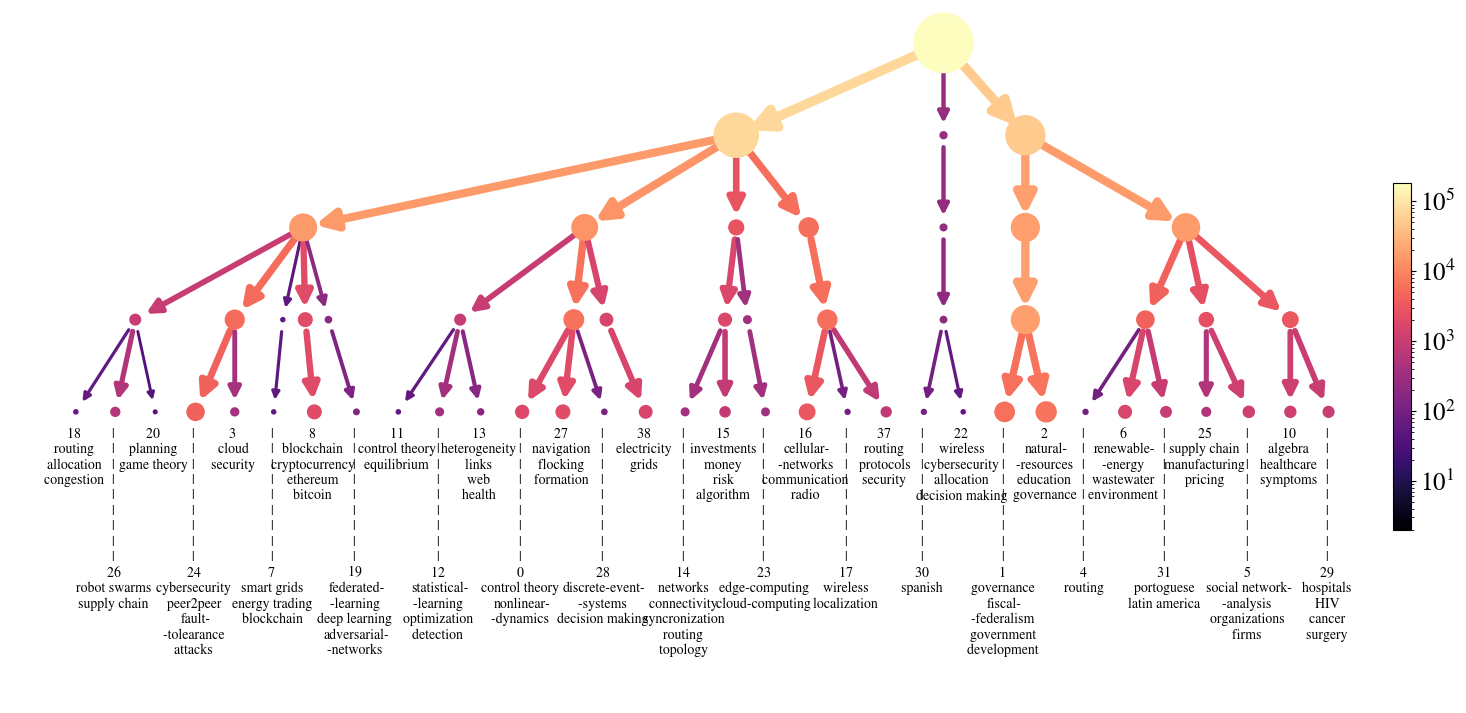

In [81]:
figsize=(21,9)
fig = plt.figure(figsize=figsize)
ax = plt.gca()
pos = create_hierarchy_network_docs(partition=0, top_level=6, bottom_level=2, 
                             max_num_clusters_to_represent=10000, num_words_to_represent=20, 
                             multiplicator_size_nodes=.01, multiplicator_size_edges=1, multiplicator_ypos=0.30,
                             fontsize = 10, ax=ax, fig=fig, threshold_num_papers = 500, num_spaces=50)

In [56]:
# level2_pos = [(x,y) for x,y in pos.items() if x.split("_")[0]=="2"]
# ordered_lev2_clusters_pos = sorted(level2_pos,key = lambda x:x[1][0])
# ordered_lev2_clusters = [int(x[0].split("_")[1].split("\n")[0]) for x in ordered_lev2_clusters_pos]

In [57]:
# print(ordered_lev2_clusters)

In [58]:
# ordered_hierarchy_lev_3 = []
# for c in ordered_lev2_clusters:
#     for c3 in hierarchy_docs[3].keys():
#         if c in hierarchy_docs[3][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev_3]:
#             ordered_hierarchy_lev_3.append((c3,hierarchy_docs[3][c3]))

In [59]:
# ordered_hierarchy_lev_3

# Papers analysis

In [49]:
l = 2

In [50]:
def find_kf_important_paper(cluster_from,cluster_to,year_from,year_to):
    set_papers_study = set([x for i,x in enumerate(ordered_paper_ids) if h_t_doc_consensus_by_level[l][i] == cluster_from])
    papers_in_study_dict = {}
    
    for paper_id in set_papers_study:
        paper = all_docs_dict[paper_id]
        if paper['year'] != year_from:
            continue
        papers_in_study_dict[paper_id] = {}
        tmp_count = {field:0 for field in all_clusters}
        for citing_paper_id in set(paper["inCitations"]).intersection(all_papers_ids):
            citing_paper = all_docs_dict[citing_paper_id]
            if citing_paper['year'] != year_to:
                continue
            for chosen_edge_field in citing_paper["assigned_cluster_list"]:
                tmp_count[chosen_edge_field] += 1/len(paper["assigned_cluster_list"])/len(citing_paper["assigned_cluster_list"])
        for field in all_clusters:
            papers_in_study_dict[paper_id][field] = tmp_count[field]

    papers_in_study_df = pd.DataFrame(papers_in_study_dict).transpose()

    selected_paper = papers_in_study_df[int(cluster_to)].sort_values(ascending=False).index.values[0]
    kf = papers_in_study_df[int(cluster_to)].sort_values(ascending=False).values[0]

    return selected_paper, kf

In [51]:
all_docs_dict[paper_id].keys()

dict_keys(['id', 'title', 'paperAbstract', 'authors', 'inCitations', 'outCitations', 'year', 's2Url', 'sources', 'pdfUrls', 'venue', 'journalName', 'journalVolume', 'journalPages', 'doi', 'doiUrl', 'pmid', 'fieldsOfStudy', 'magId', 's2PdfUrl', 'entities', 'assigned_cluster_list'])

In [52]:
_id = []
_title = []
_fields = []
_clusters_lev2 = []
_clusters_lev3 = []
_clusters_lev4 = []
_clusters_lev5 = []
_year = []
_doi = []
_abstract = []

for i,paper_id in enumerate(ordered_paper_ids):
    paper = all_docs_dict[paper_id]
    
    _id.append(paper_id)
    _title.append(paper['title'])
    _fields.append(paper['fieldsOfStudy'])
    _clusters_lev2.append(h_t_doc_consensus_by_level[2][i])
    _clusters_lev3.append(h_t_doc_consensus_by_level[3][i])
    _clusters_lev4.append(h_t_doc_consensus_by_level[4][i])
    _clusters_lev5.append(h_t_doc_consensus_by_level[5][i])
    _year.append(paper['year'])
    _doi.append(paper['doiUrl'])
    _abstract.append(paper['paperAbstract'])


In [53]:
all_papers_df = pd.DataFrame({'title':_title,
                             'abstract': _abstract,
                             'fields': _fields,
                             'year':_year,
                             'doi':_doi,
                             'clusters_lev2':_clusters_lev2,
                             'clusters_lev3':_clusters_lev3,
                             'clusters_lev4':_clusters_lev4,
                             'clusters_lev5':_clusters_lev5,
                             'citations_overall':centralities['citations_overall'], 
                             'in_degree':centralities['out_degree'], 
                             'eigenvector':centralities['eigenvector'],
                             'betweenness':centralities['betweenness'],
                             'closeness':centralities['closeness'],
                             'pagerank':centralities['pagerank'],
                             'katz':centralities['katz'],
                             'id':_id,
                             })

In [54]:
all_papers_df['decade'] = (all_papers_df['year'].fillna(-10) / 10).astype(int)*10

In [55]:
all_papers_df.sort_values("year").head(20).iloc[2]['title']

'Local self-government and centralization : the characteristics of each; and its practical tendencies, as affecting social, moral, and political welfare and progress, including comprehensive outlines of the English constitution'

In [56]:
all_papers_df.loc[all_papers_df.clusters_lev2.isin([1,2])].sort_values("year").iloc[:50]#.sort_values("in_degree",ascending=False).iloc[0]['abstract']

title  \
96484                            Ministère de l'Intérieur   
142319  Local self-government and centralization : the...   
152089  Recent Centralizing Tendencies in the Supreme ...   
99672   Recent centralizing tendencies in state educat...   
69978   Democracy and the organization of political pa...   
126325       The Centralization Of Administration In Ohio   
127170               De Indische decentralisatiewetgeving   
159003                                   The Labor Market   
146482  Regionalism and Administrative Decentralizatio...   
119262                                   The modern state   
77434   The Evolution of Provincial Finance in British...   
119508  Hunter, Merlin H. Outlines of Public Finance. ...   
116518  The Report of the Committee on Mississippi Flo...   
166355  What is to be done? : burning questions of our...   
133031             The city of to-morrow and its planning   
170533                  Nieuwe vormen van decentralisatie   
59727   25 jaren decentralisatie in Nederlandsch-Indië...   
150211                      Tropical Medicine and Hygiene   
169351  Uniform State Action: A Possible Substitute fo...   
171174                              The method of freedom   
135975                    A Re-statement of Indirect Rule   
136774  Executive Decentralisation with Functional Co‐...   
67975                           Technics and Civilization   
27407   Coördination of Federal, State, and Local Tax ...   
179929  The Royal Commission on Dominion-Provincial Re...   
146481            Three Aspects of Regional Consciousness   
84350                   State Centralization in the South   
158803                  Federal-State Personnel Relations   
22542   Centralization or decentralization? : a study ...   
155622                     The Nuer Of The Southern Sudan   
122310                                 The Garrison State   
137903  Forces of Urban Centralization and Decentraliz...   
110403  Administrative decentralization : a study of t...   
154641  Standardization of distribution in densely loa...   
105883  The new centralization : a study of intergover...   
107243  Centralised vs. Decentralised Government in Re...   
9131                  Capitalism, Socialism and Democracy   
138539         Orestes A. Brownson' The American Republic   
165901  Modernized Cameralism in the Third Reich: The ...   
82575   Francis Lieber's Theories of Society, Governme...   
150018                            A Marx for the Managers   
133126         Thomas Jefferson and Public Administration   
3622                       Decentralization and Democracy   
175992                       Francis Lieber's Nationalism   
178268  Mathematics in Government Service and Industry...   
153667  Worker's Control of Industry and the British L...   
172662         A Plea for Administrative Decentralization   
94514                      Study of Public Administration   
156430  Neighborhood Associations in Japan and Their D...   
12049   Integration vs. Decentralization in the Federa...   

                                                 abstract  \
96484   La délinquance, la violence et l’insécurité re...   
142319                                                      
152089                                                      
99672                                                       
69978   These effects of the dwindling of individualit...   
126325                                                      
127170                                                      
159003  This paper analyzes the case for fiscal federa...   
146482                                                      
119262  Nothing manifests the strengths and weaknesses...   
77434   A STUDY IN THE PROVINCIAL DECENTRALISATION OF ...   
119508  One could wish that the author had written a f...   
116518  (1) To begin with, the Committee attempted to ...   
166355  Rabocheye Dyelo’s assertions, which we have an...   
133031  This is a transla

In [57]:
keywords_clusters[2][10]

'algebra\nhealthcare\nsymptoms'

In [58]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# # Create the data
# rs = np.random.RandomState(1979)
# x = rs.randn(500)
# g = np.tile(list("ABCDEFGHIJ"), 50)
# df = pd.DataFrame(dict(x=x, g=g))
# m = df.g.map(ord)
# df["x"] += m

# # Initialize the FacetGrid object
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
# g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# # Draw the densities in a few steps
# g.map(sns.kdeplot, "x",
#       bw_adjust=.5, clip_on=False,
#       fill=True, alpha=1, linewidth=1.5)
# g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# # passing color=None to refline() uses the hue mapping
# # g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# # Define and use a simple function to label the plot in axes coordinates
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0, .2, label, fontweight="bold", color=color,
#             ha="left", va="center", transform=ax.transAxes)


# g.map(label, "x")

# # Set the subplots to overlap
# # g.figure.subplots_adjust(hspace=-.25)

# # Remove axes details that don't play well with overlap
# g.set_titles("")
# g.set(yticks=[], ylabel="")
# g.despine(bottom=True, left=True)

In [59]:
import importlib

In [60]:
importlib.reload(sn)

<module 'seaborn' from '/data/home/ahw701/env_enrico/envs/gt/lib/python3.9/site-packages/seaborn/__init__.py'>

In [61]:
all_papers_df.groupby(["decade","clusters_lev3"],as_index=False).doi.count().replace(-10,np.nan).dropna().rename({"doi":"papers"},axis=1).head(20)

decade  clusters_lev3  papers
16  1800.0             12       1
17  1800.0             14       1
18  1850.0             12       1
19  1860.0             13       1
20  1860.0             15       1
21  1870.0             15       1
22  1880.0             15       1
23  1890.0             12       2
24  1890.0             15       4
25  1900.0             12       2
26  1900.0             13       1
27  1900.0             14       1
28  1900.0             15       4
29  1910.0              1       1
30  1910.0             12       2
31  1910.0             15       1
32  1920.0             12       8
33  1920.0             14       4
34  1920.0             15       4
35  1930.0             12      10

In [62]:
knowledge_flow_normalized_per_field_in_time_by_level[2]

year_from  year_to  cluster_from  cluster_to  knowledge_flow
0             1963     1963             0           0            0.00
1             1963     1968             0           0           20.00
2             1963     1970             0           0            0.00
3             1963     1972             0           0            0.00
4             1963     1973             0           0            0.00
...            ...      ...           ...         ...             ...
1695704       2019     2020            40          40          616.65
1695705       2019     2021            40          40          411.10
1695706       2020     2020            40          40          565.50
1695707       2020     2021            40          40          565.50
1695708       2021     2021            40          40            0.00

[1695709 rows x 5 columns]

In [63]:
x = knowledge_flow_normalized_per_field_in_time_by_level[2]
x = x.loc[x.knowledge_flow>0]
x.loc[(x.cluster_from.isin([2,4]))&(x.cluster_to.isin([10,29]))&(x.year_from<1900)&(x.year_to<1900)&(x.knowledge_flow>0)]

Empty DataFrame
Columns: [year_from, year_to, cluster_from, cluster_to, knowledge_flow]
Index: []

In [64]:
# TODO same_brunch
# x[f'within_branch_lev_{3}'] = x.apply(lambda x:same_branch(x['cluster_from'],x['cluster_to'],3),axis=1)
# # x[f'within_branch_lev_{4}'] = x.apply(lambda x:same_branch(x['cluster_from'],x['cluster_to'],4),axis=1)

In [65]:
x.loc[(x.year_from<1950)&(x.year_to<1950)]

year_from  year_to  cluster_from  cluster_to  knowledge_flow
58062        1922     1939             1           2             1.0
165611       1935     1942             2           2             3.0
366491       1920     1925             5           5             1.0
550783       1889     1935            10          10             1.0
551315       1908     1919            10          10             2.0
551318       1908     1928            10          10             2.0
551320       1908     1935            10          10             2.0
551496       1923     1943            10          10             3.0
551572       1926     1926            10          10             2.0
551666       1928     1947            10          10             2.0
551743       1931     1940            10          10             1.0
552367       1945     1945            10          10             1.0

In [66]:
xx = x.groupby(['year_from','cluster_from'],as_index=False).knowledge_flow.mean()
xx.loc[xx.year_from<1950]

year_from  cluster_from  knowledge_flow
0        1800             5             1.0
1        1804             1             1.0
2        1851             1             1.0
3        1861            31             1.0
4        1868            10             1.0
..        ...           ...             ...
67       1948             2             4.0
68       1948            10             4.0
69       1948            31             4.0
70       1949             1             2.0
71       1949             2             2.0

[72 rows x 3 columns]

In [67]:
all_papers_df.loc[all_papers_df.year < 1950].clusters_lev2.value_counts()

10    34
2     31
1     20
5      7
31     6
29     2
16     1
24     1
Name: clusters_lev2, dtype: int64

## 1950s

In [68]:
all_papers_df.loc[(all_papers_df.decade.isin([1950]))].clusters_lev2.value_counts()

2     42
10    18
1     16
5     12
15     4
29     4
31     4
16     3
38     3
8      1
13     1
Name: clusters_lev2, dtype: int64

In [69]:
all_papers_df.loc[(all_papers_df.decade.isin([1950]))&~(all_papers_df.clusters_lev2.isin([1,2]))]

title  \
3300      Decentralization and the Transfer-Price Problem   
5131      Toward an Interactional Conception of Community   
5560    centralization vs. decentralization in organiz...   
5951    The Acquisitions and Cataloging of Research Li...   
9960                 On the Economics of Transfer Pricing   
21177     Managing geographically decentralized companies   
22888   Management Decentralization: An Historical Ana...   
25750   CENTRALIZATION AND DECENTRALIZATION IN ECONOMI...   
29338    The extended centralizer of a ring over a module   
34839             CENTRALIZATION VERSUS DECENTRALIZATION.   
39774      On finite groups with given conjugate types. I   
55027           A FEW CASES OF RETINITIS CENTRALIS SEROSA   
65541   Centralized Control Desirable for Single Boile...   
65542   Centralized Instrumentation and Controls for S...   
67818   Contribution to the chorioretinitis centralis ...   
79978   EVOKED ACTIVITY IN THE CAUDATE NUCLEUS OF THE ...   
80093   Capital Equipment Analysis: The Required Rate ...   
84595              On the tower theorem for finite groups   
90428   LARGE BRANCH FROM THE SUPERIOR TEMPORAL VEIN C...   
90648                       Centralized vs decentralized.   
97717   Left centralizers and isomorphisms of group al...   
99524   Über die Färbbarkeit des NISSLschen Grau an ve...   
99525   Örtliche Verschiedenheit der Mengenverhältniss...   
100168  The Balance between centralization and decentr...   
101129  Effect of decentralisation on the content of c...   
104872     SPHERICAL FUNCTIONS ON A SEMISIMPLE LIE GROUP.   
104873            The characters of semisimple Lie groups   
110451          On characterizations of linear groups. II   
111189  The effect of anticholinesterases on the parot...   
115408      External Economies, Investment, and Foresight   
116259             CENTRALIZING MEDICAL LIBRARY RESOURCES   
120450  Organization and Information Handling in Task ...   
135137  La conception de la décentralisation administr...   
136701  Monkeys in relation to the epidemiology of yel...   
137579              The Concept of Organizational Control   
140183  An experimental remote controlled line concent...   
140184         Common control telephone switching systems   
142305  Relation of Personnel Statistics to Organizati...   
153328  Course of fibers of brachium conjunctivum reve...   
154674  A Comment on the Pure Theory of Public Expendi...   
158871                    Centralizers in Jordan algebras   
161863  Über die inframikroskopische Strukturdichte de...   
163011  Centralization vs. Decentralization: The Case ...   
163786  [Expansion of the rod-free area of the fovea c...   
164845  [Centralization of muscular activity in loweri...   
165618             Organizing for Retail Decentralization   
166145  [Centralization of treatment in hypnotic poiso...   
166773                    The transformer analog computer   
171582  The multi-sequence computer as a communication...   
178827  The thalamic source of cortical recruiting in ...   

                                                 abstract  \
3300                                                        
5131    T IHE GROWING CONCERN of the general public an...   
5560                                                        
5951    IN ITS report to Congress in 1815 the Joint Co...   
9960    TN ORDER to achieve the benefits of decentrali...   
21177                                                       
22888   This article deals with development of basic m...   
25750   The preference for decentralization in the cla...   
29338   In a recent paper,' K. Asano gave a new proof ...   
34839   Thirteen years ago, the American Political Sci...   
39774   Let G be a finite group. Let n 1 , n 2 ,…, n r...   
55027   The following work is a contribution to the ca...   
65541                                                       
65542                                                       
67818                    

In [70]:
x.loc[(x.year_from<1960)&(x.year_to<1960)&(x.knowledge_flow>0)&(x.cluster_from!=x.cluster_to)]

year_from  year_to  cluster_from  cluster_to  knowledge_flow
58062       1922     1939             1           2             1.0
58944       1950     1950             1           2             6.0
59025       1951     1959             1           2             3.5

## 1960s

In [71]:
all_papers_df.loc[(all_papers_df.decade.isin([1960]))].clusters_lev2.value_counts()

10    138
2      98
1      51
5      50
15     29
31     14
29     13
16      8
24      5
38      3
33      2
0       2
20      2
11      2
6       2
27      1
28      1
13      1
39      1
Name: clusters_lev2, dtype: int64

In [72]:
keywords_clusters[2][15]

'money\nrisk\ninvestment\nalgorithm'

In [73]:
all_papers_df.loc[(all_papers_df.decade.isin([1960]))&(all_papers_df.clusters_lev2.isin([15]))].sort_values("in_degree",ascending=False)

title  \
112914  EFFECTIVE CONTROL THROUGH COHERENT DECENTRALIZ...   
58768   Decision Making Behaviours Represented in a Fo...   
68894   The Assignment of Costs to Joint Products in a...   
61889   On the Comparison of Centralized and Decentral...   
103289  On the Concept and Possibility of Informationa...   
174627  Competitive Organizational Structures in Coupl...   
27856               Decentralized Procedures for Planning   
62343                   On Choosing an Optimal Technology   
67641           Decentralization in Separable Programming   
69281   Computation In Organizations: Comparison Of Pr...   
84424   INDUSTRIAL DEVELOPMENT PLANNING MODELS WITH EC...   
101761                                 Volume Information   
8252    Decomposition, Pricing for Decentralization an...   
1262    EFFECTIVE CONTROL THROUGH COHERENT DECENTRALIZ...   
172900  Centralization and decentralization of decisio...   
103603    Public Goods and Decentralization of Production   
159338  OPTIMAL PATHS OF CAPITAL ACCUMULATION UNDER TH...   
157778            Planning in decentralized organizations   
123205  Centralized Versus Decentralized Resource Allo...   
113251  INFORMATIONAL EFFICIENCY AND DECENTRALIZATION ...   
83995           Studies in Resource Allocation Processes.   
101762  An Economic Analysis of Internal Migration in ...   
84425   Plant Location Under Economies-of-Scale---Dece...   
7562          Decomposition Principle for Linear Programs   
75566          Price Guides in Decentralized Organization   
75390      The Evaluation of Information in Organizations   
51199                             Planning without Prices   
48815       Labour Allocation in a Cooperative Enterprise   
179374  A Reinterpretation of the Pure Theory of Exhau...   

                                                 abstract  \
112914  The theory of economic models of decentralizat...   
58768   Following the definitions of concepts of the l...   
68894   T .JTHEN two or more products are jointly prod...   
61889                                                       
103289                                                      
174627  The effect of different company organizational...   
27856   One of the main aims of long-term plans, which...   
62343   This paper is concerned with the problem of ch...   
67641                                                       
69281   We shall be concerned in this paper with the g...   
84424   In the field of industrial planning and planni...   
101761  Andersen, Leonall C. Federal Reserve Defensive...   
8252    The decomposition procedure for the solution o...   
1262    Abstract : This paper shows that control throu...   
172900  L’accès aux archives de la revue « Revue franç...   
103603                                                      
159338  Abstract : The important question of investmen...   
157778                                                      
123205  I. Introduction: comparing allocation mechanis...   
113251                                                      
83995   One of the central questions of economics rela...   
101762  Analyzing interstate migration in Brazil 3 hyp...   
84425   An exploration of the margin of error entailed...   
7562    A technique is presented for the decomposition...   
75566                                                       
75390   Abstract : Contents: Team decision problems wi...   
51199   Discussions of decentralized planning procedur...   
48815   Two methods of income distribution have been p...   
179374  EVENTUAL exhaustion of natural resources is of...   

                               fields    year  \
112914                    [Economics]  1967.0   
58768              [Computer Science]  1969.0   
68894                      [Business]  1968.0   
61889                     [Economics]  1969.0   
103289                    [Economics]  1969.0   
174627                    [Economics]  1968.0   
27856                   [Engineering]  1967.0  

In [74]:
t=x.loc[(x.year_from<1970)&(x.year_to<1970)&(x.knowledge_flow>0)&(x.cluster_from!=x.cluster_to)].copy()
z = t.apply(lambda x:find_kf_important_paper(x['cluster_from'],x['cluster_to'],x['year_from'],x['year_to']),axis=1)
t[['paper_id','kf']] = z.to_list()
t['title'] = t.paper_id.apply(lambda x:all_docs_dict[x]['title'])

In [75]:
t

year_from  year_to  cluster_from  cluster_to  knowledge_flow  \
58062         1922     1939             1           2        1.000000   
58259         1934     1968             1           2        3.000000   
58944         1950     1950             1           2        6.000000   
59025         1951     1959             1           2        3.500000   
59424         1960     1963             1           2        7.333333   
59491         1961     1968             1           2        5.750000   
177696        1960     1968             2           5        2.000000   
177880        1963     1969             2           5        3.333333   
210291        1953     1964             2          16        2.000000   
388192        1956     1967             5          15        2.000000   
388504        1961     1967             5          15        7.666667   
814233        1960     1963            15           0       22.000000   
814234        1960     1968            15           0       22.000000   
818437        1959     1967            15           2       19.000000   
824505        1960     1961            15           5       22.000000   
824694        1964     1968            15           5        7.500000   
824695        1964     1969            15           5       15.000000   
1272092       1966     1968            27           5       24.500000   

                                         paper_id   kf  \
58062    6ed1e68e2e06e77027abb2d3392d02c369e82f7a  1.0   
58259    a6e6b369e01240e3f3c76405285510a033fdb84a  1.0   
58944    a012028e6830c5fe466194d092a8e066d81cc685  1.0   
59025    a935e2106cb77ae65a1f6ea805e0828880824a29  1.0   
59424    dd5332ae557525edbaa7858450fff8394f0ddd51  1.0   
59491    8ac7561b09c20b393bdbda37ad74473ed9c1f34f  1.0   
177696   14349039ab994d05aa5be7f666748d2138564ef8  1.0   
177880   9548e326f8ec5b8da61b0c89782ec16e44268973  1.0   
210291   19eac23d652f9b8e2098238d9414001439701693  1.0   
388192   8c495ad959ea4fd25f9733f64ef30bd1116bc07f  1.0   
388504   dde88e5b14227a107bba25ebf0fa78bd93194d9f  1.0   
814233   6c7a9b049927e6756fbaf425e323c1aad05591f8  1.0   
814234   6c7a9b049927e6756fbaf425e323c1aad05591f8  1.0   
818437   c138866124b3d8dcbd0c6b1c191426d6de76ef92  1.0   
824505   6c7a9b049927e6756fbaf425e323c1aad05591f8  1.0   
824694   5240fe445be9d06cb71181e8320fe52425a311bf  1.0   
824695   a54807c4dbfccbef2935f80bef49229eaadcdb9e  1.0   
1272092  c1058d5807656a31599743f1e06c5a5d114d640a  1.0   

                                                     title  
58062    Regionalism and Administrative Decentralizatio...  
58259                      A Re-statement of Indirect Rule  
58944    The States and Decentralized Administration of...  
59025                 Patterns of Authority in West Africa  
59424    Indigenous Politics and Colonial Administratio...  
59491    The Relation of Local Government Structure to ...  
177696   Correlates of Trade Union Participation: A Sum...  
177880   From Evangelism to General Services: The Trans...  
210291                      Cooperation and Centralization  
388192                On the Economics of Transfer Pricing  
388504   Incentives, Decentralized Control, the Assignm...  
814233         Decomposition Principle for Linear Programs  
814234         Decomposition Principle for Linear Programs  
818437   CENTRALIZATION AND DECENTRALIZATION IN ECONOMI...  
824505         Decomposition Principle for Linear Programs  
824694   Decomposition, Pricing for Decentralization an...  
824695   Plant Location Under Economies-of-Scale---Dece...  
1272092  Allocating Weapons to Target Complexes by Mean...

## 1970s

In [76]:
all_papers_df.loc[(all_papers_df.decade.isin([1970]))].clusters_lev2.value_counts()

10    508
2     395
1     206
5     140
15    125
0     118
11    110
31     46
24     45
6      32
29     29
27     21
14     18
16     17
4      11
25     10
13      7
21      6
38      5
22      5
28      4
23      4
8       3
3       3
39      2
30      2
19      2
26      2
12      2
20      1
18      1
34      1
17      1
40      1
Name: clusters_lev2, dtype: int64

In [77]:
keywords_clusters[2][15]

'money\nrisk\ninvestment\nalgorithm'

In [78]:
all_papers_df.loc[(all_papers_df.decade.isin([1970]))&~(all_papers_df.clusters_lev2.isin([156]))].sort_values("in_degree",ascending=False)

title  \
351     Survey of decentralized control methods for la...   
74972   The multilevel approach to organizational issu...   
39853   Decentralisation in Administration : A Select ...   
76762   The Design of Distributed Computer Control Sys...   
94363     On Decentralized Control of Large-Scale Systems   
...                                                   ...   
91420                                  Agrarian Socialism   
91289        Privacy transformations for databank systems   
90988   Decentralization and Citizen Participation in ...   
90968   Retinal degeneration associated with the feedi...   
181537   IGR and the Executive Branch: the New Federalism   

                                                 abstract  \
351     This paper surveys the control theoretic liter...   
74972   This paper critically reviews the progress and...   
39853                                                       
76762   Abstract The complexity of decentralised contr...   
94363   A scheme is presented for decentralized contro...   
...                                                   ...   
91420   In the introduction the authors explain the re...   
91289   The term databank implies a centralized collec...   
90988   Criminal justice systems are one of the mechan...   
90968   : Retinal degeneration was observed in cats fe...   
181537  IGR and the New Federalism are synonymous. For...   

                     fields    year  \
351           [Engineering]  1978.0   
74972           [Economics]  1977.0   
39853            [Business]  1978.0   
76762    [Computer Science]  1979.0   
94363         [Mathematics]  1978.0   
...                     ...     ...   
91420           [Sociology]  1974.0   
91289    [Computer Science]  1973.0   
90988   [Political Science]  1972.0   
90968            [Medicine]  1978.0   
181537          [Economics]  1974.0   

                                                      doi  clusters_lev2  \
351              https://doi.org/10.1109/TAC.1978.1101704              0   
74972    https://doi.org/10.1016/0305-0483%2877%2990004-4             15   
39853            https://doi.org/10.1177/0019556119780345              1   
76762   https://doi.org/10.1016/S1474-6670%2817%2965397-7             11   
94363   https://doi.org/10.1016/S1474-6670%2817%2966158-5              0   
...                                                   ...            ...   
91420          https://doi.org/10.1177/000944557401000310              2   
91289             https://doi.org/10.1145/1499586.1499732             24   
90988                      https://doi.org/10.2307/975235              2   
90968                                                                 10   
181537         https://doi.org/10.1177/000271627441600105              1   

        clusters_lev3  clusters_lev4  clusters_lev5  citations_overall  \
351                 6              1              0               1084   
74972               8              4              0                 70   
39853              12              2              2                  0   
76762               5              1              0                 11   
94363               6              1              0                  2   
...               ...            ...            ...                ...   
91420              12              2              2                 30   
91289               1              0              0                 13   
90988              12              2              2                 10   
90968              15              3              2                 27   
181537             12              2              2                  5   

        in_degree    eigenvector   betweenness  closeness  pagerank      katz  \
351          21.0   3.054954e-03  6.846632e-05   0.571429  0.002048  0.016039   
74972        20.0   1.876020e-04  9.558314e-06   0.590164  0.000035  0.002769   
39853        19.0   0.000000e+00  0.000000e+00   0.913043  0.000002  0.0

In [79]:
all_papers_df.loc[all_papers_df.title.str.contains("clarification")]

title  \
3086    Centrality in social networks conceptual clari...   
49968   Tailored water treatment using enhanced primar...   
75487   Knowledge heterogeneity and social network ana...   
148758  Taxonomic status of the Australian burrowing f...   
159490  Electronic marketplace definition and classifi...   
178130  Power relinquishment versus power sharing: The...   

                                                 abstract  \
3086    Abstract The intuitive background for measures...   
49968   An emerging strategy for urban water infrastru...   
75487   This literature review highlights some Social ...   
148758  I review genetic and call structure data avail...   
159490  The definitions and classifications of any new...   
178130  This article presents a theoretical and empiri...   

                              fields    year  \
3086                    [Psychology]  1978.0   
49968        [Environmental Science]  2017.0   
75487                    [Sociology]  2008.0   
148758                     [Biology]  2010.0   
159490  [Business, Computer Science]  2007.0   
178130                  [Psychology]  1987.0   

                                                      doi  clusters_lev2  \
3086     https://doi.org/10.1016/0378-8733%2878%2990021-7              5   
49968                  https://doi.org/10.1039/C7EW00019G              6   
75487                 https://doi.org/10.1057/kmrp.2008.9              5   
148758  https://doi.org/10.18195/issn.0312-3162.25%284...             10   
159490          https://doi.org/10.1080/17517570601088380              8   
178130         https://doi.org/10.1037/0021-9010.72.2.228              2   

        clusters_lev3  clusters_lev4  clusters_lev5  citations_overall  \
3086               14              3              2              13287   
49968              13              3              2                  2   
75487              14              3              2                 16   
148758             15              3              2                  6   
159490              3              0              0                 79   
178130             12              2              2                157   

        in_degree    eigenvector   betweenness  closeness  pagerank      katz  \
3086          2.0   2.794759e-04  9.355892e-07   1.000000  0.000886  0.014797   
49968         6.0   0.000000e+00  0.000000e+00   0.402062  0.000002  0.002238   
75487         4.0   0.000000e+00  0.000000e+00   0.555556  0.000002  0.002238   
148758        4.0   0.000000e+00  0.000000e+00   0.833333  0.000002  0.002238   
159490        0.0  1.507053e-135  0.000000e+00        NaN  0.000004  0.002266   
178130        0.0   0.000000e+00  0.000000e+00        NaN  0.000005  0.002261   

                                              id  decade  
3086    5d61ef638fd684facc1e68e654053e9bc065b36f    1970  
49968   1cea8196541069cd591424b8bc9af1cf2556eaf8    2010  
75487   75f87edd4833d372b2e6791b5b70f0fd76769585    2000  
148758  469b10cb329c3fa21482f017d85371508b280245    2010  
159490  090596364357b5e6727ca9b2f02972f6b6213dc3    2000  
178130  4c36e3e73a05ed4ecdecf103e40f8f0421d92302    1980

In [80]:
t = x.loc[(x.year_from<1980)&(x.knowledge_flow>2)&(x.cluster_from!=x.cluster_to)&(x.cluster_from==5)].copy() #&(x.year_to<1980) (x.year_from>=1970)&(x.year_to>=1970)
z = t.apply(lambda x:find_kf_important_paper(x['cluster_from'],x['cluster_to'],x['year_from'],x['year_to']),axis=1)
t[['paper_id','kf']] = z.to_list()
t['title'] = t.paper_id.apply(lambda x:all_docs_dict[x]['title'])

In [81]:
t

year_from  year_to  cluster_from  cluster_to  knowledge_flow  \
356187       1941     2007             5           1        7.000000   
356193       1941     2013             5           1        3.500000   
356244       1954     1996             5           1        6.000000   
356249       1954     2001             5           1        6.000000   
356259       1954     2011             5           1        3.000000   
...           ...      ...           ...         ...             ...   
426167       1979     2012             5          31        8.794118   
430524       1962     2020             5          34        6.200000   
431131       1979     2007             5          34       17.588235   
433348       1978     2020             5          37       18.214286   
437605       1978     2020             5          39       18.214286   

                                        paper_id   kf  \
356187  c75c4fa9ef3f821e4a2da4718217d9634f2a5594  1.0   
356193  c75c4fa9ef3f821e4a2da4718217d9634f2a5594  1.0   
356244  7a3a90d07cb5e88713643cec6324ac0c51c8e085  1.0   
356249  7a3a90d07cb5e88713643cec6324ac0c51c8e085  1.0   
356259  7a3a90d07cb5e88713643cec6324ac0c51c8e085  1.0   
...                                          ...  ...   
426167  d16eea8cabab99c23d7804853b8ce20cfb132b34  1.0   
430524  8897c6248b6d5c55eac6d916a4bc4c0a34b55f19  1.0   
431131  d16eea8cabab99c23d7804853b8ce20cfb132b34  1.0   
433348  5d61ef638fd684facc1e68e654053e9bc065b36f  1.0   
437605  5d61ef638fd684facc1e68e654053e9bc065b36f  1.0   

                                                    title  
356187                             The new centralization  
356193                             The new centralization  
356244  centralization vs. decentralization in organiz...  
356249  centralization vs. decentralization in organiz...  
356259  centralization vs. decentralization in organiz...  
...                                                   ...  
426167                   The Structuring of Organizations  
430524  战略与结构 : 美国工商企业成长的若干篇章=strategy and structure :...  
431131                   The Structuring of Organizations  
433348  Centrality in social networks conceptual clari...  
437605  Centrality in social networks conceptual clari...  

[427 rows x 8 columns]

In [82]:
keywords_clusters[2][11]

'control theory\nequilibrium'

In [83]:
keywords_clusters[2][0]

'control theory\nnonlinear dynamics'

In [84]:
len(all_papers_df.loc[all_papers_df.clusters_lev2 == 11])

926

## kf important papers

In [85]:
t = x.iloc[:10].copy()
z = t.apply(lambda x:find_kf_important_paper(x['cluster_from'],x['cluster_to'],x['year_from'],x['year_to']),axis=1)


In [86]:
t[['paper_id','kf']] = z.to_list()

In [87]:
t

year_from  year_to  cluster_from  cluster_to  knowledge_flow  \
1         1963     1968             0           0       20.000000   
44        1963     2013             0           0       20.000000   
56        1968     1972             0           0       67.000000   
112       1970     1976             0           0       42.333333   
113       1970     1977             0           0       42.333333   
152       1970     2016             0           0       42.333333   
160       1972     1973             0           0       27.555556   
161       1972     1974             0           0       27.555556   
162       1972     1975             0           0       27.555556   
163       1972     1976             0           0       24.800000   

                                     paper_id   kf  
1    315e02a55566f30be9c2a1909988c0e5b753fee3  1.0  
44   315e02a55566f30be9c2a1909988c0e5b753fee3  1.0  
56   97052b575a179126d1f307ed47f3db396d8bd210  1.0  
112  4d45c8cdbee9e3af50d2ab7bdecc46c9492383ef  1.0  
113  8d96368c54f22ceb7d1c9aa1dcafa04bb12a4925  1.0  
152  251a9eac5924788706fa9c5e1feb6b9859e01882  1.0  
160  fcce2f437ec75b7c6b32b560ddab983b91231b7b  2.0  
161  fcce2f437ec75b7c6b32b560ddab983b91231b7b  2.0  
162  fcce2f437ec75b7c6b32b560ddab983b91231b7b  4.0  
163  fcce2f437ec75b7c6b32b560ddab983b91231b7b  6.0

In [88]:
l = 2
threshold = 3
num_papers_to_show = 1

_year_from = []
_year_to = []
_cluster_from = []
_cluster_to = []
_paper_id = []
_kf = []

for cluster_from in tqdm(np.unique(h_t_doc_consensus_by_level[l])):
    set_papers_study = set([x for i,x in enumerate(ordered_paper_ids) if h_t_doc_consensus_by_level[l][i] == cluster_from])
    set_years_from_study = set([all_docs_dict[x]['year'] for i,x in enumerate(ordered_paper_ids) if h_t_doc_consensus_by_level[l][i] == cluster_from and all_docs_dict[x]['year'] is not None])
    set_years_to_study = set([all_docs_dict[p]['year'] for i,x in enumerate(ordered_paper_ids) for p in all_docs_dict[x]['inCitations']  if p in all_papers_ids and h_t_doc_consensus_by_level[l][i] == cluster_from and all_docs_dict[p]['year'] is not None])
    
    for year_from in set_years_from_study:
        for year_to in set_years_to_study:
            if year_from > year_to:
                continue
                
            tmp = knowledge_flow_normalized_per_field_in_time_by_level[2]
            tmp = tmp.loc[tmp.cluster_from == cluster_from]
            tmp = tmp.loc[tmp.knowledge_flow>0]
            tmp = tmp.loc[(tmp.year_from == year_from)&(tmp.year_to == year_to)]
            
            if len(tmp) == 0:
                continue
            
            papers_in_study_dict = {}
            for paper_id in set_papers_study:
                paper = all_docs_dict[paper_id]
                if paper['year'] != year_from:
                    continue
                papers_in_study_dict[paper_id] = {}
                tmp_count = {field:0 for field in all_clusters}
                for citing_paper_id in set(paper["inCitations"]).intersection(all_papers_ids):
                    citing_paper = all_docs_dict[citing_paper_id]
                    if citing_paper['year'] != year_to:
                        continue
                    for chosen_edge_field in citing_paper["assigned_cluster_list"]:
                        tmp_count[chosen_edge_field] += 1/len(paper["assigned_cluster_list"])/len(citing_paper["assigned_cluster_list"])
                for field in all_clusters:
                    papers_in_study_dict[paper_id][field] = tmp_count[field]

            papers_in_study_df = pd.DataFrame(papers_in_study_dict).transpose()

            for cluster_to,z_score in zip(tmp.cluster_to,tmp.knowledge_flow):
                if z_score > threshold:

                    selected_paper = papers_in_study_df[cluster_to].sort_values(ascending=False).iloc[:num_papers_to_show].index.values[0]
                    kf = papers_in_study_df[cluster_to].sort_values(ascending=False).iloc[:num_papers_to_show].values[0]
                    _year_from.append(year_from)
                    _year_to.append(year_to)
                    _cluster_from.append(cluster_from)
                    _cluster_to.append(cluster_to)
                    _paper_id.append(selected_paper)
                    _kf.append(kf)


  0%|          | 0/41 [00:00<?, ?it/s]

## blockchain

To look at the papers of blockchain and his children clusters at level 1, look at cluster_labelling.ipynb, section Print level 1 clusters of Blockchain

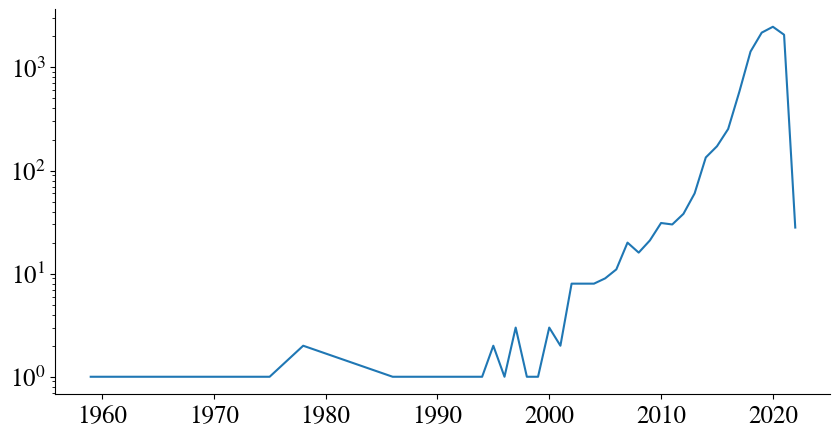

In [89]:
all_papers_df.loc[(all_papers_df.clusters_lev2 == 8)].year.value_counts().sort_index().plot()
plt.yscale("log")

In [90]:
keywords_clusters[2][15]

'money\nrisk\ninvestment\nalgorithm'

In [91]:
all_papers_df.loc[(all_papers_df.clusters_lev2.isin([8]))].sort_values("year",ascending=True)#.iloc[1]

title  \
163011  Centralization vs. Decentralization: The Case ...   
10927                     The Meaning of Decentralization   
101149          The banking and credit system of the USSR   
41434          Distributed Database Technology - A Survey   
102625  Distributing the power of a government to enha...   
...                                                   ...   
147664  Cryptosecession and the limits of taxation : T...   
159207  Poster: An Offline Delegatable Cryptocurrency ...   
160207     Integrated platforms for blockchain enablement   
175639  A proof-of-stake based decentralized custodian...   
178137  Modern electronic payment systems rely on trus...   

                                                 abstract  \
163011                                                      
10927                                                       
101149  1. Definition of the problem and introductory ...   
41434   Abstract For a number of reasons there has rec...   
102625  In this paper, we distribute the functions of ...   
...                                                   ...   
147664  This paper presents a model of partial interna...   
159207  In this poster, we propose an offline delegata...   
160207  The Internet of Things (IoT) is experiencing a...   
175639                                                      
178137  • Modern electronic payment systems rely on tr...   

                       fields    year  \
163011    [Political Science]  1959.0   
10927             [Sociology]  1975.0   
101149  [Economics, Business]  1978.0   
41434      [Computer Science]  1978.0   
102625     [Computer Science]  1986.0   
...                       ...     ...   
147664                     []     NaN   
159207                     []     NaN   
160207                     []     NaN   
175639                     []     NaN   
178137                     []     NaN   

                                                     doi  clusters_lev2  \
163011                   https://doi.org/10.2307/3004132              8   
10927     https://doi.org/10.1080/00220973.1943.11019391              8   
101149       https://doi.org/10.1007/978-1-4613-4048-5_3              8   
41434   https://doi.org/10.1016/0376-5075%2878%2990025-9              8   
102625               https://doi.org/10.1145/10590.10595              8   
...                                                  ...            ...   
147664                                                                8   
159207                                                                8   
160207                                                                8   
175639                                                                8   
178137                                                                8   

        clusters_lev3  clusters_lev4  clusters_lev5  citations_overall  \
163011              3              0              0                  2   
10927               3              0              0                 57   
101149              3              0              0                  8   
41434               3              0              0                  7   
102625              3              0              0                245   
...               ...            ...            ...                ...   
147664              3              0              0                  5   
159207              3              0              0                  1   
160207              3              0              0                  6   
175639              3              0              0                  0   
178137              3              0              0                  0   

        in_degree   eigenvector   betweenness  closeness  pagerank      katz  \
163011        0.0  0.000000e+00  0.000000e+00        NaN  0.000002  0.002260   
10927         0.0  2.858444e-55  0.000000e+00        NaN  0.000019  0.003132   
101149        0.0  0.000000e+00  0.000000e+00        NaN  0.000

In [92]:
def find_citations_paper(paper_id):
    
    return all_papers_df.loc[all_papers_df.id.isin(all_docs_dict[paper_id]['inCitations'])].clusters_lev2.value_counts()

In [93]:
find_citations_paper("63a9681663778913982f8f028e170be5ff36f532")

8    39
Name: clusters_lev2, dtype: int64

In [94]:
all_papers_df.loc[all_papers_df.id.isin(all_docs_dict["63a9681663778913982f8f028e170be5ff36f532"]['inCitations'])].iloc[0]#title#.iloc[15]#.abstract#title

title                Measuring Decentrality in Blockchain Based Sys...
abstract             Blockchain promises to provide a distributed a...
fields                                              [Computer Science]
year                                                            2020.0
doi                        https://doi.org/10.1109/ACCESS.2020.3026577
clusters_lev2                                                        8
clusters_lev3                                                        3
clusters_lev4                                                        0
clusters_lev5                                                        0
citations_overall                                                    3
in_degree                                                         34.0
eigenvector                                                        0.0
betweenness                                                   0.000001
closeness                                                      0.13361
pagera

In [95]:
# t=x.loc[(x.cluster_to == 8)&(x.knowledge_flow>0)&(x.cluster_from!=x.cluster_to)].copy()
# z = t.apply(lambda x:find_kf_important_paper(x['cluster_from'],x['cluster_to'],x['year_from'],x['year_to']),axis=1)
# t[['paper_id','kf']] = z.to_list()
# t['title'] = t.paper_id.apply(lambda x:all_docs_dict[x]['title'])

In [96]:
# t[t.knowledge_flow > 2]#.cluster_from.value_counts()

In [97]:
# t[(t.cluster_from.isin([5]))&(t.knowledge_flow>=2)].title.value_counts()

In [98]:
# t[(t.knowledge_flow>=2)].title.value_counts().iloc[:20]

In [99]:
# t.loc[(t.within_branch_lev_3 == 0)&(t.knowledge_flow>2)].groupby("cluster_from").title.value_counts()#[1]

### DAOs and DeFi

In [100]:
print('defi:',len(all_papers_df.loc[(all_papers_df.abstract.str.contains(" defi ",case=False))&(all_papers_df.clusters_lev2==8)]))

defi: 60


In [101]:
print('dao:',len(all_papers_df.loc[(all_papers_df.abstract.str.contains(" dao ",case=False))&(all_papers_df.clusters_lev2==8)]))

dao: 55


# Figure 1

Do hierarchy plot to paste into main figure, and to get pos for main histograms

In [119]:
N = 256
vals = np.ones((N, 3))
val = 100/256
vals[:, 0] = np.linspace(val, val, N)
vals[:, 1] = np.linspace(val, val, N)
vals[:, 2] = np.linspace(val, val, N)
newcmp = ListedColormap(vals)

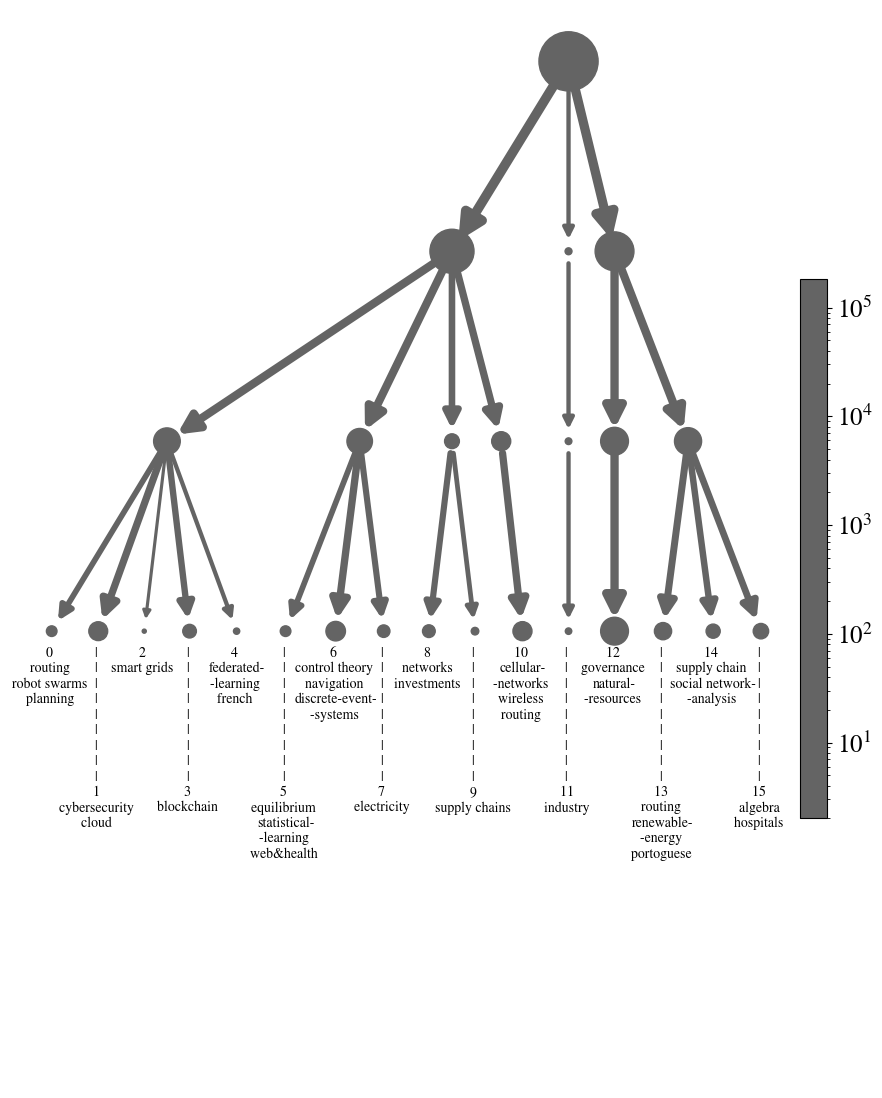

In [120]:
figsize=(12,14)
fig = plt.figure(figsize=figsize)
ax = plt.gca()
# plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1)), ax=ax,shrink=0.5,pad=0.,fraction=0.2)
pos = create_hierarchy_network_docs(partition=0, top_level=6, bottom_level=3, 
                             max_num_clusters_to_represent=10000, num_words_to_represent=20, 
                             multiplicator_size_nodes=.01, multiplicator_size_edges=1, multiplicator_ypos=0.30,
                             fontsize = 10, ax=ax, fig=fig, threshold_num_papers = 500, num_spaces=50,cmap = newcmp)# matplotlib.cm.get_cmap('black'))
plt.savefig(paper_figures_folder + "cluster_analysis/hierarchy_clusters_colorless_for_figure_1.pdf")

Get data for (a) and (b)

In [62]:
with gzip.open(all_dataset_path+"no_papers_in_fields_by_year.pkl.gz","rb") as fp:
    papers_per_year_per_field = pickle.load(fp)
    
with gzip.open(all_dataset_path+"no_authors_in_fields_by_year.pkl.gz","rb") as fp:
    authors_per_year_per_field = pickle.load(fp)
    
    
try:
    with gzip.open(all_dataset_path+"no_authors_by_year.pkl.gz","rb") as fp:
        no_authors_per_year = pickle.load(fp)
except Exception as e:
    print(e)
    with gzip.open(all_dataset_path+"sets_authors_in_fields_by_year.pkl.gz","rb") as fp:
        set_authors_per_year_per_field = pickle.load(fp)
     
    no_authors_per_year = {}
    for year in set_authors_per_year_per_field.keys():
        no_authors_per_year[year] = len(set().union(*list(set_authors_per_year_per_field[year].values())))
                                        
    with gzip.open(all_dataset_path+"no_authors_by_year.pkl.gz","wb") as fp:
        pickle.dump(no_authors_per_year,fp)  

In [63]:
years = sorted([x for x in papers_per_year_per_field.keys() if x is not None and x > 1500])

set_authors_per_year_decentralization = {y:set() for y in years}
for paper in all_docs_dict.values():
    if paper['year'] is not None:
        set_authors_per_year_decentralization[paper['year']].update([aut['ids'][0] for aut in paper['authors'] if paper['authors'] is not None and len(paper['authors'])>0 and len(aut['ids'])>0])
        
no_authors_per_year_decentralization = {y:len(set_authors_per_year_decentralization[y]) for y in years}

Get data for (c)

In [64]:
year_cluster_field_no_papers_df_by_level = {}
for level in tqdm(name2partition_by_level.keys()):
# level = 2
    dict_nested = {}
    for paper_id,cluster in name2partition_by_level[level].items():
        paper = all_docs_dict[paper_id]
        year = paper["year"]
        if year is not None:
            for field in paper["fieldsOfStudy"]:
    #             dict_nested.setdefault(year,{}).setdefault(cluster,{}).setdefault(field,0) 
                dict_nested.setdefault(field,{}).setdefault(cluster,{y:0 for y in range(1950,2022)})
                dict_nested[field][cluster].setdefault(year,0) 
                dict_nested[field][cluster][year] += 1./len(paper["fieldsOfStudy"])

    dict_for_df = {"year":[], "cluster":[], "field":[], "no_papers":[]}
    for field,_ in dict_nested.items():
        for cluster,_2 in _.items():
            for year,no_papers in _2.items():
                dict_for_df["year"].append(int(year))
                dict_for_df["cluster"].append(cluster)
                dict_for_df["field"].append(field)
                dict_for_df["no_papers"].append(no_papers)
    year_cluster_field_no_papers_df_by_level[level] = pd.DataFrame(dict_for_df)    

  0%|          | 0/8 [00:00<?, ?it/s]

Do main figure

/data/home/ahw701/env_enrico/envs/gt/lib/python3.9/site-packages/pandas/core/indexes/base.py:3706: RuntimeWarning: '<' not supported between instances of 'NoneType' and 'int', sort order is undefined for incomparable objects
  join_index = self.union(other)
/tmp/2207198.1.all.q/ipykernel_4977/2155359734.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


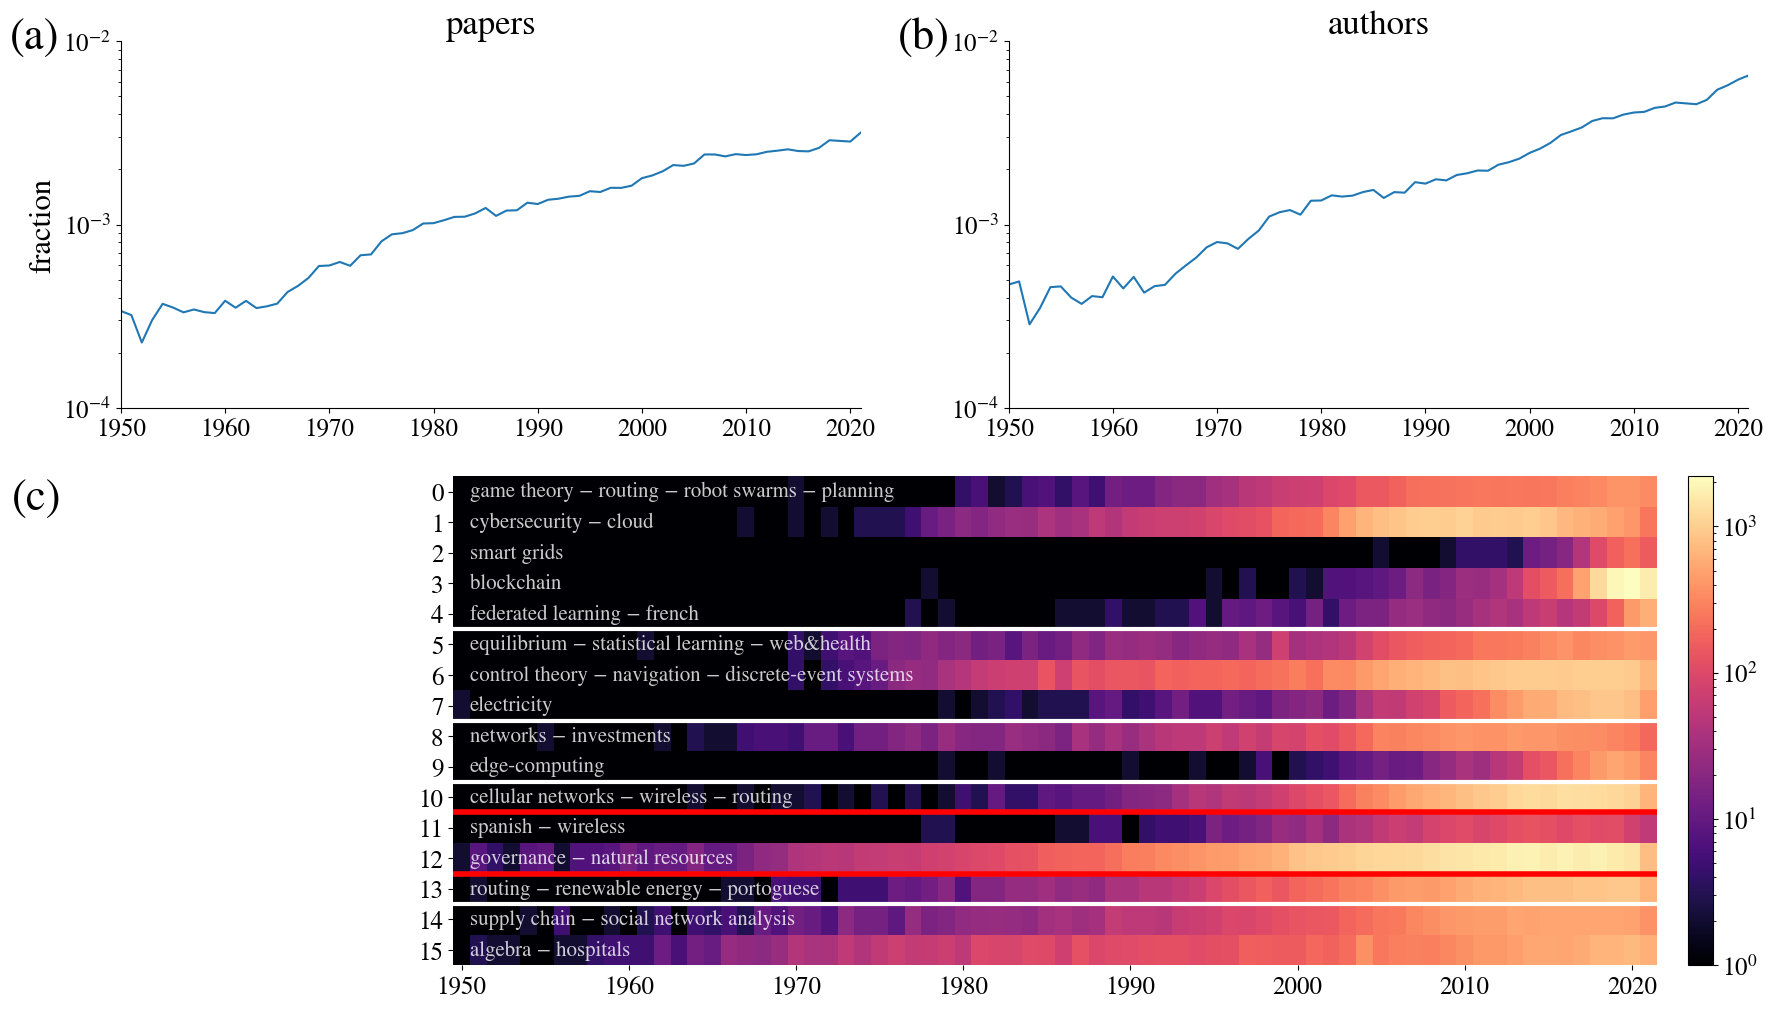

In [121]:
l = 3
year_cluster_log = year_cluster_field_no_papers_df_by_level[l].groupby(["year","cluster"],as_index=False).no_papers.sum()
year_cluster_log["no_papers_log"] = np.log([max(1,_) for _ in year_cluster_log["no_papers"]])

fig = plt.figure(figsize = (21,12))

outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[1.5,2],hspace=0.16)
inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[0],width_ratios=[1,1],wspace=0.2)
ax = plt.Subplot(fig, inner[0])
xlims = (1950,2021)
fs = 32
y_small = .98
x_small = -0.15

upper_limit = 10*10**(-3)


dec_papers = pd.Series([x['year'] if 'year' in x else None for x in all_docs_dict.values()]).explode().value_counts().sort_index()

all_papers = pd.Series(index=years,data=[sum(list(papers_per_year_per_field[x].values())) for x in years])

frac_papers = dec_papers.align(all_papers,fill_value=0)[0]/dec_papers.align(all_papers,fill_value=0)[1]
ax.plot(frac_papers.index,frac_papers.values)#, color = 'red')

ax.set_xlim(xlims)
ax.set_xticks(range(1950,2022,10))
ax.set_yscale("log")
ax.set_ylim((10**(-4),upper_limit))
ax.set_ylabel("fraction")
ax.set_title("papers")

# ax.axvline(2016,linestyle='--',color='grey',lw=2, label='New Growth')
# ax.axvline(1963,linestyle='--',color='green',lw=2, label='Start Growth')
# ax.axvline(2008,linestyle='--',color='black',lw=2, label='Bitcoin whitepaper')# ax.legend()
# ax.legend()

ax.text(s="(a)", y=y_small, fontsize=fs, x = x_small, transform=ax.transAxes)
fig.add_subplot(ax)



ax = plt.Subplot(fig, inner[1])
dec_authors = pd.Series(no_authors_per_year_decentralization).sort_index()
all_authors = pd.Series(no_authors_per_year).sort_index()


frac_authors = dec_authors.align(all_authors,fill_value=0)[0]/dec_authors.align(all_authors,fill_value=0)[1]
ax.plot(frac_authors.index,frac_authors.values)#, color = 'red')

ax.set_xlim(xlims)
ax.set_yscale("log")
ax.set_ylim((10**(-4),upper_limit))
# ax.set_ylabel("fraction")
ax.set_xticks(range(1950,2022,10))
ax.set_title("authors")

ax.text(s="(b)", y=y_small, fontsize=fs, x = x_small, transform=ax.transAxes)
fig.add_subplot(ax)

#########################################################################################################################################

inner = gridspec.GridSpecFromSubplotSpec(1, 3,
                        subplot_spec=outer[1],width_ratios=[5,20,1],wspace=0.06)

level3_pos = [(x,y) for x,y in pos.items() if x.split("_")[0]=="3"]
ordered_lev3_clusters_pos = sorted(level3_pos,key = lambda x:x[1][0])
ordered_lev3_clusters = [int(x[0].split("_")[1].split("\n")[0]) for x in ordered_lev3_clusters_pos]

ordered_hierarchy_lev_4 = []
for c in ordered_lev3_clusters:
    for c3 in hierarchy_docs[4].keys():
        if c in hierarchy_docs[4][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev_4]:
            ordered_hierarchy_lev_4.append((c3,hierarchy_docs[4][c3].intersection(set(ordered_lev3_clusters))))

ordered_lev3_clusters_filtered = [int(x[0].split("_")[1].split("\n")[0]) for x in ordered_lev3_clusters_pos if len(x[0])>10]
correct_cluster_number = {x:ordered_lev3_clusters_filtered.index(x) for x in ordered_lev3_clusters_filtered}

ax = plt.Subplot(fig, inner[1])

data = year_cluster_log.copy()

fig, ax = heatmap(df=data, fixed_labels=[], x_label="year", y_label="cluster", values_label="no_papers_log", 
             costrains_equal={"year":set(range(1950,2022))},#figsize=(21,14),
             ordered_cluster_labels=ordered_lev3_clusters, ordered_cluster_groups=ordered_hierarchy_lev_4,linewidth=1,
             cut_small_clusters=True,threshold_num_papers=500,#500
             bottom_level = l, top_level = 6, use_only_first_keyword=True, use_keywords_as_ticks=False,
             ax=ax,fig=fig,do_barplot=False,linelength = 150)
fig.add_subplot(ax)
ax.set_xticks([x+0.5 for x in range(0,2022-1950,10)])
ax.set_xticklabels(range(1950,2022,10),rotation = 0)


ax_cmap = plt.Subplot(fig, inner[2])
vmin = np.e**year_cluster_log.no_papers_log.unique().min()
vmax = year_cluster_log.no_papers.unique().max()
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax), cmap=plt.get_cmap("magma")), ax=ax_cmap,shrink=1,pad=0., fraction=1,orientation="vertical")
ax_cmap.tick_params(labelsize=20) 
ax_cmap.axis('off')
fig.add_subplot(ax_cmap)
fig.text(.073, 0.49, "(c)", fontsize=32, transform=fig.transFigure)

fig.savefig(f"{paper_figures_folder}Figure1_lev{l}_only_first_keyword.pdf",bbox_inches='tight')
fig.savefig(f"{paper_figures_folder}Figure1_lev{l}_only_first_keyword.png",bbox_inches='tight')

plt.show()

/data/home/ahw701/env_enrico/envs/gt/lib/python3.9/site-packages/pandas/core/indexes/base.py:3706: RuntimeWarning: '<' not supported between instances of 'NoneType' and 'int', sort order is undefined for incomparable objects
  join_index = self.union(other)
/tmp/2207198.1.all.q/ipykernel_4977/2155359734.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


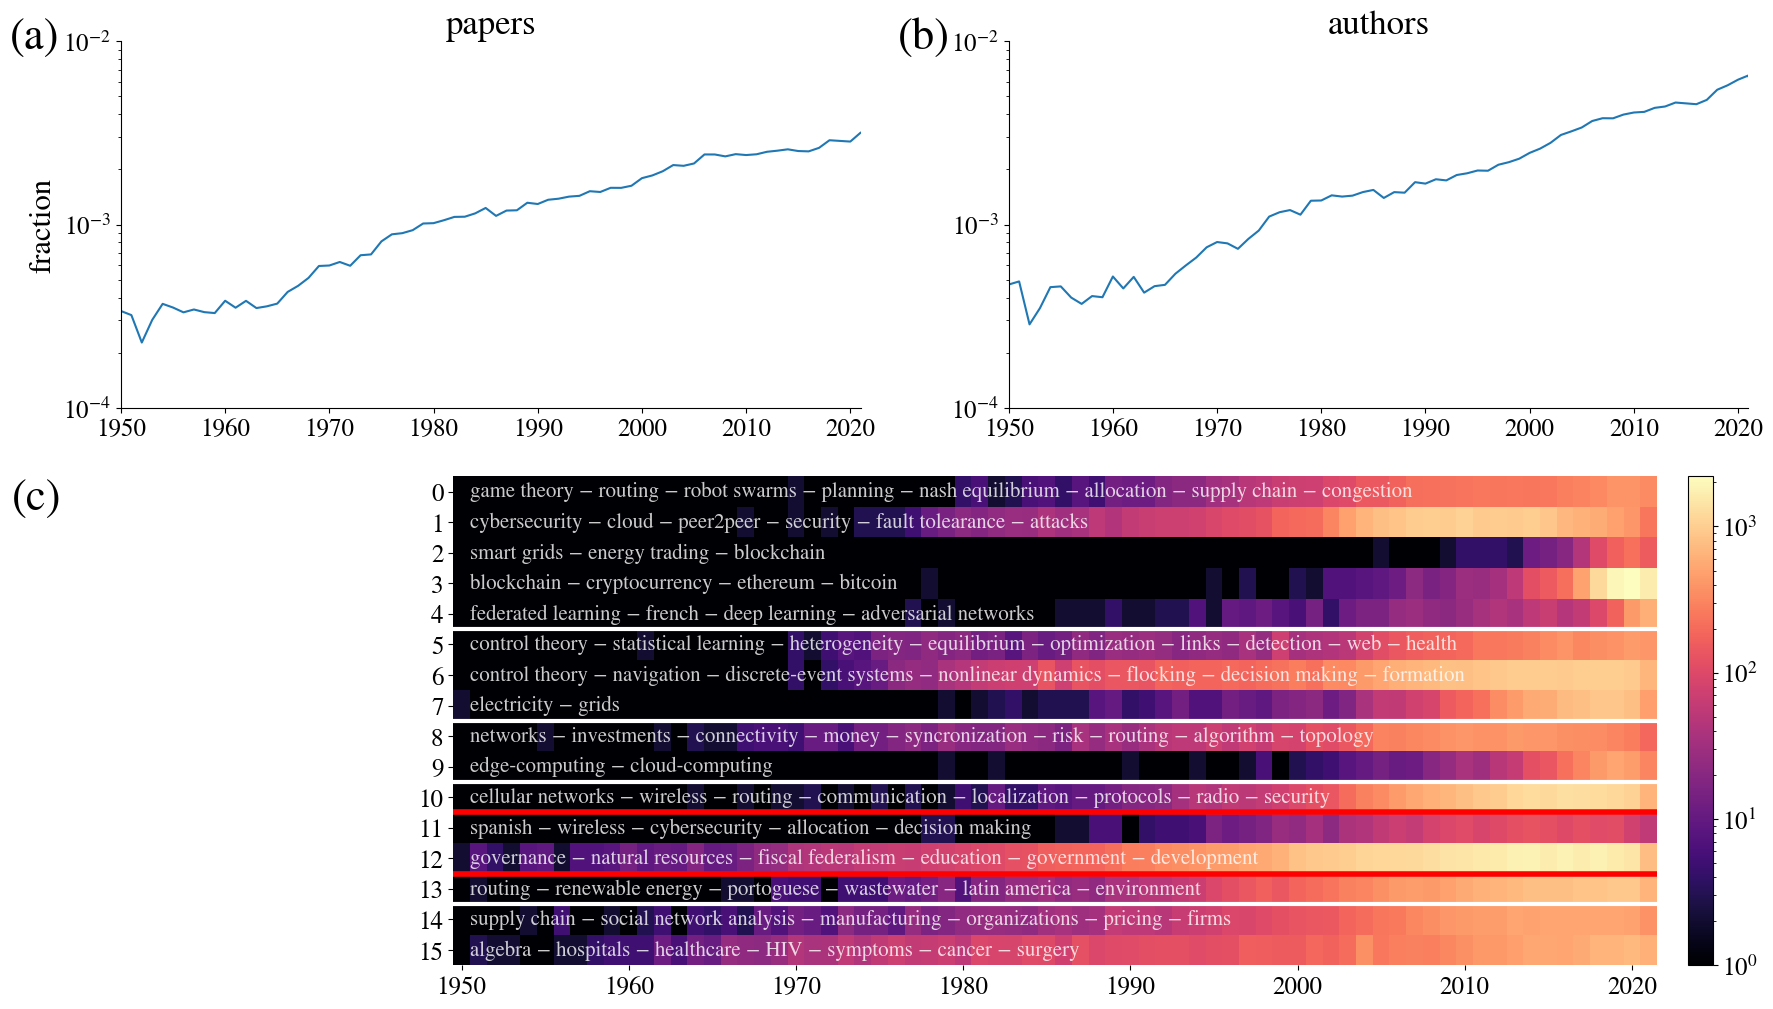

In [122]:
l = 3
year_cluster_log = year_cluster_field_no_papers_df_by_level[l].groupby(["year","cluster"],as_index=False).no_papers.sum()
year_cluster_log["no_papers_log"] = np.log([max(1,_) for _ in year_cluster_log["no_papers"]])

fig = plt.figure(figsize = (21,12))

outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[1.5,2],hspace=0.16)
inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[0],width_ratios=[1,1],wspace=0.2)
ax = plt.Subplot(fig, inner[0])
xlims = (1950,2021)
fs = 32
y_small = .98
x_small = -0.15

upper_limit = 10*10**(-3)


dec_papers = pd.Series([x['year'] if 'year' in x else None for x in all_docs_dict.values()]).explode().value_counts().sort_index()

all_papers = pd.Series(index=years,data=[sum(list(papers_per_year_per_field[x].values())) for x in years])

frac_papers = dec_papers.align(all_papers,fill_value=0)[0]/dec_papers.align(all_papers,fill_value=0)[1]
ax.plot(frac_papers.index,frac_papers.values)#, color = 'red')

ax.set_xlim(xlims)
ax.set_xticks(range(1950,2022,10))
ax.set_yscale("log")
ax.set_ylim((10**(-4),upper_limit))
ax.set_ylabel("fraction")
ax.set_title("papers")

# ax.axvline(2016,linestyle='--',color='grey',lw=2, label='New Growth')
# ax.axvline(1963,linestyle='--',color='green',lw=2, label='Start Growth')
# ax.axvline(2008,linestyle='--',color='black',lw=2, label='Bitcoin whitepaper')# ax.legend()
# ax.legend()

ax.text(s="(a)", y=y_small, fontsize=fs, x = x_small, transform=ax.transAxes)
fig.add_subplot(ax)



ax = plt.Subplot(fig, inner[1])
dec_authors = pd.Series(no_authors_per_year_decentralization).sort_index()
all_authors = pd.Series(no_authors_per_year).sort_index()


frac_authors = dec_authors.align(all_authors,fill_value=0)[0]/dec_authors.align(all_authors,fill_value=0)[1]
ax.plot(frac_authors.index,frac_authors.values)#, color = 'red')

ax.set_xlim(xlims)
ax.set_yscale("log")
ax.set_ylim((10**(-4),upper_limit))
# ax.set_ylabel("fraction")
ax.set_xticks(range(1950,2022,10))
ax.set_title("authors")

ax.text(s="(b)", y=y_small, fontsize=fs, x = x_small, transform=ax.transAxes)
fig.add_subplot(ax)

#########################################################################################################################################

inner = gridspec.GridSpecFromSubplotSpec(1, 3,
                        subplot_spec=outer[1],width_ratios=[5,20,1],wspace=0.06)

level3_pos = [(x,y) for x,y in pos.items() if x.split("_")[0]=="3"]
ordered_lev3_clusters_pos = sorted(level3_pos,key = lambda x:x[1][0])
ordered_lev3_clusters = [int(x[0].split("_")[1].split("\n")[0]) for x in ordered_lev3_clusters_pos]

ordered_hierarchy_lev_4 = []
for c in ordered_lev3_clusters:
    for c3 in hierarchy_docs[4].keys():
        if c in hierarchy_docs[4][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev_4]:
            ordered_hierarchy_lev_4.append((c3,hierarchy_docs[4][c3].intersection(set(ordered_lev3_clusters))))

# ordered_lev3_clusters_filtered = [int(x[0].split("_")[1].split("\n")[0]) for x in ordered_lev3_clusters_pos if len(x[0])>10]
# correct_cluster_number = {x:ordered_lev3_clusters_filtered.index(x) for x in ordered_lev3_clusters_filtered}

ax = plt.Subplot(fig, inner[1])

data = year_cluster_log.copy()

fig, ax = heatmap(df=data, fixed_labels=[], x_label="year", y_label="cluster", values_label="no_papers_log", 
             costrains_equal={"year":set(range(1950,2022))},
             ordered_cluster_labels=ordered_lev3_clusters, ordered_cluster_groups=ordered_hierarchy_lev_4,linewidth=1,
             cut_small_clusters=True,threshold_num_papers=500,
             bottom_level = l, top_level = 6, use_only_first_keyword=False, use_keywords_as_ticks=False,
             ax=ax,fig=fig,do_barplot=False,linelength = 150)
fig.add_subplot(ax)
ax.set_xticks([x+0.5 for x in range(0,2022-1950,10)])
ax.set_xticklabels(range(1950,2022,10),rotation = 0)


ax_cmap = plt.Subplot(fig, inner[2])
vmin = np.e**year_cluster_log.no_papers_log.unique().min()
vmax = year_cluster_log.no_papers.unique().max()
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax), cmap=plt.get_cmap("magma")), ax=ax_cmap,shrink=1,pad=0., fraction=1,orientation="vertical")
ax_cmap.tick_params(labelsize=20) 
ax_cmap.axis('off')
fig.add_subplot(ax_cmap)
fig.text(.073, 0.49, "(c)", fontsize=32, transform=fig.transFigure)

fig.savefig(f"{paper_figures_folder}Figure1_lev{l}.pdf",bbox_inches='tight')
fig.savefig(f"{paper_figures_folder}Figure1_lev{l}.png",bbox_inches='tight')

plt.show()

## Figure results methods SI

Do hierarchy plot to paste into main figure

In [82]:
N = 256
vals = np.ones((N, 3))
val = 100/256
vals[:, 0] = np.linspace(val, val, N)
vals[:, 1] = np.linspace(val, val, N)
vals[:, 2] = np.linspace(val, val, N)
newcmp = ListedColormap(vals)

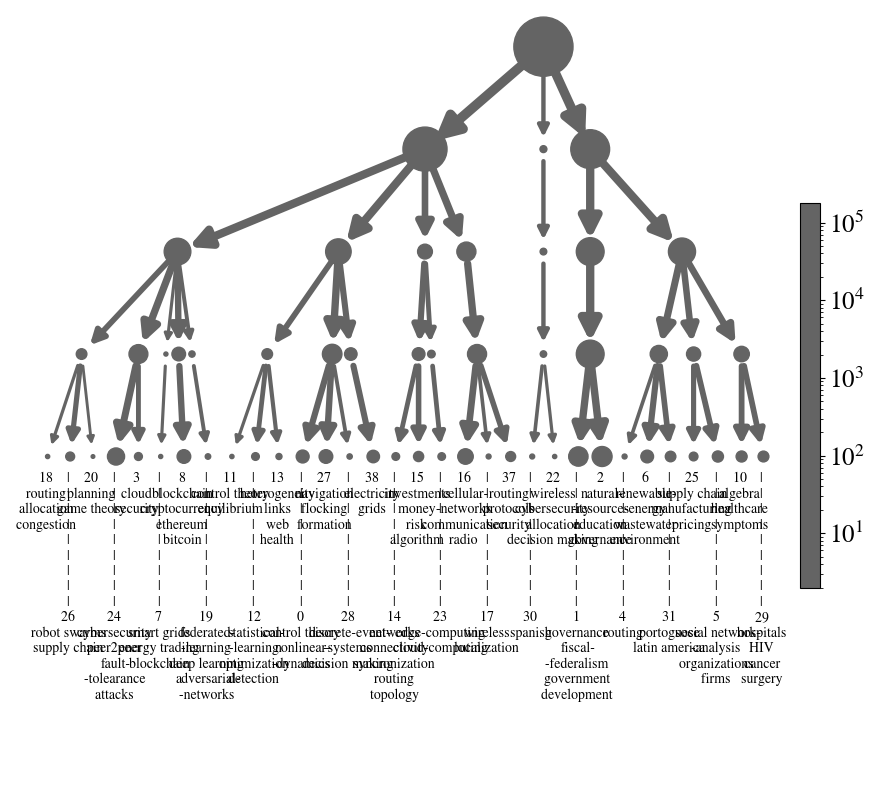

In [83]:
figsize=(12,10)
fig = plt.figure(figsize=figsize)
ax = plt.gca()
# plt.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1)), ax=ax,shrink=0.5,pad=0.,fraction=0.2)
pos = create_hierarchy_network_docs(partition=0, top_level=6, bottom_level=2, 
                             max_num_clusters_to_represent=10000, num_words_to_represent=20, 
                             multiplicator_size_nodes=.01, multiplicator_size_edges=1, multiplicator_ypos=0.30,
                             fontsize = 10, ax=ax, fig=fig, threshold_num_papers = 500, num_spaces=50,cmap = newcmp)# matplotlib.cm.get_cmap('black'))
plt.savefig(paper_figures_folder + "hierarchy_clusters_colorless_for_figureSI_results_methods.pdf")

Do main figure

In [84]:
l = 2
year_cluster_log = year_cluster_field_no_papers_df_by_level[l].groupby(["year","cluster"],as_index=False).no_papers.sum()
year_cluster_log["no_papers_log"] = np.log([max(1,_) for _ in year_cluster_log["no_papers"]])

fig = plt.figure(figsize = (21,9))

outer = gridspec.GridSpec(nrows=1, ncols=3,width_ratios=[7,20,1],wspace=0.06)
##############

# level3_pos = [(x,y) for x,y in pos.items() if x.split("_")[0]=="3"]
# ordered_lev3_clusters_pos = sorted(level3_pos,key = lambda x:x[1][0])
# ordered_lev3_clusters = [int(x[0].split("_")[1].split("\n")[0]) for x in ordered_lev3_clusters_pos]

# ordered_hierarchy_lev_4 = []
# for c in ordered_lev3_clusters:
#     for c3 in hierarchy_docs[4].keys():
#         if c in hierarchy_docs[4][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev_4]:
#             ordered_hierarchy_lev_4.append((c3,hierarchy_docs[4][c3].intersection(set(ordered_lev3_clusters))))

# ordered_lev3_clusters_filtered = [int(x[0].split("_")[1].split("\n")[0]) for x in ordered_lev3_clusters_pos if len(x[0])>10]
# correct_cluster_number = {x:ordered_lev3_clusters_filtered.index(x) for x in ordered_lev3_clusters_filtered}

# ax = plt.Subplot(fig, inner[1])

# data = year_cluster_log.copy()

# fig, ax = heatmap(df=data, fixed_labels=[], x_label="year", y_label="cluster", values_label="no_papers_log", 
#              costrains_equal={"year":set(range(1950,2022))},#figsize=(21,14),
#              ordered_cluster_labels=ordered_lev3_clusters, ordered_cluster_groups=ordered_hierarchy_lev_4,linewidth=1,
#              cut_small_clusters=True,threshold_num_papers=500,#500
#              bottom_level = l, top_level = 6,
#              ax=ax,fig=fig,do_barplot=False,linelength = 150)




#######################


level2_pos = [(x,y) for x,y in pos.items() if x.split("_")[0]=="2"]
ordered_lev2_clusters_pos = sorted(level2_pos,key = lambda x:x[1][0])
ordered_lev2_clusters = [int(x[0].split("_")[1].split("\n")[0]) for x in ordered_lev2_clusters_pos]


ordered_hierarchy_lev_3 = []
for c in ordered_lev2_clusters:
    for c3 in hierarchy_docs[l+1].keys():
        if c in hierarchy_docs[l+1][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev_3]:
            ordered_hierarchy_lev_3.append((c3,hierarchy_docs[l+1][c3].intersection(set(ordered_lev2_clusters))))

# ordered_lev2_clusters_filtered = [int(x[0].split("_")[1].split("\n")[0]) for x in ordered_lev2_clusters_pos if len(x[0])>10]
# correct_cluster_number = {x:ordered_lev3_clusters_filtered.index(x) for x in ordered_lev3_clusters_filtered}

ax = plt.Subplot(fig, outer[1])

data = year_cluster_log.copy()

fig, ax = heatmap(df=data, fixed_labels=[], x_label="year", y_label="cluster", values_label="no_papers_log", 
             costrains_equal={"year":set(range(1950,2022))},
             ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=1,
             cut_small_clusters=True,threshold_num_papers=500,
             bottom_level = l, top_level = 6, use_only_first_keyword=True, use_keywords_as_ticks=True,
             ax=ax,fig=fig,do_barplot=False,linelength = 150)
fig.add_subplot(ax)
ax.set_xticks([x+0.5 for x in range(0,2022-1950,10)])
ax.set_xticklabels(range(1950,2022,10),rotation = 0)


ax_cmap = plt.Subplot(fig, outer[2])
vmin = np.e**year_cluster_log.no_papers_log.unique().min()
vmax = year_cluster_log.no_papers.unique().max()
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax), cmap=plt.get_cmap("magma")), ax=ax_cmap,shrink=1,pad=0., fraction=1,orientation="vertical")
ax_cmap.tick_params(labelsize=20) 
ax_cmap.axis('off')
fig.add_subplot(ax_cmap)
fig.text(.0, 0.49, "(a)", fontsize=32, color="white",transform=fig.transFigure)

fig.savefig(f"{paper_figures_folder}FigureSI_results_methods_lev{l}.pdf",bbox_inches='tight')
fig.savefig(f"{paper_figures_folder}FigureSI_results_methods_lev{l}.png",bbox_inches='tight')

plt.show()

NameError: name 'year_cluster_field_no_papers_df_by_level' is not defined

# Figure 2

/tmp/2207198.1.all.q/ipykernel_4977/2155359734.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


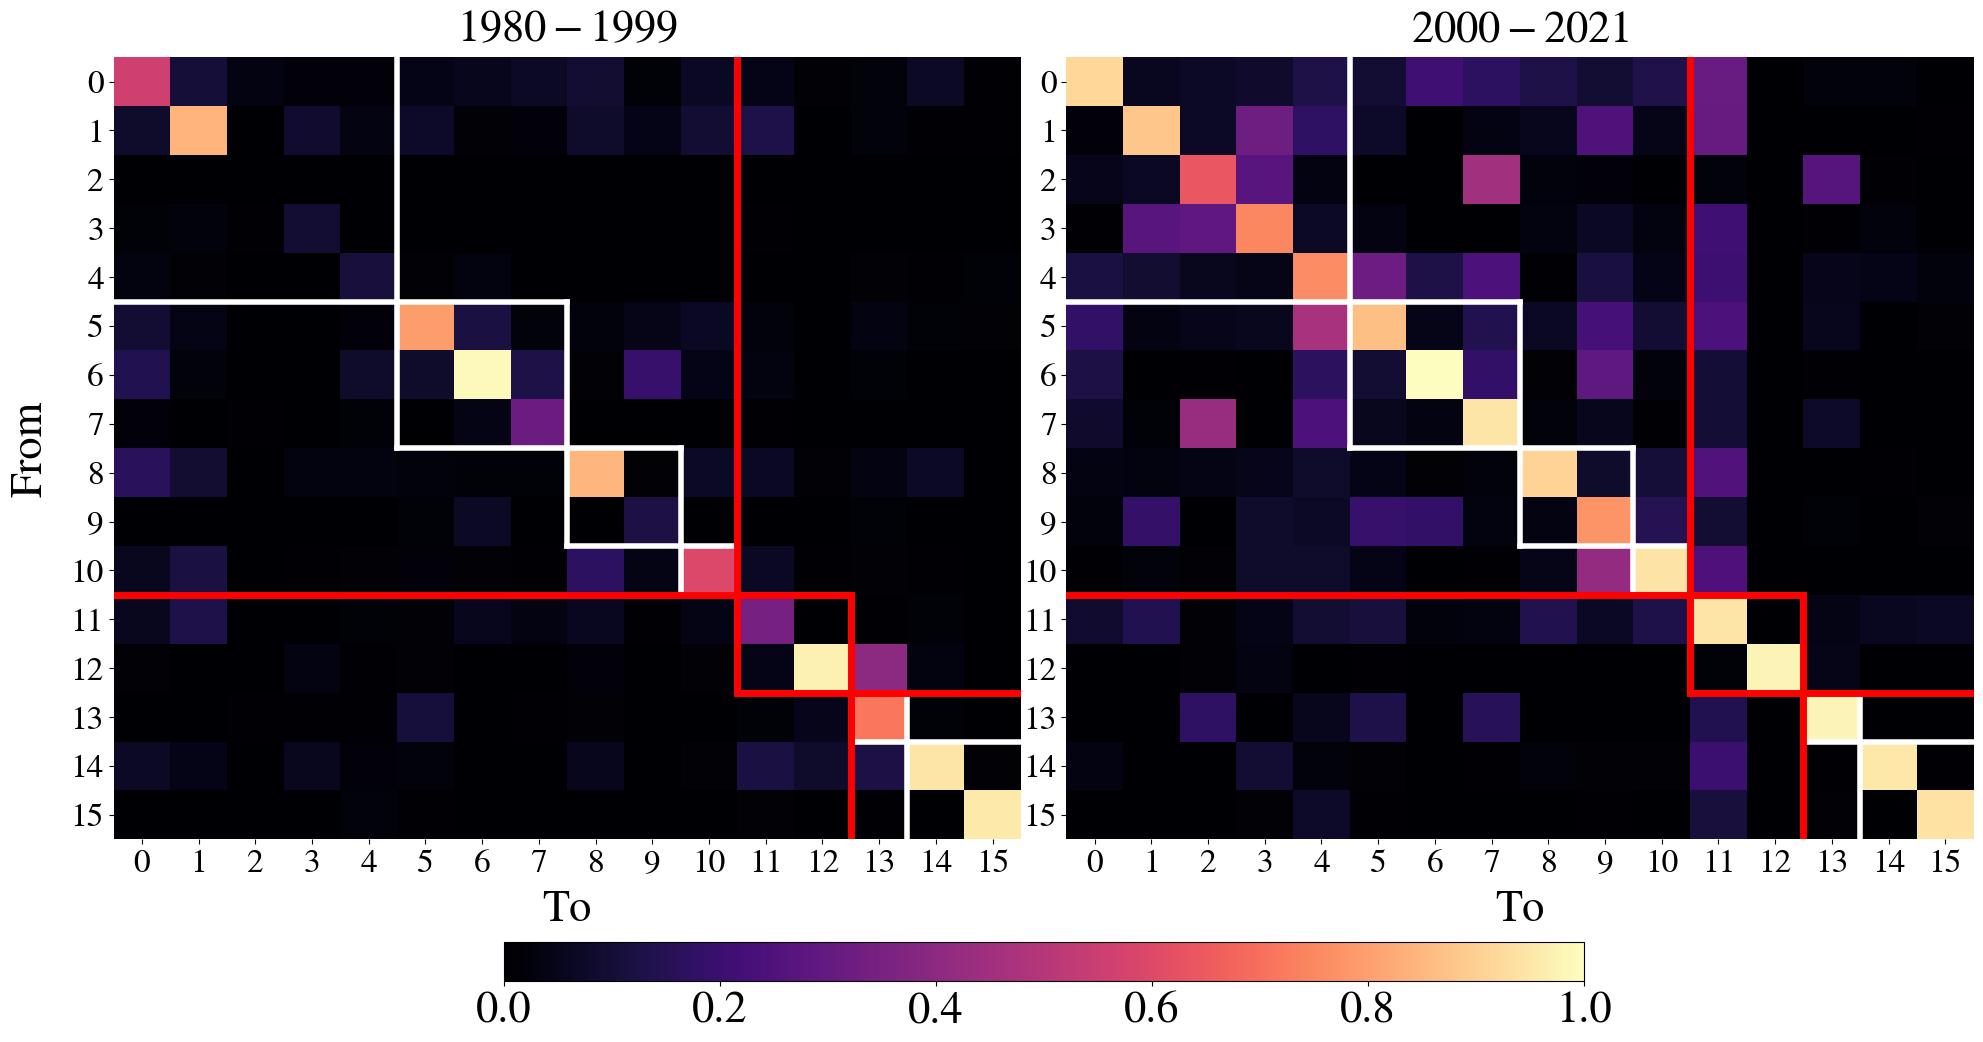

In [129]:
# TODO do also at level 3!

l = 3
fig = plt.figure(figsize=(24,12))
outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[20,1],hspace=0.25)
inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[0],wspace=0.05,hspace=0.12,)

# for i,(year_from,year_to) in enumerate([(1951,1971),(1971,1991),(1991,2011),(2011,2022)]):
for i,(year_from,year_to) in enumerate([(1980,2000),(2000,2022)]):
# for i,(year_from,year_to) in enumerate([(2011,2022)]):
    ax = plt.Subplot(fig, inner[i]) # axes[i//2,i%2]
#     x = tmp_future.copy()
#     x.knowledge_flow = x.knowledge_flow.apply(lambda t:t if t<5 else 5)
#     x = x.loc[tmp_future.year_from.isin(range(year_from,year_to))].groupby(["cluster_from","cluster_to"],as_index=False).knowledge_flow.mean()
#     fig,ax = heatmap(df=x, fixed_labels=[], x_label="cluster_from", y_label="cluster_to", values_label="knowledge_flow", 
#             costrains_equal={},figsize=(21,20),
#                  filename="",
#                  ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=2,
#                  cut_small_clusters=True,threshold_num_papers=500,do_barplot=False,
#                  fig=fig,ax=ax)
#     ax.set_title("%d to %d"%(year_from,year_to),y=1.01,fontsize=32)
#     fig.add_subplot(ax)
    
#     tmp = knowledge_flow_normalized_per_field_in_time_by_level[l].copy()
#     tmp['significant_kf'] = tmp.knowledge_flow >= 1
#     tmp = tmp.loc[tmp.year_from.isin(range(year_from,year_to))]
#     tmp = tmp.loc[tmp.year_to.isin(range(year_from,year_to))]
#     tmp = tmp.groupby(["cluster_from","cluster_to","year_from"],as_index=False).significant_kf.mean()
#     tmp = tmp.groupby(["cluster_from","cluster_to"],as_index=False).significant_kf.mean()
    
    
    tmp = knowledge_flow_normalized_per_field_in_time_to_future_by_level[l].copy()
    tmp = tmp.loc[tmp.year_from.isin(range(year_from,year_to))]
    tmp = tmp.groupby(["cluster_from","cluster_to"],as_index=False).significant_kf.mean()
    
    
    couples = set([tuple(x) for x in tmp[['cluster_from','cluster_to']].values])
    for cluster_f in keywords_clusters[l].keys():
        for cluster_t in keywords_clusters[l].keys():
            if (cluster_f,cluster_t) not in couples:
                tmp.loc[len(tmp)] = [cluster_f,cluster_t,0]
            
    level3_pos = [(x,y) for x,y in pos.items() if x.split("_")[0]=="3"]
    ordered_lev3_clusters_pos = sorted(level3_pos,key = lambda x:x[1][0])
    ordered_lev3_clusters = [int(x[0].split("_")[1].split("\n")[0]) for x in ordered_lev3_clusters_pos]

    ordered_hierarchy_lev_4 = []
    for c in ordered_lev3_clusters:
        for c3 in hierarchy_docs[4].keys():
            if c in hierarchy_docs[4][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev_4]:
                ordered_hierarchy_lev_4.append((c3,hierarchy_docs[4][c3].intersection(set(ordered_lev3_clusters))))
            
    fig,ax = heatmap(df=tmp, fixed_labels=[], x_label="cluster_to", y_label="cluster_from", values_label="significant_kf", 
            costrains_equal={},figsize=(21,18),
                 filename=paper_figures_folder + f"cluster_analysis/heatmaps/heatmap_knowledge_flow_between_clusters_{l}_new.pdf",
                 ordered_cluster_labels=ordered_lev3_clusters, ordered_cluster_groups=ordered_hierarchy_lev_4,linewidth=2,
                 cut_small_clusters=True,threshold_num_papers=500,do_barplot=False,fig=fig,ax=ax, vmax=1,
                 bottom_level=3,top_level=6)
    
    ax.set_title("$%d - %d$"%(year_from,year_to-1),y=1.01,fontsize=32)
    fig.add_subplot(ax)
    ax.set_xlabel("To",fontsize=32,labelpad = 8)
    if i==0:
        ax.set_ylabel("From",fontsize=32,labelpad = 14)
    ax.tick_params(labelsize=24) 

inner = gridspec.GridSpecFromSubplotSpec(1, 3, width_ratios = [1,3,1],
                        subplot_spec=outer[1],wspace=0.05,hspace=0.12,)

ax_cmap = plt.Subplot(fig, inner[1])
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="horizontal")
ax_cmap.tick_params(labelsize=32) 
fig.add_subplot(ax_cmap)

fig.savefig(f"{paper_figures_folder}Figure3_lev{l}.pdf")

## Figure 2 - 3 plots

/tmp/2207198.1.all.q/ipykernel_4977/2155359734.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/2207198.1.all.q/ipykernel_4977/2155359734.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


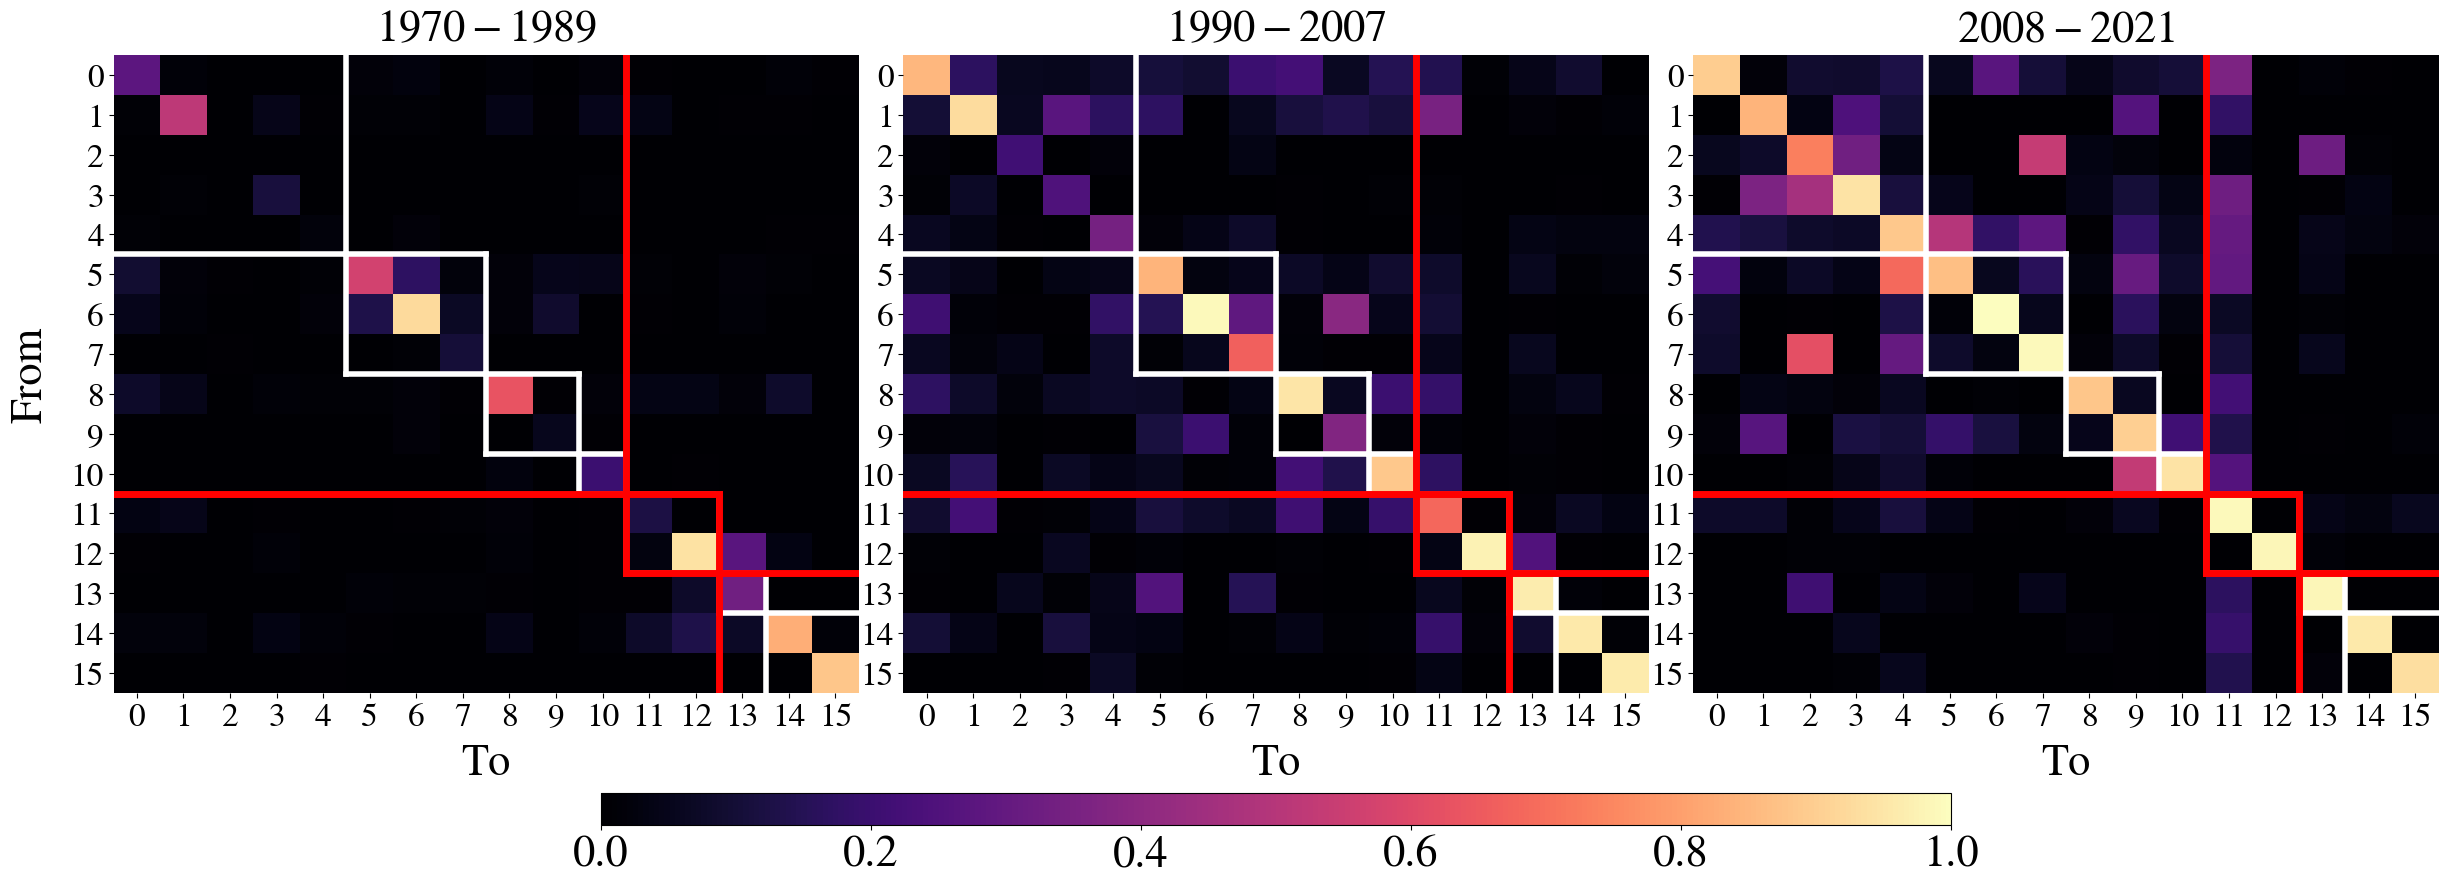

In [130]:
# TODO do also at level 3!

l = 3
fig = plt.figure(figsize=(30,10))
outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[20,1],hspace=0.3)
inner = gridspec.GridSpecFromSubplotSpec(1, 3,
                        subplot_spec=outer[0],wspace=0.06,hspace=0.12,)

# for i,(year_from,year_to) in enumerate([(1951,1971),(1971,1991),(1991,2011),(2011,2022)]):
for i,(year_from,year_to) in enumerate([(1970,1990),(1990,2008),(2008,2022)]):
# for i,(year_from,year_to) in enumerate([(2011,2022)]):
    ax = plt.Subplot(fig, inner[i]) # axes[i//2,i%2]
#     x = tmp_future.copy()
#     x.knowledge_flow = x.knowledge_flow.apply(lambda t:t if t<5 else 5)
#     x = x.loc[tmp_future.year_from.isin(range(year_from,year_to))].groupby(["cluster_from","cluster_to"],as_index=False).knowledge_flow.mean()
#     fig,ax = heatmap(df=x, fixed_labels=[], x_label="cluster_from", y_label="cluster_to", values_label="knowledge_flow", 
#             costrains_equal={},figsize=(21,20),
#                  filename="",
#                  ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=2,
#                  cut_small_clusters=True,threshold_num_papers=500,do_barplot=False,
#                  fig=fig,ax=ax)
#     ax.set_title("%d to %d"%(year_from,year_to),y=1.01,fontsize=32)
#     fig.add_subplot(ax)
    
#     tmp = knowledge_flow_normalized_per_field_in_time_by_level[l].copy()
#     tmp['significant_kf'] = tmp.knowledge_flow >= 1
#     tmp = tmp.loc[tmp.year_from.isin(range(year_from,year_to))]
#     tmp = tmp.loc[tmp.year_to.isin(range(year_from,year_to))]
#     tmp = tmp.groupby(["cluster_from","cluster_to","year_from"],as_index=False).significant_kf.mean()
#     tmp = tmp.groupby(["cluster_from","cluster_to"],as_index=False).significant_kf.mean()
    
    
    tmp = knowledge_flow_normalized_per_field_in_time_to_future_by_level[l].copy()
    tmp = tmp.loc[tmp.year_from.isin(range(year_from,year_to))]
    tmp = tmp.groupby(["cluster_from","cluster_to"],as_index=False).significant_kf.mean()
    
    
    couples = set([tuple(x) for x in tmp[['cluster_from','cluster_to']].values])
    for cluster_f in keywords_clusters[l].keys():
        for cluster_t in keywords_clusters[l].keys():
            if (cluster_f,cluster_t) not in couples:
                tmp.loc[len(tmp)] = [cluster_f,cluster_t,0]
            
    level3_pos = [(x,y) for x,y in pos.items() if x.split("_")[0]=="3"]
    ordered_lev3_clusters_pos = sorted(level3_pos,key = lambda x:x[1][0])
    ordered_lev3_clusters = [int(x[0].split("_")[1].split("\n")[0]) for x in ordered_lev3_clusters_pos]

    ordered_hierarchy_lev_4 = []
    for c in ordered_lev3_clusters:
        for c3 in hierarchy_docs[4].keys():
            if c in hierarchy_docs[4][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev_4]:
                ordered_hierarchy_lev_4.append((c3,hierarchy_docs[4][c3].intersection(set(ordered_lev3_clusters))))
            
    fig,ax = heatmap(df=tmp, fixed_labels=[], x_label="cluster_to", y_label="cluster_from", values_label="significant_kf", 
            costrains_equal={},figsize=(21,18),
                 filename=paper_figures_folder + f"cluster_analysis/heatmaps/heatmap_knowledge_flow_between_clusters_{l}_new.pdf",
                 ordered_cluster_labels=ordered_lev3_clusters, ordered_cluster_groups=ordered_hierarchy_lev_4,linewidth=2,
                 cut_small_clusters=True,threshold_num_papers=500,do_barplot=False,fig=fig,ax=ax, vmax=1,
                 bottom_level=3,top_level=6)
    
    ax.set_title("$%d - %d$"%(year_from,year_to-1),y=1.01,fontsize=32)
    fig.add_subplot(ax)
    ax.set_xlabel("To",fontsize=32,labelpad = 8)
    if i==0:
        ax.set_ylabel("From",fontsize=32,labelpad = 14)
    ax.tick_params(labelsize=24) 

inner = gridspec.GridSpecFromSubplotSpec(1, 3, width_ratios = [1,3,1],
                        subplot_spec=outer[1],wspace=0.05,hspace=0.12,)

ax_cmap = plt.Subplot(fig, inner[1])
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="horizontal")
ax_cmap.tick_params(labelsize=32) 
fig.add_subplot(ax_cmap)

fig.savefig(f"{paper_figures_folder}Figure3_lev{l}bis.pdf")

/tmp/2207198.1.all.q/ipykernel_4977/2155359734.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/2207198.1.all.q/ipykernel_4977/2155359734.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


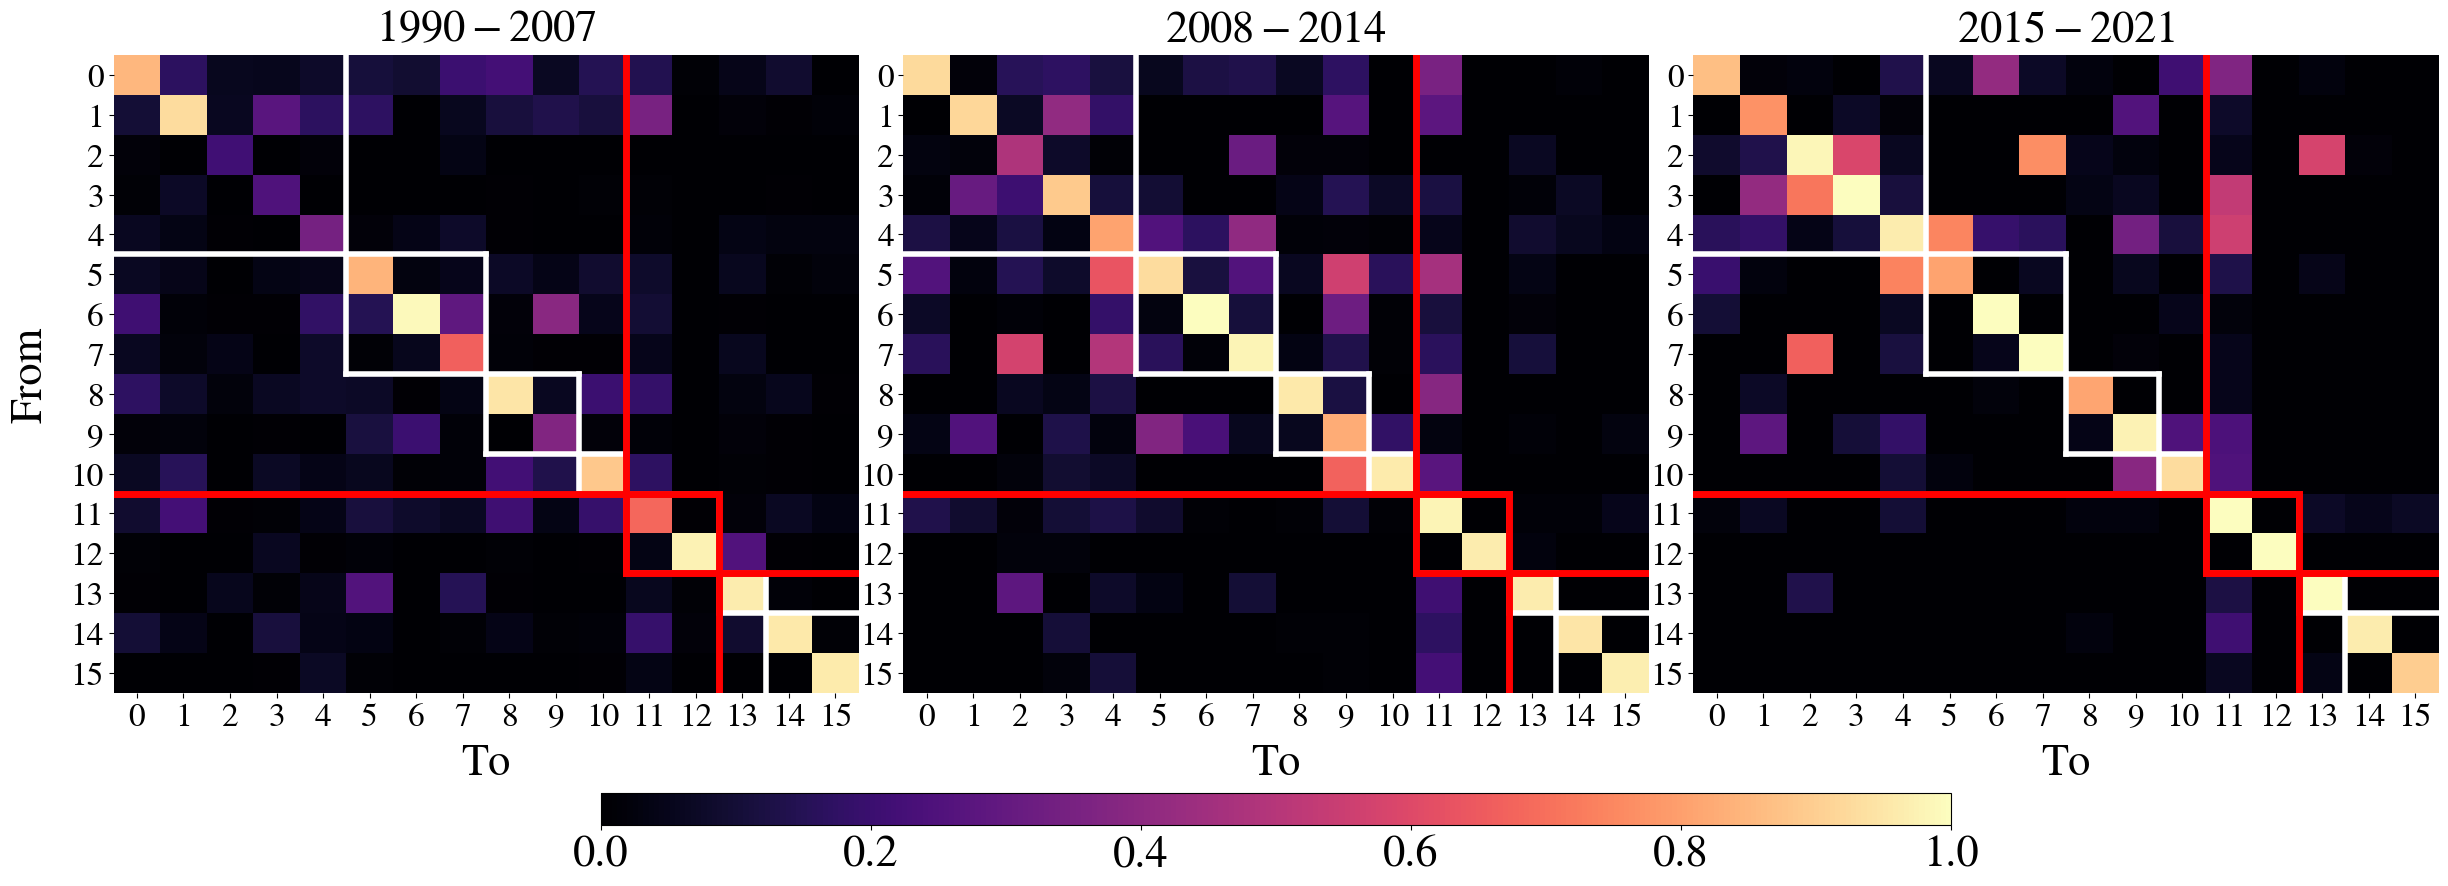

In [131]:
# TODO do also at level 3!

l = 3
fig = plt.figure(figsize=(30,10))
outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[20,1],hspace=0.3)
inner = gridspec.GridSpecFromSubplotSpec(1, 3,
                        subplot_spec=outer[0],wspace=0.06,hspace=0.12,)

# for i,(year_from,year_to) in enumerate([(1951,1971),(1971,1991),(1991,2011),(2011,2022)]):
for i,(year_from,year_to) in enumerate([(1990,2008),(2008,2015),(2015,2022)]):
# for i,(year_from,year_to) in enumerate([(2011,2022)]):
    ax = plt.Subplot(fig, inner[i]) # axes[i//2,i%2]
#     x = tmp_future.copy()
#     x.knowledge_flow = x.knowledge_flow.apply(lambda t:t if t<5 else 5)
#     x = x.loc[tmp_future.year_from.isin(range(year_from,year_to))].groupby(["cluster_from","cluster_to"],as_index=False).knowledge_flow.mean()
#     fig,ax = heatmap(df=x, fixed_labels=[], x_label="cluster_from", y_label="cluster_to", values_label="knowledge_flow", 
#             costrains_equal={},figsize=(21,20),
#                  filename="",
#                  ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=2,
#                  cut_small_clusters=True,threshold_num_papers=500,do_barplot=False,
#                  fig=fig,ax=ax)
#     ax.set_title("%d to %d"%(year_from,year_to),y=1.01,fontsize=32)
#     fig.add_subplot(ax)
    
#     tmp = knowledge_flow_normalized_per_field_in_time_by_level[l].copy()
#     tmp['significant_kf'] = tmp.knowledge_flow >= 1
#     tmp = tmp.loc[tmp.year_from.isin(range(year_from,year_to))]
#     tmp = tmp.loc[tmp.year_to.isin(range(year_from,year_to))]
#     tmp = tmp.groupby(["cluster_from","cluster_to","year_from"],as_index=False).significant_kf.mean()
#     tmp = tmp.groupby(["cluster_from","cluster_to"],as_index=False).significant_kf.mean()
    
    
    tmp = knowledge_flow_normalized_per_field_in_time_to_future_by_level[l].copy()
    tmp = tmp.loc[tmp.year_from.isin(range(year_from,year_to))]
    tmp = tmp.groupby(["cluster_from","cluster_to"],as_index=False).significant_kf.mean()
    
    
    couples = set([tuple(x) for x in tmp[['cluster_from','cluster_to']].values])
    for cluster_f in keywords_clusters[l].keys():
        for cluster_t in keywords_clusters[l].keys():
            if (cluster_f,cluster_t) not in couples:
                tmp.loc[len(tmp)] = [cluster_f,cluster_t,0]
            
    level3_pos = [(x,y) for x,y in pos.items() if x.split("_")[0]=="3"]
    ordered_lev3_clusters_pos = sorted(level3_pos,key = lambda x:x[1][0])
    ordered_lev3_clusters = [int(x[0].split("_")[1].split("\n")[0]) for x in ordered_lev3_clusters_pos]

    ordered_hierarchy_lev_4 = []
    for c in ordered_lev3_clusters:
        for c3 in hierarchy_docs[4].keys():
            if c in hierarchy_docs[4][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev_4]:
                ordered_hierarchy_lev_4.append((c3,hierarchy_docs[4][c3].intersection(set(ordered_lev3_clusters))))
            
    fig,ax = heatmap(df=tmp, fixed_labels=[], x_label="cluster_to", y_label="cluster_from", values_label="significant_kf", 
            costrains_equal={},figsize=(21,18),
                 filename=paper_figures_folder + f"cluster_analysis/heatmaps/heatmap_knowledge_flow_between_clusters_{l}_new.pdf",
                 ordered_cluster_labels=ordered_lev3_clusters, ordered_cluster_groups=ordered_hierarchy_lev_4,linewidth=2,
                 cut_small_clusters=True,threshold_num_papers=500,do_barplot=False,fig=fig,ax=ax, vmax=1,
                 bottom_level=3,top_level=6)
    
    ax.set_title("$%d - %d$"%(year_from,year_to-1),y=1.01,fontsize=32)
    fig.add_subplot(ax)
    ax.set_xlabel("To",fontsize=32,labelpad = 8)
    if i==0:
        ax.set_ylabel("From",fontsize=32,labelpad = 14)
    ax.tick_params(labelsize=24) 

inner = gridspec.GridSpecFromSubplotSpec(1, 3, width_ratios = [1,3,1],
                        subplot_spec=outer[1],wspace=0.05,hspace=0.12,)

ax_cmap = plt.Subplot(fig, inner[1])
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="horizontal")
ax_cmap.tick_params(labelsize=32) 
fig.add_subplot(ax_cmap)

fig.savefig(f"{paper_figures_folder}Figure3_lev{l}bis2.pdf")

/tmp/2207198.1.all.q/ipykernel_4977/2155359734.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/2207198.1.all.q/ipykernel_4977/2155359734.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


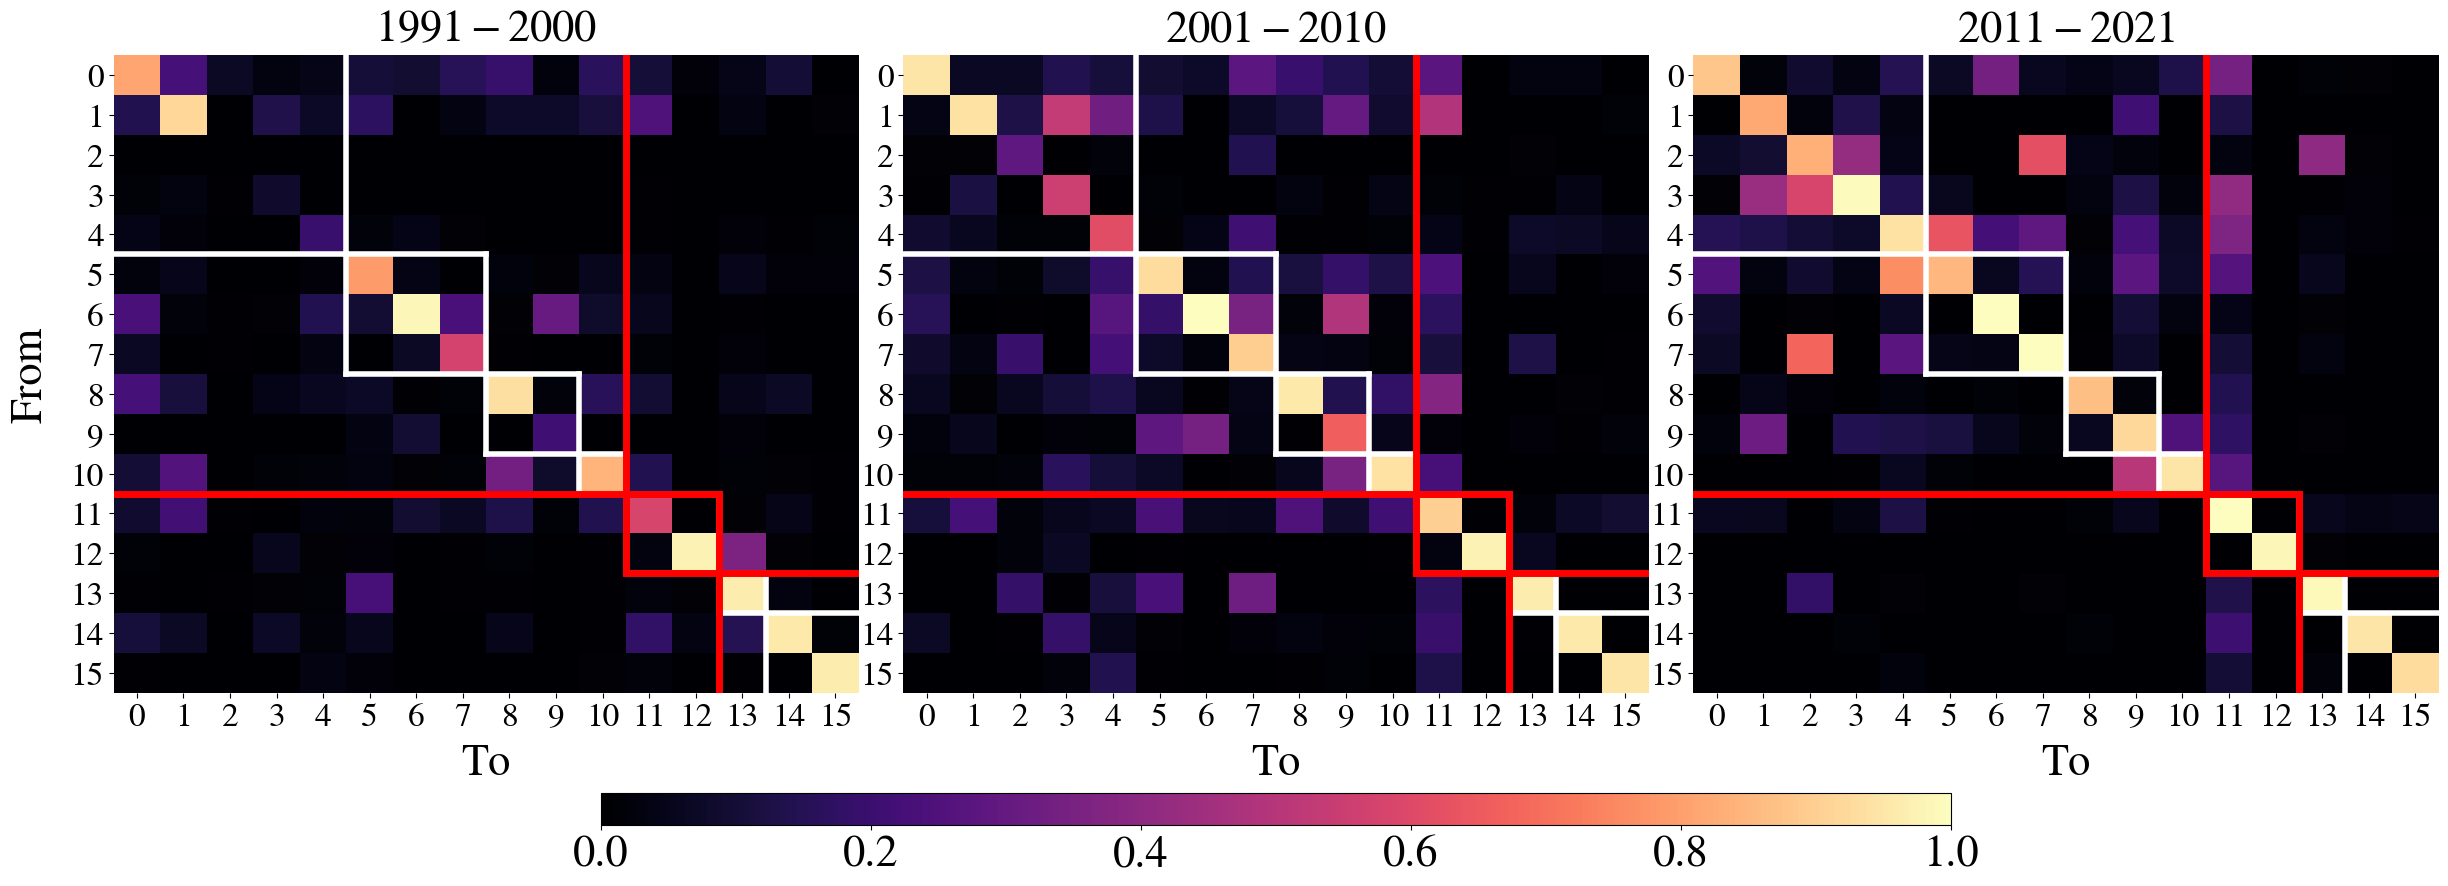

In [132]:
# TODO do also at level 3!

l = 3
fig = plt.figure(figsize=(30,10))
outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[20,1],hspace=0.3)
inner = gridspec.GridSpecFromSubplotSpec(1, 3,
                        subplot_spec=outer[0],wspace=0.06,hspace=0.12,)

# for i,(year_from,year_to) in enumerate([(1951,1971),(1971,1991),(1991,2011),(2011,2022)]):
for i,(year_from,year_to) in enumerate([(1991,2001),(2001,2011),(2011,2022)]):
# for i,(year_from,year_to) in enumerate([(2011,2022)]):
    ax = plt.Subplot(fig, inner[i]) # axes[i//2,i%2]
#     x = tmp_future.copy()
#     x.knowledge_flow = x.knowledge_flow.apply(lambda t:t if t<5 else 5)
#     x = x.loc[tmp_future.year_from.isin(range(year_from,year_to))].groupby(["cluster_from","cluster_to"],as_index=False).knowledge_flow.mean()
#     fig,ax = heatmap(df=x, fixed_labels=[], x_label="cluster_from", y_label="cluster_to", values_label="knowledge_flow", 
#             costrains_equal={},figsize=(21,20),
#                  filename="",
#                  ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=2,
#                  cut_small_clusters=True,threshold_num_papers=500,do_barplot=False,
#                  fig=fig,ax=ax)
#     ax.set_title("%d to %d"%(year_from,year_to),y=1.01,fontsize=32)
#     fig.add_subplot(ax)
    
#     tmp = knowledge_flow_normalized_per_field_in_time_by_level[l].copy()
#     tmp['significant_kf'] = tmp.knowledge_flow >= 1
#     tmp = tmp.loc[tmp.year_from.isin(range(year_from,year_to))]
#     tmp = tmp.loc[tmp.year_to.isin(range(year_from,year_to))]
#     tmp = tmp.groupby(["cluster_from","cluster_to","year_from"],as_index=False).significant_kf.mean()
#     tmp = tmp.groupby(["cluster_from","cluster_to"],as_index=False).significant_kf.mean()
    
    
    tmp = knowledge_flow_normalized_per_field_in_time_to_future_by_level[l].copy()
    tmp = tmp.loc[tmp.year_from.isin(range(year_from,year_to))]
    tmp = tmp.groupby(["cluster_from","cluster_to"],as_index=False).significant_kf.mean()
    
    
    couples = set([tuple(x) for x in tmp[['cluster_from','cluster_to']].values])
    for cluster_f in keywords_clusters[l].keys():
        for cluster_t in keywords_clusters[l].keys():
            if (cluster_f,cluster_t) not in couples:
                tmp.loc[len(tmp)] = [cluster_f,cluster_t,0]
            
    level3_pos = [(x,y) for x,y in pos.items() if x.split("_")[0]=="3"]
    ordered_lev3_clusters_pos = sorted(level3_pos,key = lambda x:x[1][0])
    ordered_lev3_clusters = [int(x[0].split("_")[1].split("\n")[0]) for x in ordered_lev3_clusters_pos]

    ordered_hierarchy_lev_4 = []
    for c in ordered_lev3_clusters:
        for c3 in hierarchy_docs[4].keys():
            if c in hierarchy_docs[4][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev_4]:
                ordered_hierarchy_lev_4.append((c3,hierarchy_docs[4][c3].intersection(set(ordered_lev3_clusters))))
            
    fig,ax = heatmap(df=tmp, fixed_labels=[], x_label="cluster_to", y_label="cluster_from", values_label="significant_kf", 
            costrains_equal={},figsize=(21,18),
                 filename=paper_figures_folder + f"cluster_analysis/heatmaps/heatmap_knowledge_flow_between_clusters_{l}_new.pdf",
                 ordered_cluster_labels=ordered_lev3_clusters, ordered_cluster_groups=ordered_hierarchy_lev_4,linewidth=2,
                 cut_small_clusters=True,threshold_num_papers=500,do_barplot=False,fig=fig,ax=ax, vmax=1,
                 bottom_level=3,top_level=6)
    
    ax.set_title("$%d - %d$"%(year_from,year_to-1),y=1.01,fontsize=32)
    fig.add_subplot(ax)
    ax.set_xlabel("To",fontsize=32,labelpad = 8)
    if i==0:
        ax.set_ylabel("From",fontsize=32,labelpad = 14)
    ax.tick_params(labelsize=24) 

inner = gridspec.GridSpecFromSubplotSpec(1, 3, width_ratios = [1,3,1],
                        subplot_spec=outer[1],wspace=0.05,hspace=0.12,)

ax_cmap = plt.Subplot(fig, inner[1])
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="horizontal")
ax_cmap.tick_params(labelsize=32) 
fig.add_subplot(ax_cmap)

fig.savefig(f"{paper_figures_folder}Figure3_lev{l}bis3.pdf")

## Other versions

At level 2, time windows of 20 years

/tmp/2207198.1.all.q/ipykernel_4977/2155359734.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


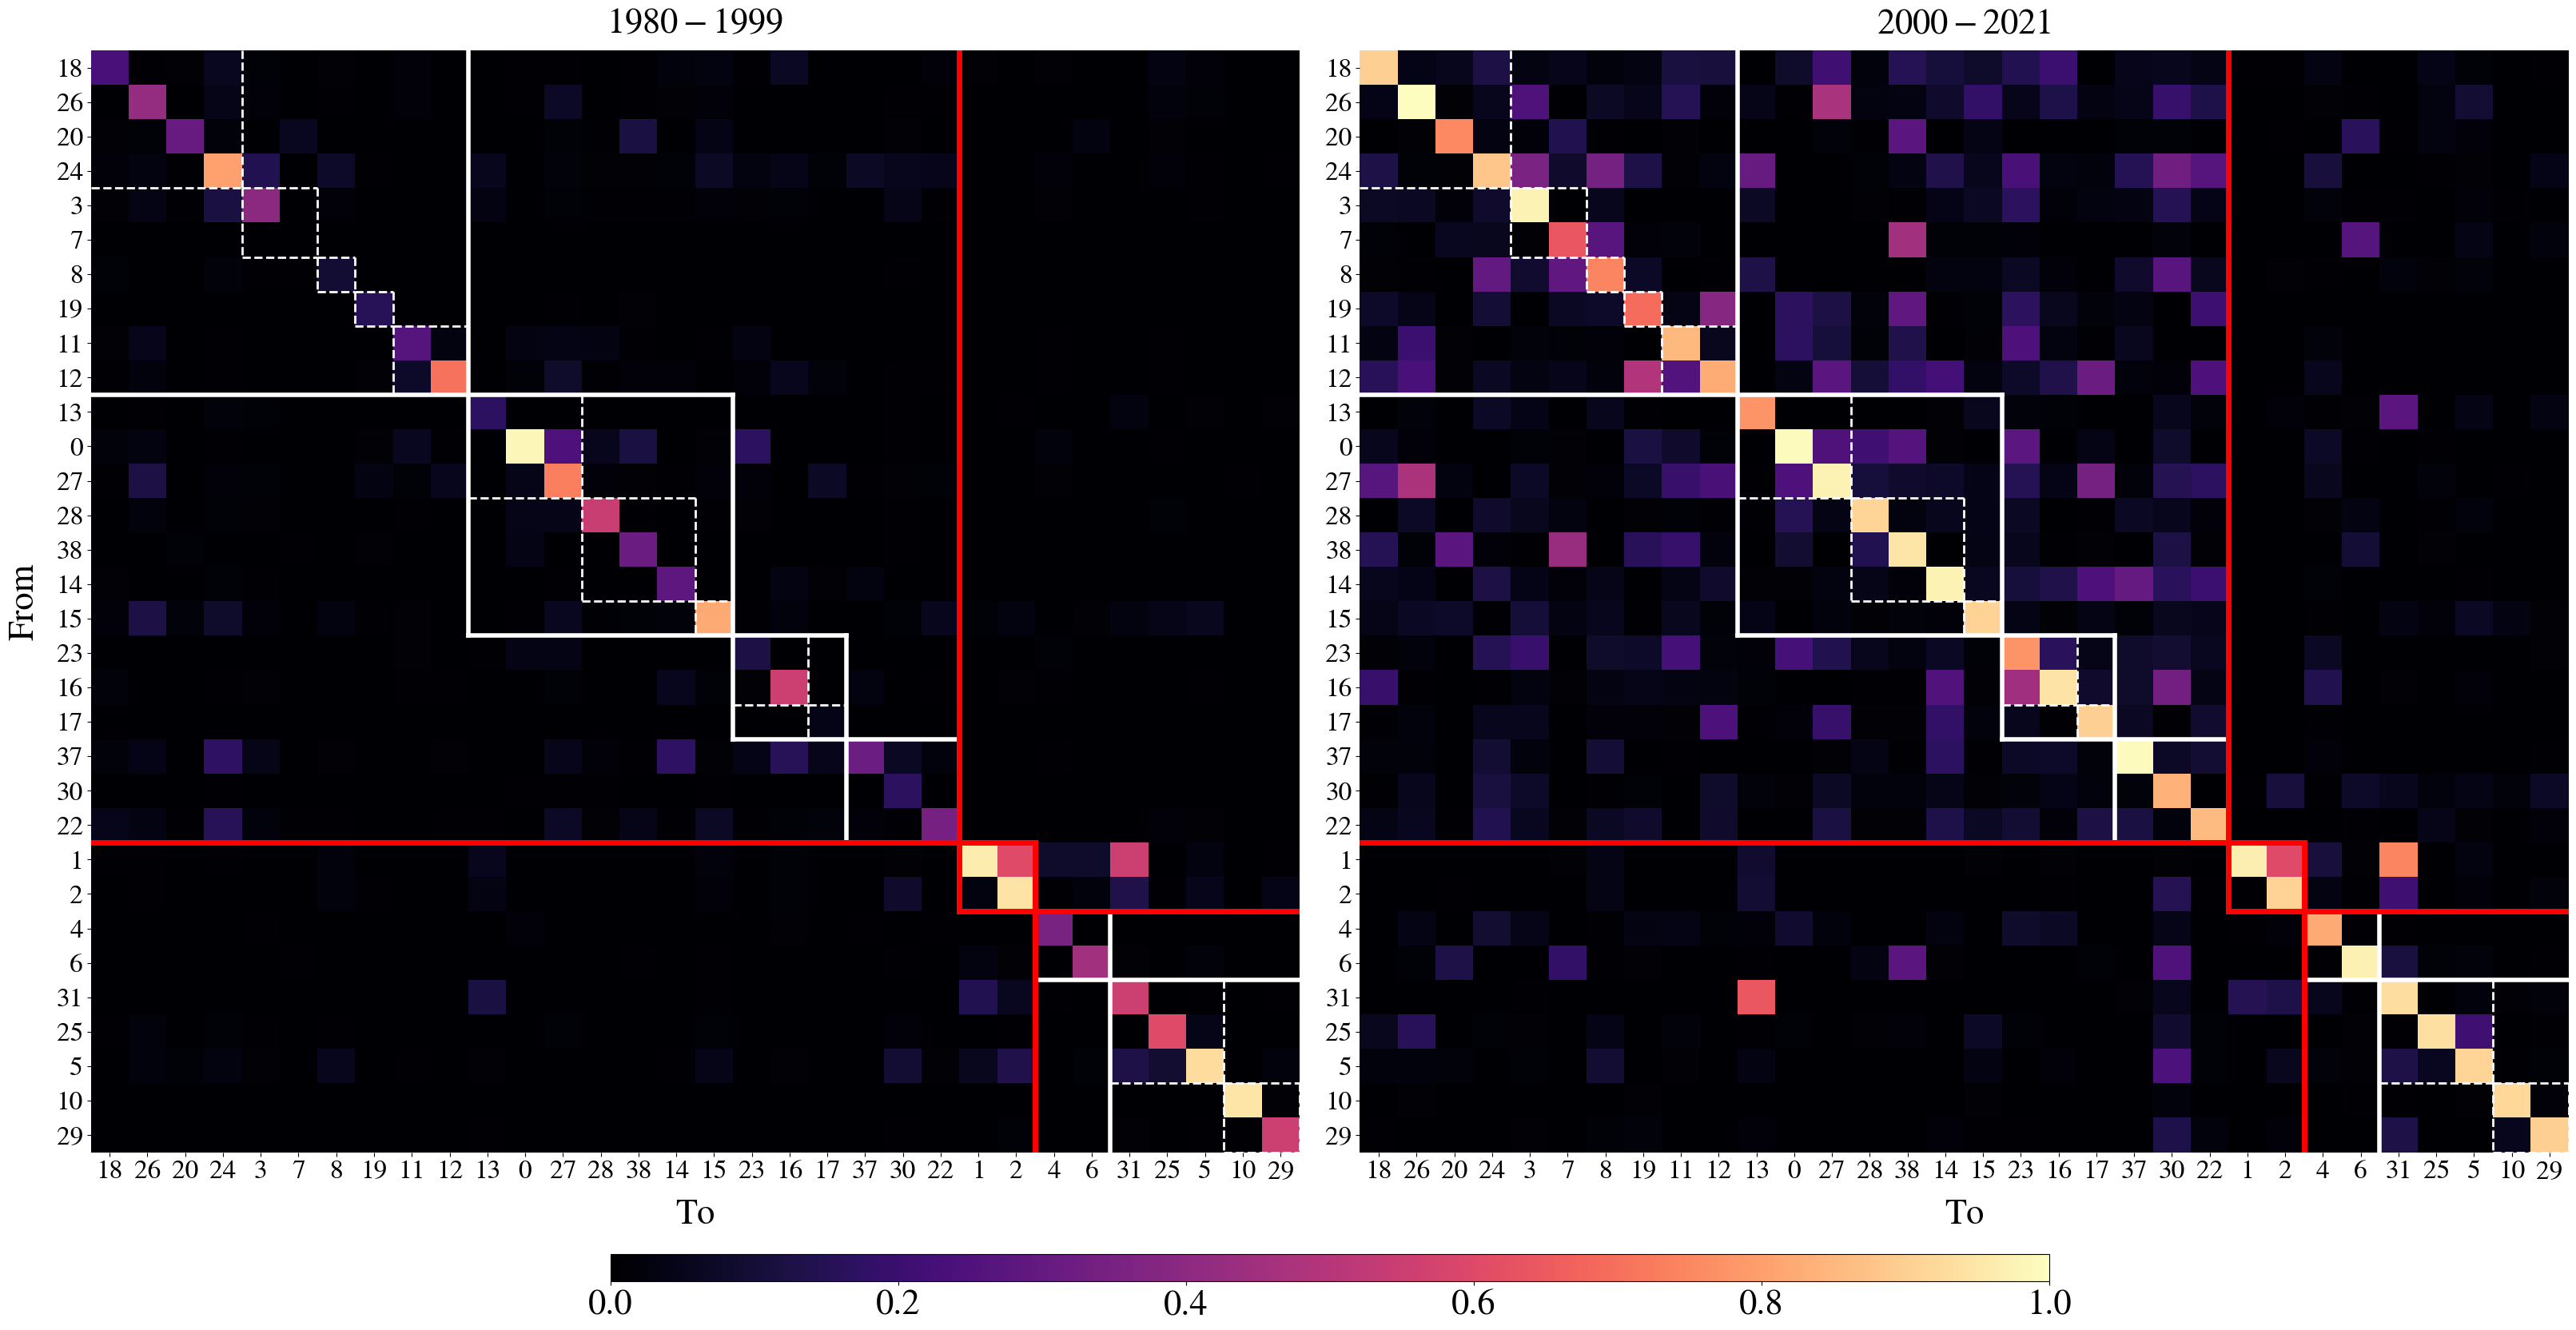

In [133]:
l = 2
fig = plt.figure(figsize=(40,20))
outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[40,1],hspace=0.18)
inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[0],wspace=0.05,hspace=0.12,)

for i,(year_from,year_to) in enumerate([(1980,2000),(2000,2022)]):
    ax = plt.Subplot(fig, inner[i]) 
    tmp = knowledge_flow_normalized_per_field_in_time_to_future_by_level[l].copy()
    tmp = tmp.loc[tmp.year_from.isin(range(year_from,year_to))]
    tmp = tmp.groupby(["cluster_from","cluster_to"],as_index=False).significant_kf.mean()
    
    couples = set([tuple(x) for x in tmp[['cluster_from','cluster_to']].values])
    for cluster_f in keywords_clusters[2].keys():
        for cluster_t in keywords_clusters[2].keys():
            if (cluster_f,cluster_t) not in couples:
                tmp.loc[len(tmp)] = [cluster_f,cluster_t,0]
    
    fig,ax = heatmap(df=tmp, fixed_labels=[], x_label="cluster_to", y_label="cluster_from", values_label="significant_kf", 
            costrains_equal={},figsize=(21,18),
                 filename=paper_figures_folder + f"cluster_analysis/heatmaps/heatmap_knowledge_flow_between_clusters_{l}_new.pdf",
                 ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=2,
                 cut_small_clusters=True,threshold_num_papers=500,do_barplot=False,fig=fig,ax=ax, vmax=1)
    
    ax.set_title("$%d - %d$"%(year_from,year_to-1),y=1.01,fontsize=32)
    fig.add_subplot(ax)
    ax.set_xlabel("To",fontsize=32,labelpad = 14)
    if i==0:
        ax.set_ylabel("From",fontsize=32,labelpad = 14)
    ax.tick_params(labelsize=24) 

inner = gridspec.GridSpecFromSubplotSpec(1, 3, width_ratios = [1,3,1],
                        subplot_spec=outer[1],wspace=0.05,hspace=0.12,)

ax_cmap = plt.Subplot(fig, inner[1])
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="horizontal")
ax_cmap.tick_params(labelsize=32) 
fig.add_subplot(ax_cmap)

fig.savefig(f"{paper_figures_folder}Figure2_lev{l}.pdf")

At level 3, time windows of 5 years

/tmp/2207198.1.all.q/ipykernel_4977/2155359734.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/2207198.1.all.q/ipykernel_4977/2155359734.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/2207198.1.all.q/ipykernel_4977/2155359734.py:340: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


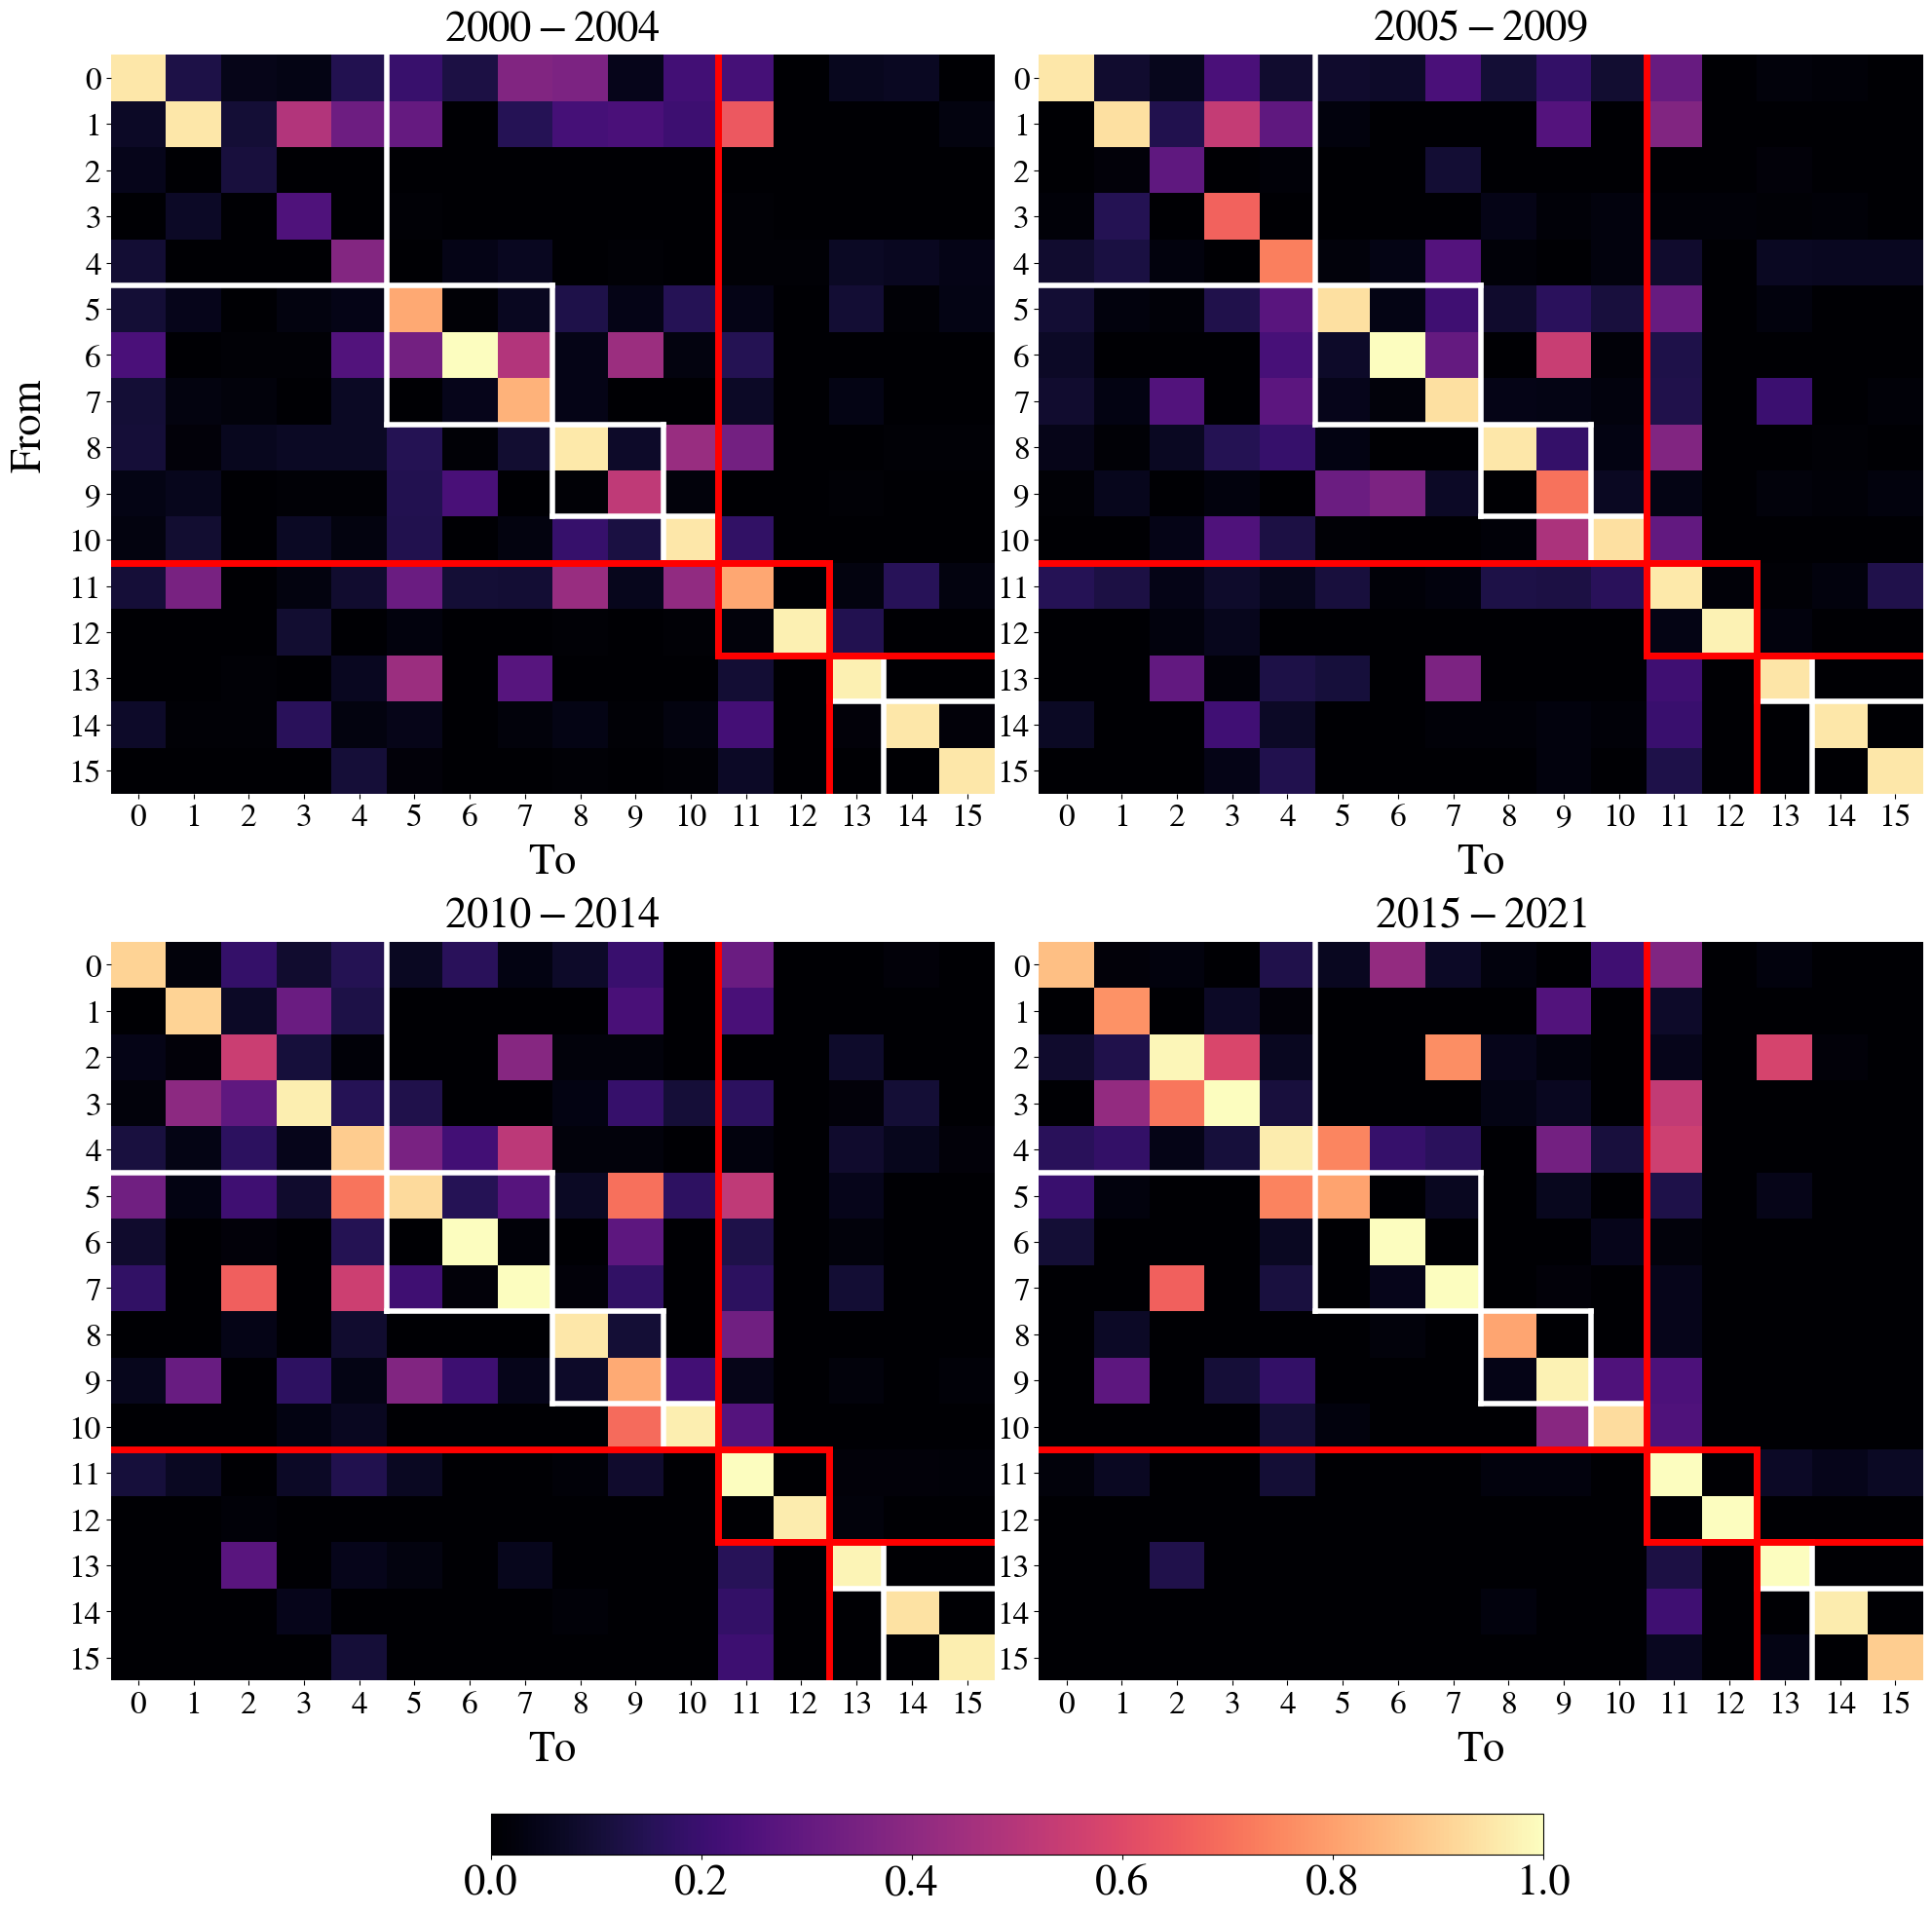

In [134]:
l = 3
fig = plt.figure(figsize=(24,24))
outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[40,1],hspace=0.16)
inner = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outer[0],wspace=0.05,hspace=0.2,)

for i,(year_from,year_to) in enumerate([(2000,2005),(2005,2010),(2010,2015),(2015,2022)]):
    ax = plt.Subplot(fig, inner[i]) 
    
    tmp = knowledge_flow_normalized_per_field_in_time_to_future_by_level[l].copy()
    tmp = tmp.loc[tmp.year_from.isin(range(year_from,year_to))]
    tmp = tmp.groupby(["cluster_from","cluster_to"],as_index=False).significant_kf.mean()
    
    couples = set([tuple(x) for x in tmp[['cluster_from','cluster_to']].values])
    for cluster_f in keywords_clusters[l].keys():
        for cluster_t in keywords_clusters[l].keys():
            if (cluster_f,cluster_t) not in couples:
                tmp.loc[len(tmp)] = [cluster_f,cluster_t,0]
            
    level3_pos = [(x,y) for x,y in pos.items() if x.split("_")[0]=="3"]
    ordered_lev3_clusters_pos = sorted(level3_pos,key = lambda x:x[1][0])
    ordered_lev3_clusters = [int(x[0].split("_")[1].split("\n")[0]) for x in ordered_lev3_clusters_pos]

    ordered_hierarchy_lev_4 = []
    for c in ordered_lev3_clusters:
        for c3 in hierarchy_docs[4].keys():
            if c in hierarchy_docs[4][c3] and c3 not in [x[0] for x in ordered_hierarchy_lev_4]:
                ordered_hierarchy_lev_4.append((c3,hierarchy_docs[4][c3]))
            
    fig,ax = heatmap(df=tmp, fixed_labels=[], x_label="cluster_to", y_label="cluster_from", values_label="significant_kf", 
            costrains_equal={},figsize=(21,18),
                 filename=paper_figures_folder + f"cluster_analysis/heatmaps/heatmap_knowledge_flow_between_clusters_{l}_new.pdf",
                 ordered_cluster_labels=ordered_lev3_clusters, ordered_cluster_groups=ordered_hierarchy_lev_4,linewidth=2,
                 cut_small_clusters=True,threshold_num_papers=500,do_barplot=False,fig=fig,ax=ax, vmax=1,
                 bottom_level=3,top_level=6)
    
    ax.set_title("$%d - %d$"%(year_from,year_to-1),y=1.01,fontsize=32)
    fig.add_subplot(ax)
    ax.set_xlabel("To",fontsize=32,labelpad = 8)
    if i==0:
        ax.set_ylabel("From",fontsize=32,labelpad = 14)
    ax.tick_params(labelsize=24) 

inner = gridspec.GridSpecFromSubplotSpec(1, 3, width_ratios = [1,3,1],
                        subplot_spec=outer[1],wspace=0.05,hspace=0.12,)

ax_cmap = plt.Subplot(fig, inner[1])
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="horizontal")
ax_cmap.tick_params(labelsize=32) 
fig.add_subplot(ax_cmap)

fig.savefig(f"{paper_figures_folder}Figure3_time_window_5_years_lev{l}.pdf")

In [ ]:
l = 2
fig = plt.figure(figsize=(40,20))
outer = gridspec.GridSpec(nrows=2, ncols=1,height_ratios=[40,1],hspace=0.18)
inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                        subplot_spec=outer[0],wspace=0.05,hspace=0.12,)

for i,(year_from,year_to) in enumerate([(1980,2000),(2019,2022)]):
    ax = plt.Subplot(fig, inner[i]) 
    tmp = knowledge_flow_normalized_per_field_in_time_to_future_by_level[l].copy()
    tmp = tmp.loc[tmp.year_from.isin(range(year_from,year_to))]
    tmp = tmp.groupby(["cluster_from","cluster_to"],as_index=False).significant_kf.mean()
    
    couples = set([tuple(x) for x in tmp[['cluster_from','cluster_to']].values])
    for cluster_f in keywords_clusters[2].keys():
        for cluster_t in keywords_clusters[2].keys():
            if (cluster_f,cluster_t) not in couples:
                tmp.loc[len(tmp)] = [cluster_f,cluster_t,0]
    
    fig,ax = heatmap(df=tmp, fixed_labels=[], x_label="cluster_to", y_label="cluster_from", values_label="significant_kf", 
            costrains_equal={},figsize=(21,18),
                 filename=paper_figures_folder + f"cluster_analysis/heatmaps/heatmap_knowledge_flow_between_clusters_{l}_new.pdf",
                 ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,linewidth=2,
                 cut_small_clusters=True,threshold_num_papers=500,do_barplot=False,fig=fig,ax=ax, vmax=1)
    
    ax.set_title("$%d - %d$"%(year_from,year_to-1),y=1.01,fontsize=32)
    fig.add_subplot(ax)
    ax.set_xlabel("To",fontsize=32,labelpad = 14)
    if i==0:
        ax.set_ylabel("From",fontsize=32,labelpad = 14)
    ax.tick_params(labelsize=24) 

inner = gridspec.GridSpecFromSubplotSpec(1, 3, width_ratios = [1,3,1],
                        subplot_spec=outer[1],wspace=0.05,hspace=0.12,)

ax_cmap = plt.Subplot(fig, inner[1])
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0,vmax=1), cmap=plt.get_cmap("magma")), cax=ax_cmap,shrink=0.5,pad=0., fraction=1,orientation="horizontal")
ax_cmap.tick_params(labelsize=32) 
fig.add_subplot(ax_cmap)

# fig.savefig(f"{paper_figures_folder}Figure2_lev{l}.pdf")

# Figure 3

From

In [135]:
tmp = knowledge_flow_normalized_per_field_in_time_to_future_by_level[l].copy()
tmp = tmp.groupby(["cluster_from","cluster_to","year_from"],as_index=False).significant_kf.mean()
tmp = tmp.groupby(["cluster_from","year_from"],as_index=False).significant_kf.mean()


(<Figure size 1200x600 with 1 Axes>, <AxesSubplot:>)

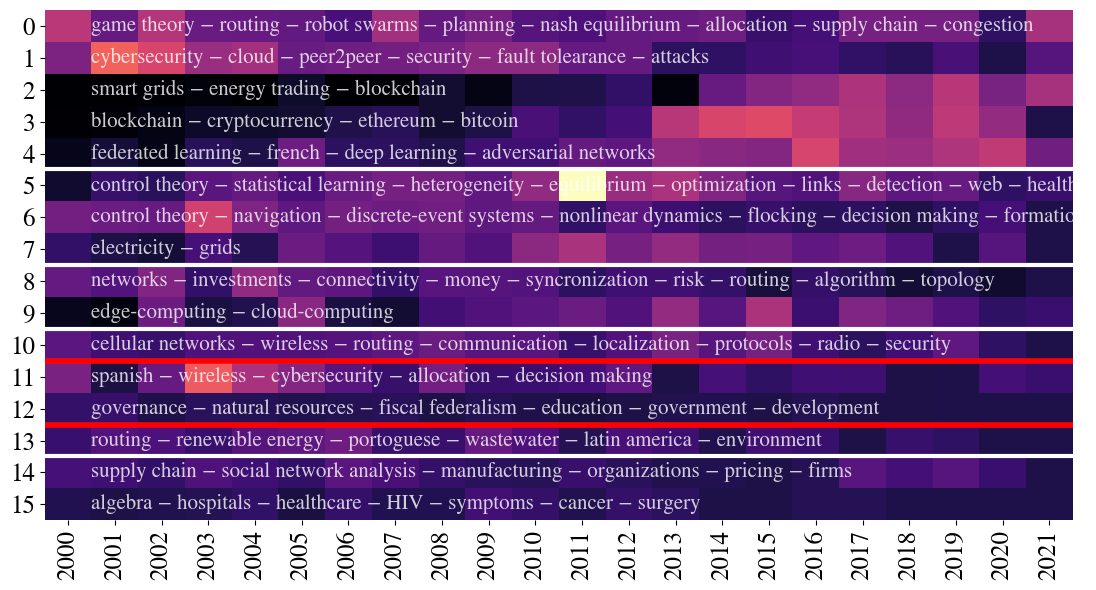

In [136]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
heatmap(df=tmp, fixed_labels=[], x_label="year_from", y_label="cluster_from", values_label="significant_kf", 
             costrains_equal={"year_from":set(range(2000,2022))},#figsize=(21,14),
             ordered_cluster_labels=ordered_lev3_clusters, ordered_cluster_groups=ordered_hierarchy_lev_4,linewidth=1,
             cut_small_clusters=True,threshold_num_papers=500,linelength=150,
             bottom_level=3,top_level=6,
             ax=ax,fig=fig,do_barplot=False)

To

In [137]:
tmp = knowledge_flow_normalized_per_field_in_time_to_future_by_level[l].copy()
tmp = tmp.groupby(["cluster_from","cluster_to","year_from"],as_index=False).significant_kf.mean()
tmp = tmp.groupby(["cluster_to","year_from"],as_index=False).significant_kf.mean()


(<Figure size 1200x600 with 1 Axes>, <AxesSubplot:>)

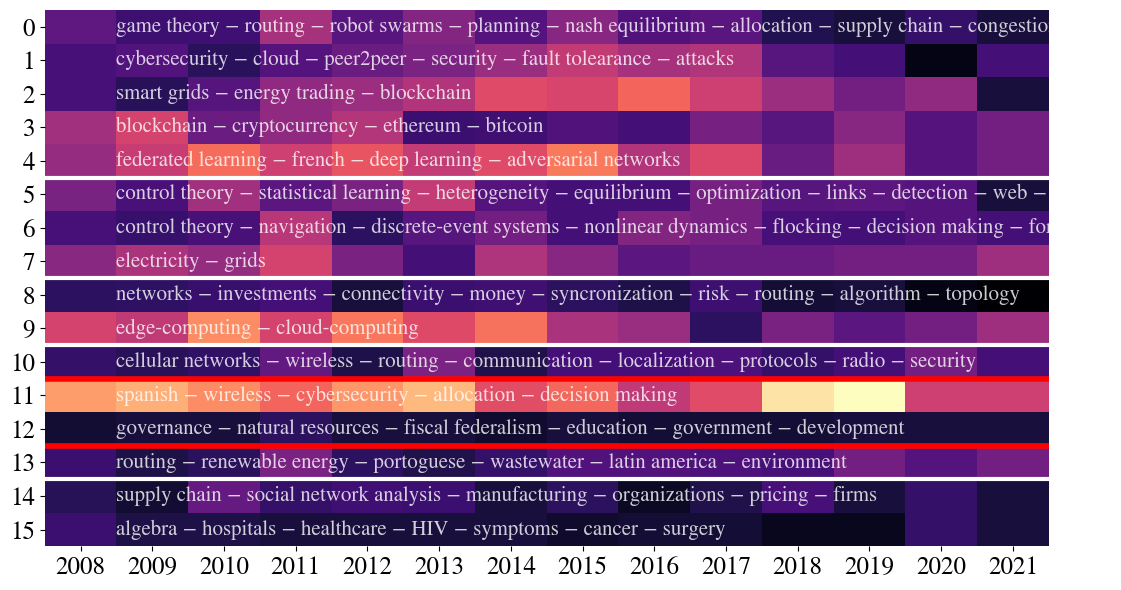

In [138]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
heatmap(df=tmp, fixed_labels=[], x_label="year_from", y_label="cluster_to", values_label="significant_kf", 
             costrains_equal={"year_from":set(range(2008,2022))},#figsize=(21,14),
             ordered_cluster_labels=ordered_lev3_clusters, ordered_cluster_groups=ordered_hierarchy_lev_4,linewidth=1,
             cut_small_clusters=True,threshold_num_papers=2250,linelength=150,
             bottom_level=3,top_level=6,
             ax=ax,fig=fig,do_barplot=False)

In [139]:
def rank_plot(direction='from',clusters = [6], l = 3, threshold_num_papers = 500, ax = ax, colors = ['red'], not_rank = False, first_year = 2008, last_year = 2021):
    
    if direction == 'from':
        direction_inverse = 'to'
    else:
        direction_inverse = 'from'
        
    df = knowledge_flow_normalized_per_field_in_time_to_future_by_level[l].copy()
    df = df.groupby([f"cluster_{direction_inverse}",f"cluster_{direction}","year_from"],as_index=False).significant_kf.mean()
    df = df.groupby([f"cluster_{direction}","year_from"],as_index=False).significant_kf.mean()
    
    to_keep = [x for x in tmp.cluster_to.unique() if len([y for y in name2partition_by_level[l].keys() if name2partition_by_level[l][y]==x]) >= 500]

    df = df.loc[df[f"cluster_{direction}"].isin(to_keep)]
    df['rank'] = df.groupby("year_from").significant_kf.rank(ascending=False,method='first')

    if not_rank:
        df['rank'] = df['significant_kf']

    palette = {x:'grey' for x in range(30)}
    palette[6] = 'red'
    # sn.lineplot(data=tmp.loc[tmp.year_from>=2000],x='year_from',y='significant_kf',hue='cluster_to',palette=palette)

#     fig, ax = plt.subplots(figsize=(12,6))

    for cluster in df[f'cluster_{direction}'].unique():
    #     if len([x for x in name2partition_by_level[l].keys() if name2partition_by_level[l][x]==cluster]) < 500:
    #                     continue
        t = df.loc[(df.year_from>=first_year)&(df.year_from<=last_year)&(df[f"cluster_{direction}"] == cluster)].sort_values("year_from")

        if cluster not in clusters:
            ax.plot(t.year_from,t['rank'],color='grey',linewidth=1)
        else:
            ax.plot(t.year_from,t['rank'],color=colors[clusters.index(cluster)],linewidth=3,zorder=1000, label=keywords_clusters_onekeyword[l][cluster])
            
    if not not_rank:
        ax.invert_yaxis()
        ticks = ax.set_yticks(range(1,17))
    # ax.set_ylim(bottom=10)
    
    return ax

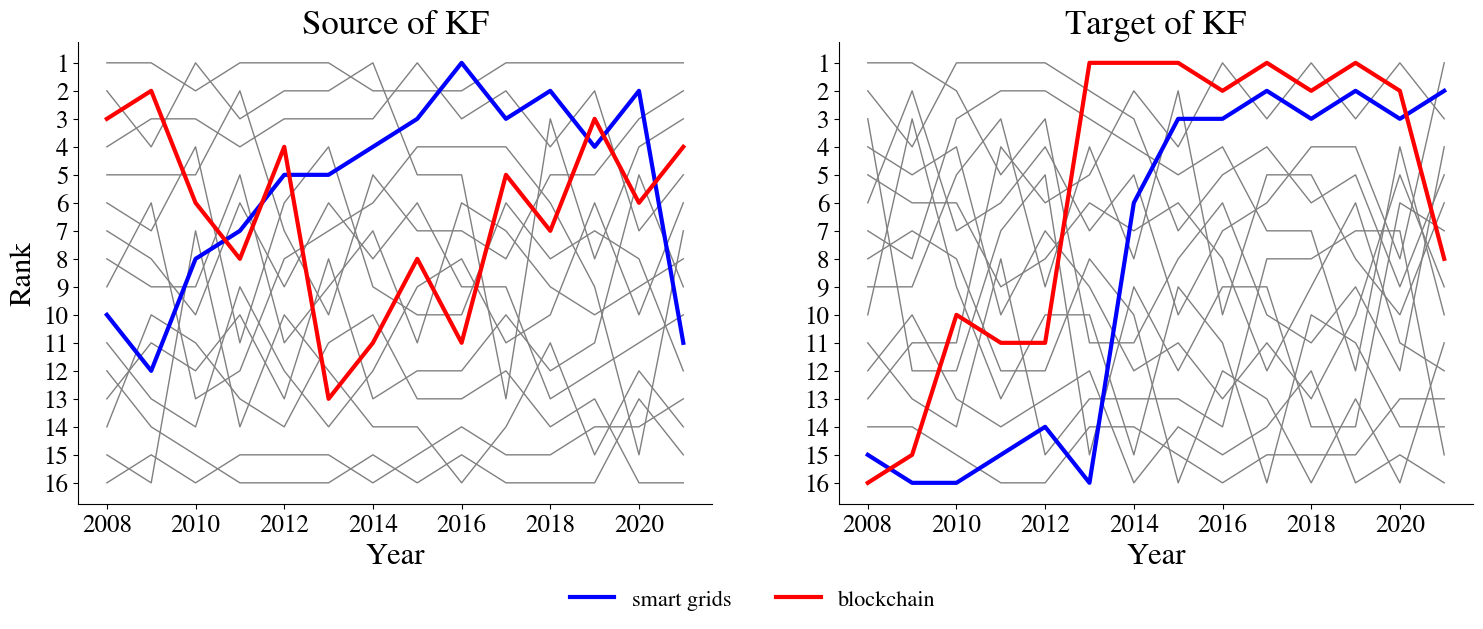

In [140]:
fig, axes = plt.subplots(1,2,figsize=(18,6))

# colors = ['red','orange','blue','green']
colors = ['red','blue']
clusters = [3,2]

ax = axes[0]
t = rank_plot(direction='to',clusters = clusters, l = 3, threshold_num_papers = 500, ax = ax, colors = colors)
ax.set_title("Source of KF")
ax.set_ylabel("Rank")
ax.set_xlabel("Year")

ax = axes[1]
rank_plot(direction='from',clusters = clusters, l = 3, threshold_num_papers = 500, ax = ax, colors = colors)
ax.set_title("Target of KF")
ax.set_xlabel("Year")

legend = plt.legend(loc='center',bbox_to_anchor = [0.5,-0.05], bbox_transform = fig.transFigure, ncol=len(clusters))

fig.savefig(f"{paper_figures_folder}Tentative_fig3_rank.pdf")

# Figure 4
Main figure is done in rplot.ipynb, here we just generate the data for it

## 2 stage version

In [141]:
from utils.hsbm_knowledge_flow import check_papers_existence,create_papers_existence_set,assign_partition

In [142]:
all_docs_dict2, t,tt = assign_partition(h_t_doc_consensus_by_level,hyperlink_g,2,all_docs_dict)

In [143]:
papers_existence_set = create_papers_existence_set(all_docs_dict2)

In [144]:
def average_kf_significance(df,years,cluster,threshold = 1, direction='from'):
    
    if direction == 'from':
        direction_inverse = 'to'
    else:
        direction_inverse = 'from'
        
    df = df.loc[(df[f'cluster_{direction_inverse}'] == cluster)&(df[f'year_{direction_inverse}'].isin(years))]
    
    df = df.loc[df.apply(lambda x: check_papers_existence(x[f'cluster_{direction}'],x[f'year_{direction}'],papers_existence_set),axis=1)]
    
    df['significant_kf'] = df.knowledge_flow >= threshold

    df = df.groupby([f"cluster_{direction}","year_from"],as_index=False).significant_kf.mean()
    df = df.groupby([f"cluster_{direction}"],as_index=False).significant_kf.mean()
    
    df[f'cluster_{direction_inverse}'] = cluster
    
    return df

In [145]:
clusters_to_keep = [x for x,y in keywords_clusters[2].items() if len([t for t in name2partition_by_level[2].keys() if name2partition_by_level[2][t]==x]) >= 500 ]

In [146]:
df = average_kf_significance(knowledge_flow_normalized_per_field_in_time_by_level[l],range(2008,2022),8,direction='from')
df = df.loc[df.cluster_from.isin(clusters_to_keep)]

In [147]:
tmp = df.sort_values("significant_kf",ascending=False)
tmp['cluster'] = tmp.cluster_from.map(keywords_clusters_onekeyword[2])

In [148]:
to_keep_from = tmp.cluster_from.iloc[:11].values

In [149]:
df = average_kf_significance(knowledge_flow_normalized_per_field_in_time_by_level[l],range(2008,2022),8,direction='to')
df = df.loc[df.cluster_to.isin(clusters_to_keep)]

In [150]:
tmp = df.sort_values("significant_kf",ascending=False)
tmp['cluster'] = tmp.cluster_to.map(keywords_clusters_onekeyword[2])

In [151]:
to_keep_to = tmp.cluster_to.iloc[:11].values

In [152]:
def do_sankey(df,x1,x2,y1,y2,direction,number=10, pad = 15, threshold_num_papers = 500):
    
    clusters_to_keep = [x for x,y in keywords_clusters[2].items() if len([t for t in name2partition_by_level[2].keys() if name2partition_by_level[2][t]==x]) >= threshold_num_papers ]
    data = df.copy()
    label = sorted(data[f"cluster_{direction}"].unique())
    data = data.loc[data[f"cluster_{direction}"]!=8]
    data = data.loc[data[f"cluster_{direction}"].isin(clusters_to_keep)]
    
#     data = data.loc[data.significant_kf > threshold]
    data = data.sort_values("significant_kf",ascending=False).iloc[:number]

    # override gray link colors with 'source' colors
    opacity = 0.4
    # change 'magenta' to its 'rgba' value to add opacity
    # data['data'][0]['node']['color'] = ['rgba(255,0,255, 0.8)' if color == "magenta" else color for color in data['data'][0]['node']['color']]
    # data['data'][0]['link']['color'] = [data['data'][0]['node']['color'][src].replace("0.8", str(opacity))
    #                                     for src in data['data'][0]['link']['source']]

    sankey = go.Sankey(
    #     valueformat = ".0f",
    #     valuesuffix = "TWh",
        # Define nodes
        node = dict(
          pad = pad,
          thickness = 15,
    #       line = dict(color = "black", width = 0.5),
          label =  [keywords_clusters_onekeyword[2][x] for x in label],
    #       color =  data['data'][0]['node']['color']
        ),
        # Add links
        link = dict(
          source =  data.cluster_from.apply(lambda x: label.index(x)).values,
          target =  data.cluster_to.apply(lambda x: label.index(x)).values,
          value =  data.significant_kf.values,
    #       label =  data['data'][0]['link']['label'],
    #       color =  data['data'][0]['link']['color']
    ),
        domain={
            'x': [x1, x2],
            'y': [y1, y2]
        }
    )
    
    return sankey

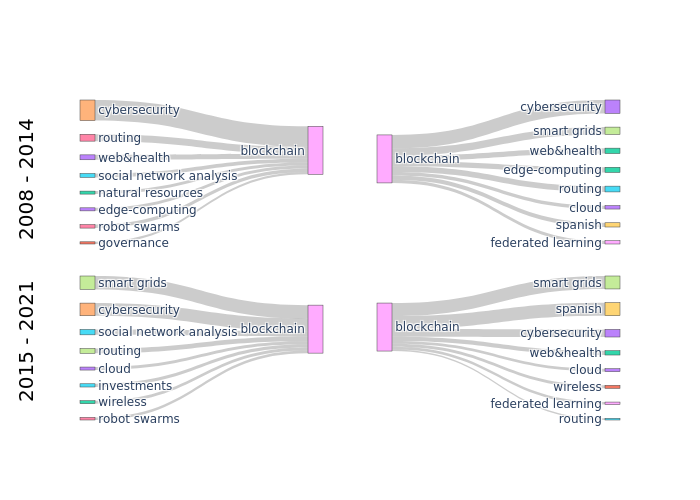

In [153]:
import plotly.graph_objects as go
import urllib, json

threshold = 0.1
l = 2
number = 8

df11 = average_kf_significance(knowledge_flow_normalized_per_field_in_time_by_level[l],range(2008,2015),8,direction='from')
sankey11 = do_sankey(df11,0,0.45,0.55,1,'from', number=number, pad = 100)

df12 = average_kf_significance(knowledge_flow_normalized_per_field_in_time_by_level[l],range(2008,2015),8,direction='to')
sankey12 = do_sankey(df12,0.55,1.0,0.55,1,'to', number=number)

df21 = average_kf_significance(knowledge_flow_normalized_per_field_in_time_by_level[l],range(2015,2022),8,direction='from')
sankey21 = do_sankey(df21,0,0.45,0,.45,'from', number=number)

df22 = average_kf_significance(knowledge_flow_normalized_per_field_in_time_by_level[l],range(2015,2022),8,direction='to')
sankey22 = do_sankey(df22,0.55,1,0,.45,'to', number=number)

fig = go.Figure(data=[sankey11,sankey12,sankey21,sankey22])


# fig.update_layout(title_text="Energy forecast for 2050<br>Source: Department of Energy & Climate Change, Tom Counsell via <a href='https://bost.ocks.org/mike/sankey/'>Mike Bostock</a>",
#                   font_size=10)

fig.add_annotation(dict(font=dict(color='black',size=20),
                                        x=-0.1,
                                        y=.95,
                                        showarrow=False,
                                        text="2008 - 2014",
                                        textangle=-90,
                                        xanchor='center',
                                        xref="paper",
                                        yref="paper",))

fig.add_annotation(dict(font=dict(color='black',size=20),
                                        x=-0.1,
                                        y=.05,
                                        showarrow=False,
                                        text="2015 - 2021",
                                        textangle=-90,
                                        xanchor='center',
                                        xref="paper",
                                        yref="paper",))

img_bytes = fig.to_image(format="png", engine="kaleido")
from IPython.display import Image
# fig.write_image(f"{paper_figures_folder}figure4.pdf")
# fig.write_html(f"{paper_figures_folder}figure4.html")
Image(img_bytes)

In [154]:
clusters_to_keep = [x for x,y in keywords_clusters[2].items() if len([t for t in name2partition_by_level[2].keys() if name2partition_by_level[2][t]==x]) >= 500 ]

df_before_from = df11.loc[(df11.cluster_from.isin(clusters_to_keep))&(df11.cluster_from.isin(to_keep_from))].sort_values("significant_kf",ascending=False)
df_after_from = df21.loc[(df21.cluster_from.isin(clusters_to_keep))&(df21.cluster_from.isin(to_keep_from))].sort_values("significant_kf",ascending=False)

df_before_from['rank'] = range(len(df_before_from))
df_after_from['rank'] = np.array(range(len(df_after_from))) + len(df_after_from)

In [155]:
label = list(df_before_from.iloc[1:].cluster_from.values) + list(df_after_from.iloc[1:].cluster_from.values)

source = []
target = []
value = []

for i in range(1,len(df_before_from)):
    source.append(df_before_from.iloc[i]['rank']-1.)
    target.append(df_after_from.loc[df_after_from.cluster_from == df_before_from.iloc[i]['cluster_from']]['rank'].iloc[0] -2.)
    value.append(1.)

data = pd.DataFrame(data = {'source':source,
                           'target':target,
                           'value':value})

In [219]:
data.to_csv(os.path.join(results_folder,"Figure_4_data_from.csv"),index=False)
pd.Series(label,name='name').map(keywords_clusters_onekeyword[l]).to_csv(os.path.join(results_folder,"Figure_4_data_from_nodes.csv"),index=False)

In [159]:
clusters_to_keep = [x for x,y in keywords_clusters[2].items() if len([t for t in name2partition_by_level[2].keys() if name2partition_by_level[2][t]==x]) >= 500 ]

df_before_to = df12.loc[(df12.cluster_to.isin(clusters_to_keep))&(df12.cluster_to.isin(to_keep_to))].sort_values("significant_kf",ascending=False)
df_after_to = df22.loc[(df22.cluster_to.isin(clusters_to_keep))&(df22.cluster_to.isin(to_keep_to))].sort_values("significant_kf",ascending=False)

df_before_to['rank'] = range(len(df_before_to))
df_after_to['rank'] = np.array(range(len(df_after_to))) + len(df_after_to)

In [160]:
label = list(df_before_to.iloc[1:].cluster_to.values) + list(df_after_to.iloc[1:].cluster_to.values)

source = []
target = []
value = []

for i in range(1,len(df_before_to)):
    source.append(df_before_to.iloc[i]['rank']-1.)
    target.append(df_after_to.loc[df_after_to.cluster_to == df_before_to.iloc[i]['cluster_to']]['rank'].iloc[0] -2.)
    value.append(1.)

data = pd.DataFrame(data = {'source':source,
                           'target':target,
                           'value':value})

In [218]:
data.to_csv(os.path.join(results_folder,"Figure_4_data_to.csv"),index=False)
pd.Series(label,name='name').map(keywords_clusters_onekeyword[l]).to_csv(os.path.join(results_folder,"Figure_4_data_to_nodes.csv"),index=False)

## 3 stage version

In [228]:
from utils.hsbm_knowledge_flow import check_papers_existence,create_papers_existence_set,assign_partition

In [229]:
one_keyword_lev_3 = {\
  remap_lev_3[0]: 'robot swarms', 
  remap_lev_3[1]: 'control theory',
  remap_lev_3[2]: 'governance',
  remap_lev_3[3]: 'cybersecurity',
  remap_lev_3[4]: 'environment',
  remap_lev_3[5]: 'smart grids',
  remap_lev_3[6]: 'blockchain',
  remap_lev_3[7]: 'health',
  remap_lev_3[8]: 'optimization',
  remap_lev_3[9]: 'investments',
  remap_lev_3[10]: 'telecommunication',
  remap_lev_3[11]: 'edge-computing',
  remap_lev_3[12]: 'federated learning',
  remap_lev_3[13]: 'wireless',
  remap_lev_3[14]: 'social network analysis',
  remap_lev_3[15]: '',
  remap_lev_3[16]: 'supply chain',
  remap_lev_3[17]: '',
  remap_lev_3[18]: 'electricity',
  remap_lev_3[19]: 'conference proceedings', 
  remap_lev_3[20]: 'transportation', 
}

In [230]:
l = 3
blockchain_cluster = 3
# l = 2
# blockchain_cluster = 8

In [231]:
all_docs_dict2, t,tt = assign_partition(h_t_doc_consensus_by_level,hyperlink_g,l,all_docs_dict)

In [232]:
papers_existence_set = create_papers_existence_set(all_docs_dict2)

In [233]:
def average_kf_significance(df,years,cluster,threshold = 1, direction='from'):
    
    if direction == 'from':
        direction_inverse = 'to'
    else:
        direction_inverse = 'from'
        
    df = df.loc[(df[f'cluster_{direction_inverse}'] == cluster)&(df[f'year_{direction_inverse}'].isin(years))]
    
    df = df.loc[df.apply(lambda x: check_papers_existence(x[f'cluster_{direction}'],x[f'year_{direction}'],papers_existence_set),axis=1)]
    
    df['significant_kf'] = df.knowledge_flow >= threshold

    df = df.groupby([f"cluster_{direction}","year_from"],as_index=False).significant_kf.mean()
    df = df.groupby([f"cluster_{direction}"],as_index=False).significant_kf.mean()
    
    df[f'cluster_{direction_inverse}'] = cluster
    
    return df

In [234]:
df11 = average_kf_significance(knowledge_flow_normalized_per_field_in_time_by_level[l],range(2008,2015),blockchain_cluster,direction='from')
df21 = average_kf_significance(knowledge_flow_normalized_per_field_in_time_by_level[l],range(2015,2019),blockchain_cluster,direction='from')
df31 = average_kf_significance(knowledge_flow_normalized_per_field_in_time_by_level[l],range(2019,2022),blockchain_cluster,direction='from')

df12 = average_kf_significance(knowledge_flow_normalized_per_field_in_time_by_level[l],range(2008,2015),blockchain_cluster,direction='to')
df22 = average_kf_significance(knowledge_flow_normalized_per_field_in_time_by_level[l],range(2015,2019),blockchain_cluster,direction='to')
df32 = average_kf_significance(knowledge_flow_normalized_per_field_in_time_by_level[l],range(2019,2022),blockchain_cluster,direction='to')

In [235]:
clusters_to_keep = [x for x,y in keywords_clusters[l].items() if len([t for t in name2partition_by_level[l].keys() if name2partition_by_level[l][t]==x]) >= 500 ]

In [236]:
df = average_kf_significance(knowledge_flow_normalized_per_field_in_time_by_level[l],range(2008,2022),blockchain_cluster,direction='from')
df = df.loc[df.cluster_from.isin(clusters_to_keep)]

In [237]:
tmp = df.sort_values("significant_kf",ascending=False)
tmp['cluster'] = tmp.cluster_from.map(keywords_clusters_onekeyword[l])

In [238]:
to_keep_from = tmp.cluster_from.iloc[:111].values
to_keep_from

array([ 3,  2,  1, 14,  0,  8, 10,  9, 11, 12,  5,  4, 13, 15,  6,  7])

In [239]:
df = average_kf_significance(knowledge_flow_normalized_per_field_in_time_by_level[l],range(2008,2022),blockchain_cluster,direction='to')
df = df.loc[df.cluster_to.isin(clusters_to_keep)]

In [240]:
tmp = df.sort_values("significant_kf",ascending=False)
tmp['cluster'] = tmp.cluster_to.map(keywords_clusters_onekeyword[l])

In [241]:
to_keep_to = tmp.cluster_to.iloc[:111].values
to_keep_to

array([ 3,  2,  1, 11,  4,  9,  5,  8, 10, 14,  0, 13,  6,  7, 12, 15])

In [242]:
df_before_from = df11.loc[(df11.cluster_from.isin(clusters_to_keep))&(df11.cluster_from.isin(to_keep_from))].sort_values("significant_kf",ascending=False)
df_middle_from = df21.loc[(df21.cluster_from.isin(clusters_to_keep))&(df21.cluster_from.isin(to_keep_from))].sort_values("significant_kf",ascending=False)
df_after_from = df31.loc[(df31.cluster_from.isin(clusters_to_keep))&(df31.cluster_from.isin(to_keep_from))].sort_values("significant_kf",ascending=False)

df_before_from['rank'] = range(len(df_before_from))
df_middle_from['rank'] = np.array(range(len(df_middle_from))) + len(df_middle_from)
df_after_from['rank'] = np.array(range(len(df_after_from))) + len(df_after_from)*2

In [243]:
label = list(df_before_from.iloc[1:].cluster_from.values) + list(df_middle_from.iloc[1:].cluster_from.values) + list(df_after_from.iloc[1:].cluster_from.values)

source = []
target = []
value = []

for i in range(1,len(df_before_from)):
    source.append(df_before_from.iloc[i]['rank']-1.)
    target.append(df_middle_from.loc[df_middle_from.cluster_from == df_before_from.iloc[i]['cluster_from']]['rank'].iloc[0] -2.)
    value.append(1.)

for i in range(1,len(df_middle_from)):
    source.append(df_middle_from.iloc[i]['rank']-2.)
    target.append(df_after_from.loc[df_after_from.cluster_from == df_middle_from.iloc[i]['cluster_from']]['rank'].iloc[0] - 3.)
    value.append(1.)

data = pd.DataFrame(data = {'source':source,
                           'target':target,
                           'value':value})

In [244]:
data.to_csv(os.path.join(results_folder,"Figure_4_data_from3.csv"),index=False)
# pd.Series(label,name='name').map(keywords_clusters_onekeyword[l]).to_csv(os.path.join(results_folder,"Figure_4_data_from3_nodes.csv"),index=False)
pd.Series(label,name='name').map(one_keyword_lev_3).to_csv(os.path.join(results_folder,"Figure_4_data_from3_nodes.csv"),index=False)

In [245]:
df_before_to = df12.loc[(df12.cluster_to.isin(clusters_to_keep))&(df12.cluster_to.isin(to_keep_to))].sort_values("significant_kf",ascending=False)
df_middle_to = df22.loc[(df22.cluster_to.isin(clusters_to_keep))&(df22.cluster_to.isin(to_keep_to))].sort_values("significant_kf",ascending=False)
df_after_to = df32.loc[(df32.cluster_to.isin(clusters_to_keep))&(df32.cluster_to.isin(to_keep_to))].sort_values("significant_kf",ascending=False)

df_before_to['rank'] = range(len(df_before_to))
df_middle_to['rank'] = np.array(range(len(df_middle_to))) + len(df_middle_to)
df_after_to['rank'] = np.array(range(len(df_after_to))) + len(df_after_to)*2

In [246]:
label = list(df_before_to.iloc[1:].cluster_to.values) + list(df_middle_to.iloc[1:].cluster_to.values) + list(df_after_to.iloc[1:].cluster_to.values)

source = []
target = []
value = []

for i in range(1,len(df_before_to)):
    source.append(df_before_to.iloc[i]['rank']-1.)
    target.append(df_middle_to.loc[df_middle_to.cluster_to == df_before_to.iloc[i]['cluster_to']]['rank'].iloc[0] -2.)
    value.append(1.)

for i in range(1,len(df_after_to)):
    source.append(df_middle_to.iloc[i]['rank']-2.)
    target.append(df_after_to.loc[df_after_to.cluster_to == df_middle_to.iloc[i]['cluster_to']]['rank'].iloc[0] - 3.)
    value.append(1.)

data = pd.DataFrame(data = {'source':source,
                           'target':target,
                           'value':value})

In [247]:
data.to_csv(os.path.join(results_folder,"Figure_4_data_to3.csv"),index=False)
# pd.Series(label,name='name').map(keywords_clusters_onekeyword[l]).to_csv(os.path.join(results_folder,"Figure_4_data_to3_nodes.csv"),index=False)
pd.Series(label,name='name').map(one_keyword_lev_3).to_csv(os.path.join(results_folder,"Figure_4_data_to3_nodes.csv"),index=False)

# Other stuff

## 2008-2014 influenced by

In [180]:
y = knowledge_flow_normalized_per_field_in_time_by_level[2].copy()
y = y.loc[(y.cluster_to == 8)&(y.year_to>2007)&(y.year_to<2015)]
y['significant_kf'] = y.knowledge_flow >= 2

In [181]:
y = y.loc[y.year_from > 1900].groupby(["cluster_from","year_from"],as_index=False).significant_kf.mean()
y['cluster_to'] = 8

/tmp/2207198.1.all.q/ipykernel_4977/2155359734.py:338: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



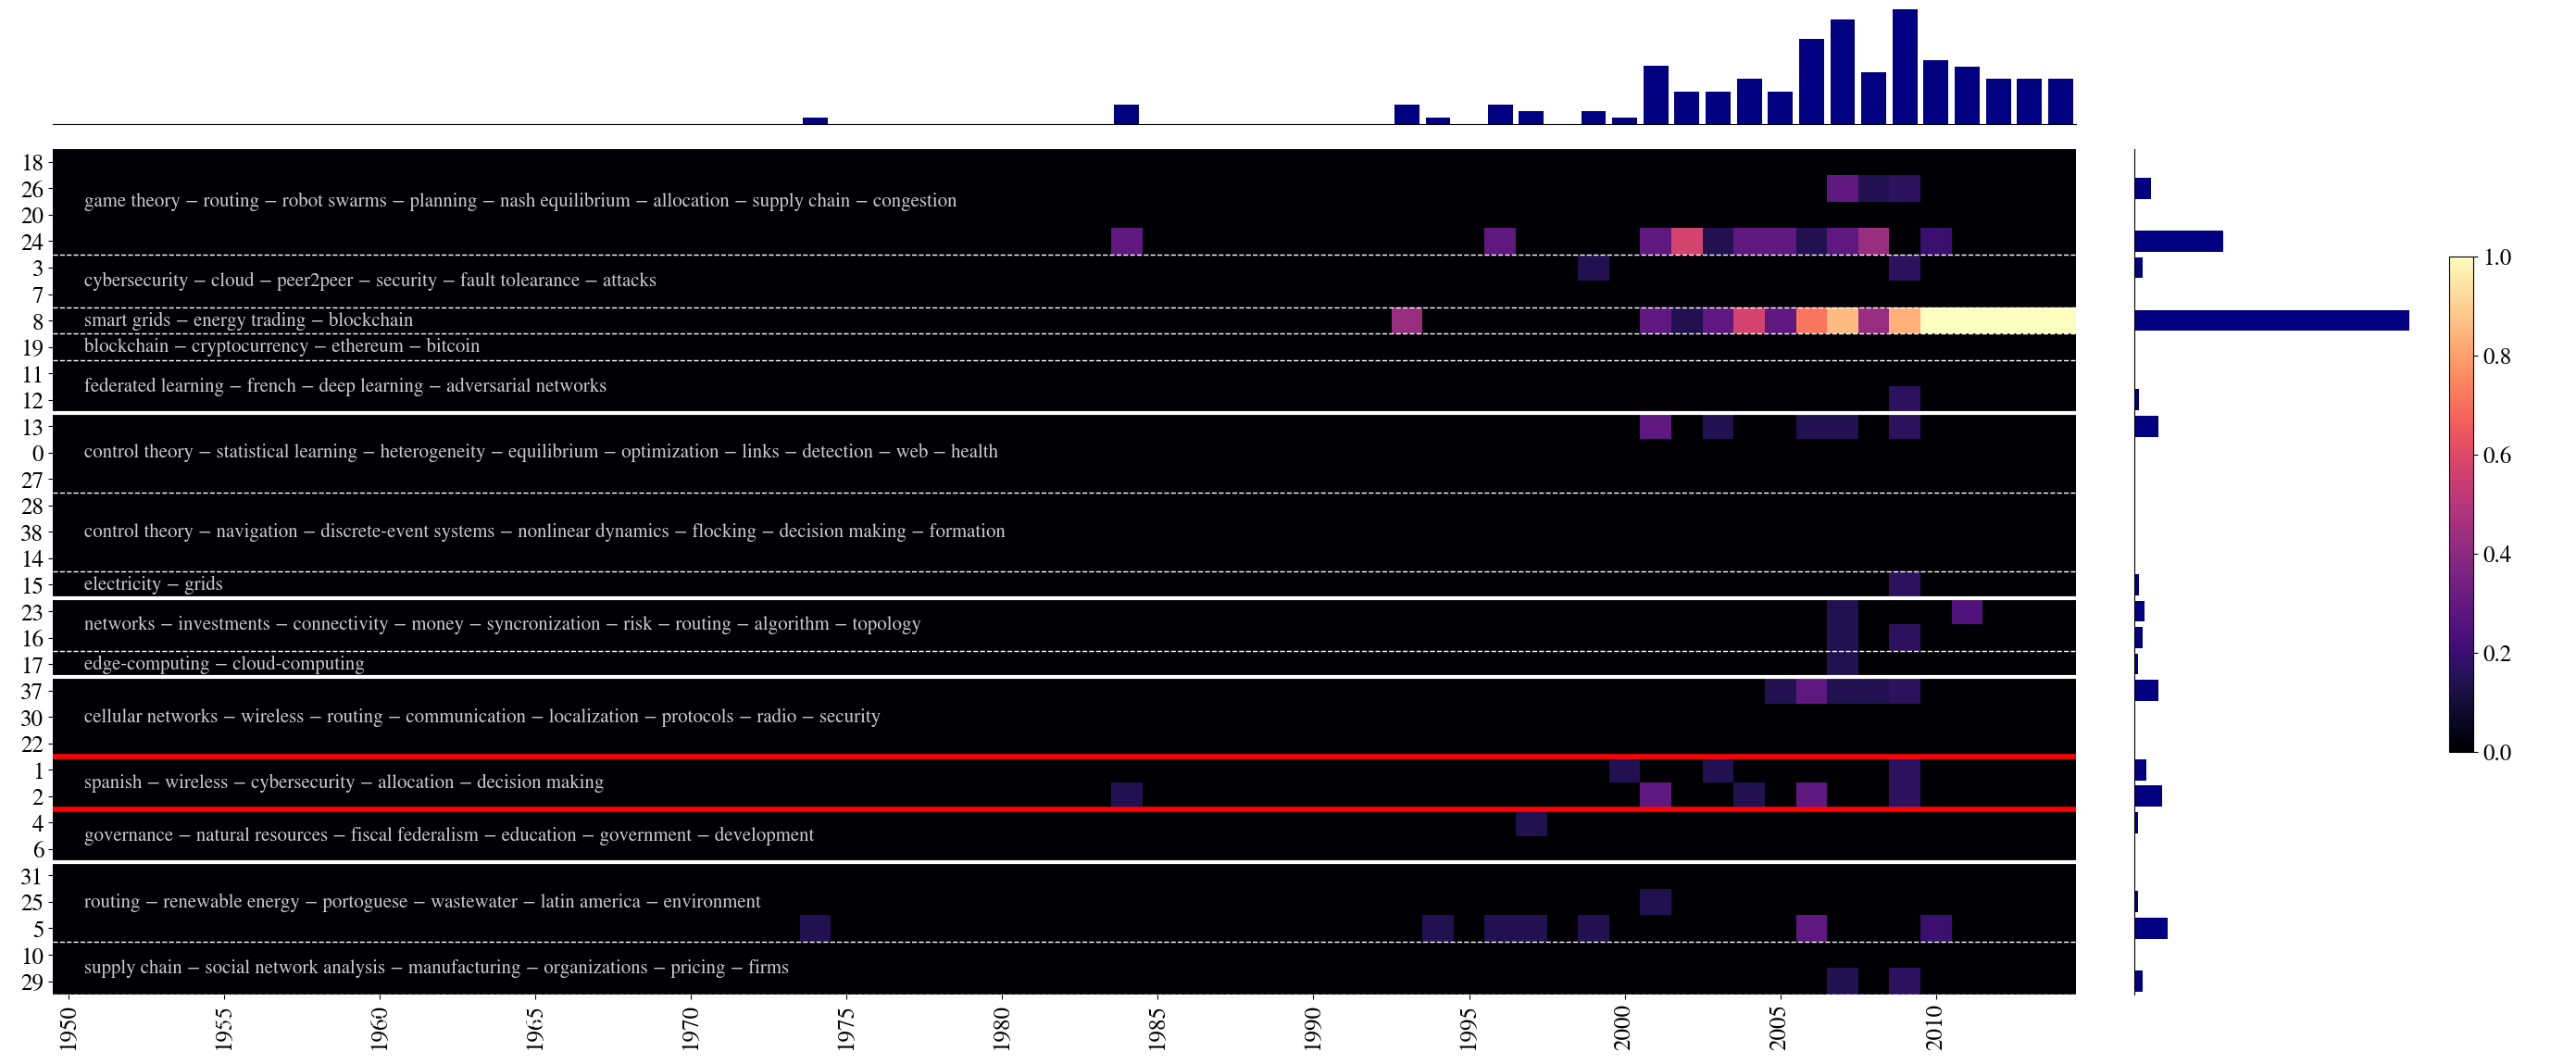

In [182]:
fig = heatmap(df=y, fixed_labels=["cluster_to"], x_label="year_from", y_label="cluster_from", values_label="significant_kf", 
            costrains_equal={"cluster_to":set([8]), "year_from":set(range(1950,2022))},figsize=(28,14),cut_small_clusters=True,threshold_num_papers=500,
              ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,
             bottom_level=2, linelength=150)

In [183]:
keywords_clusters[2][5]

'social network analysis\norganizations\nfirms'

## 2015-2022 influenced by

In [184]:
y = knowledge_flow_normalized_per_field_in_time_by_level[2].copy()
y = y.loc[(y.cluster_to == 8)&(y.year_to>=2015)]
y['significant_kf'] = y.knowledge_flow >= 1

In [185]:
y = y.loc[y.year_from > 1900].groupby(["cluster_from","year_from"],as_index=False).significant_kf.mean()
y['cluster_to'] = 8

/tmp/2207198.1.all.q/ipykernel_4977/2155359734.py:338: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



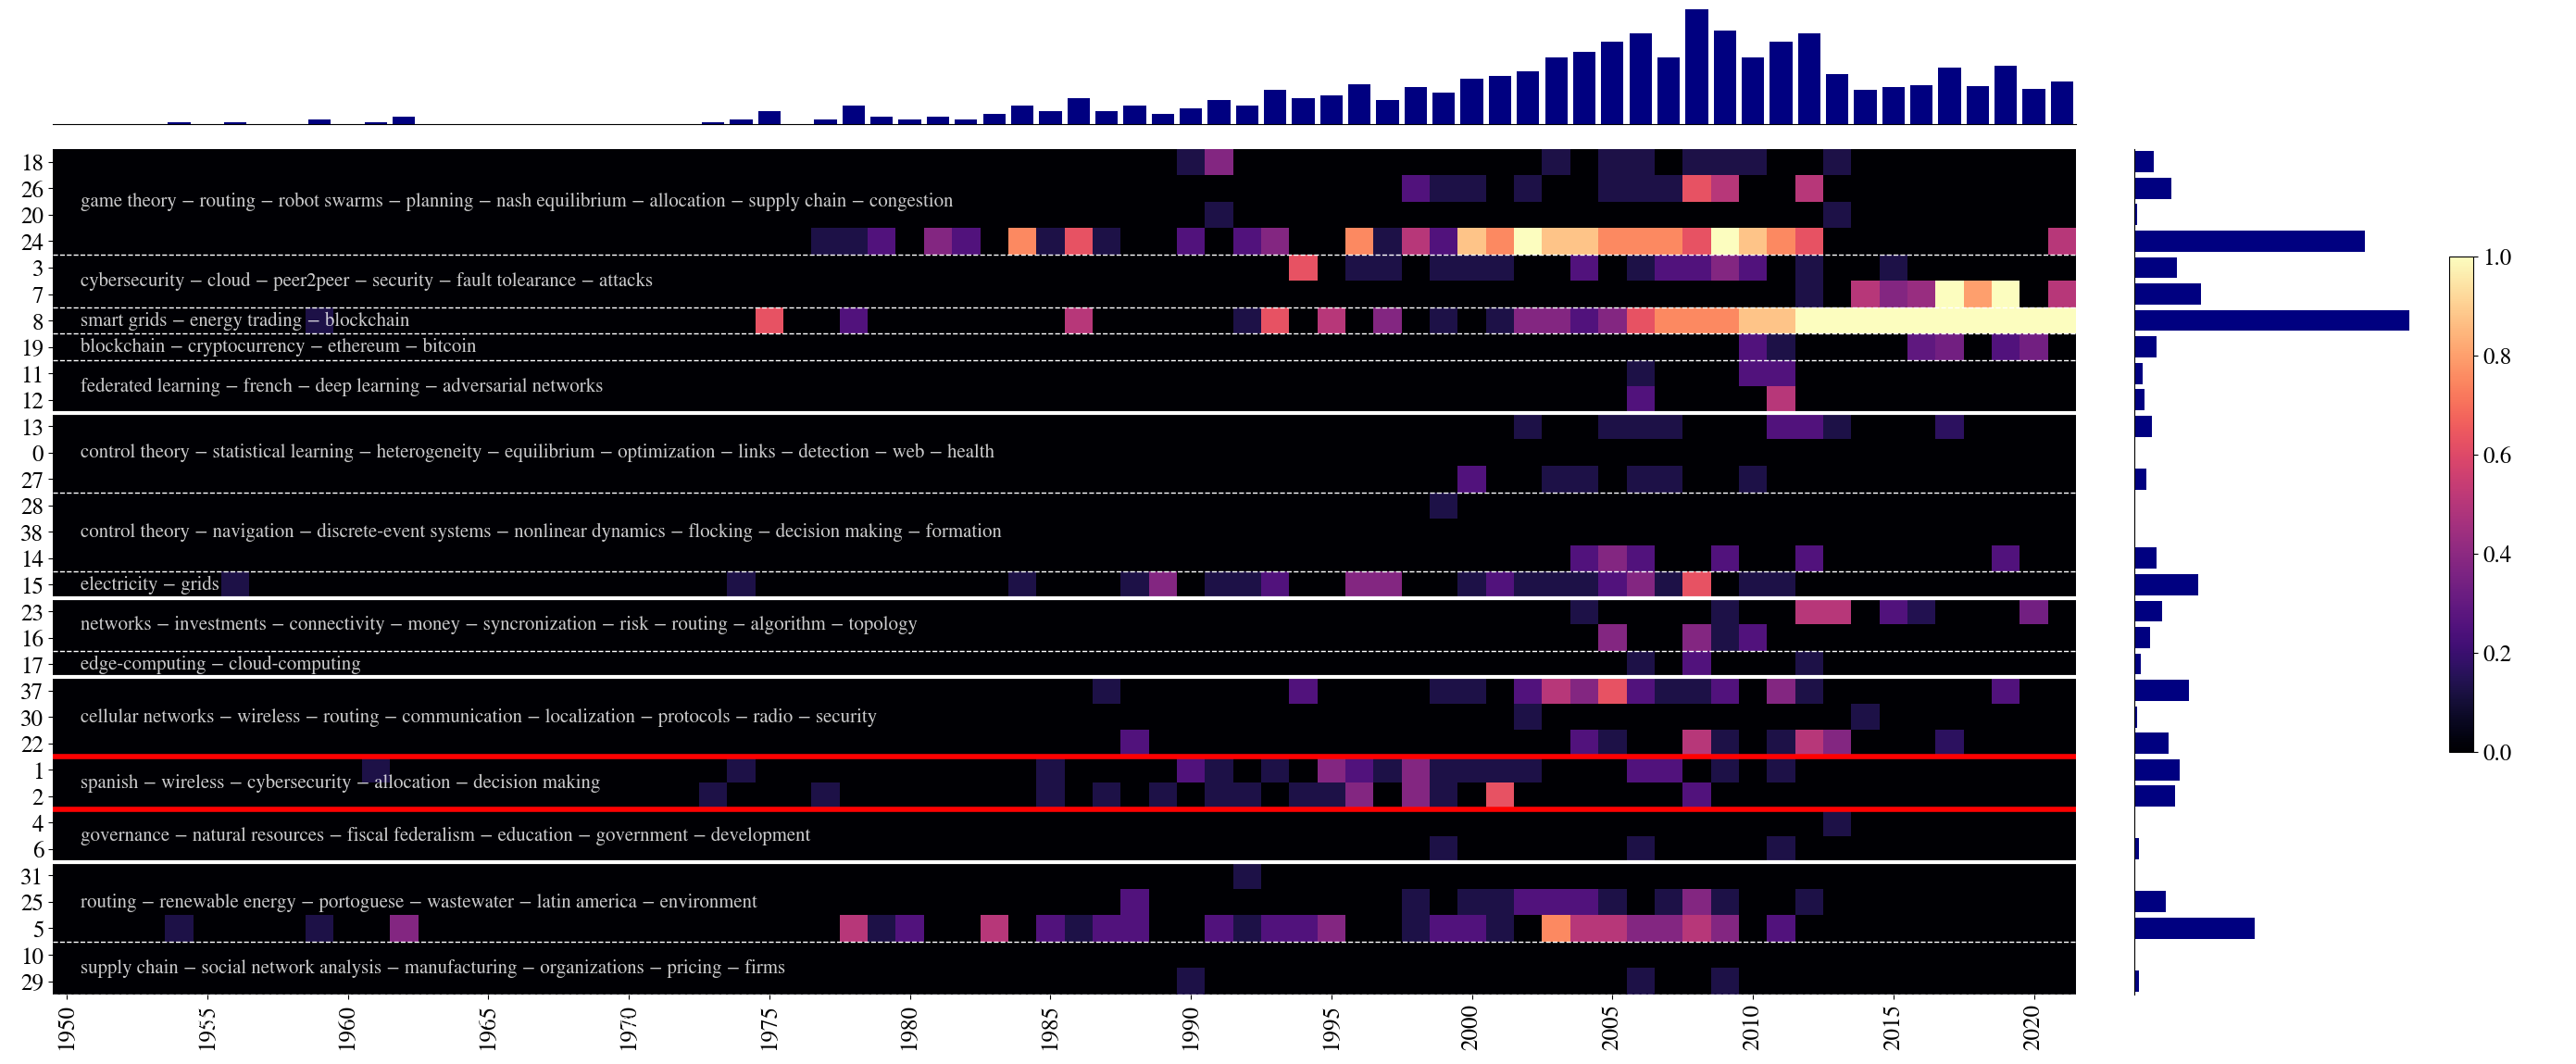

In [186]:
fig = heatmap(df=y, fixed_labels=["cluster_to"], x_label="year_from", y_label="cluster_from", values_label="significant_kf", 
            costrains_equal={"cluster_to":set([8]), "year_from":set(range(1950,2022))},figsize=(28,14),cut_small_clusters=True,threshold_num_papers=500,
              ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3,
                          bottom_level=2, linelength=150)

## 2019-2022 influenced by

In [187]:
y = knowledge_flow_normalized_per_field_in_time_by_level[2].copy()
y = y.loc[(y.cluster_to == 8)&(y.year_to>=2019)]
y['significant_kf'] = y.knowledge_flow >= 2

In [188]:
y = y.loc[y.year_from > 1900].groupby(["cluster_from","year_from"],as_index=False).significant_kf.mean()
y['cluster_to'] = 8

/tmp/2207198.1.all.q/ipykernel_4977/2155359734.py:338: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



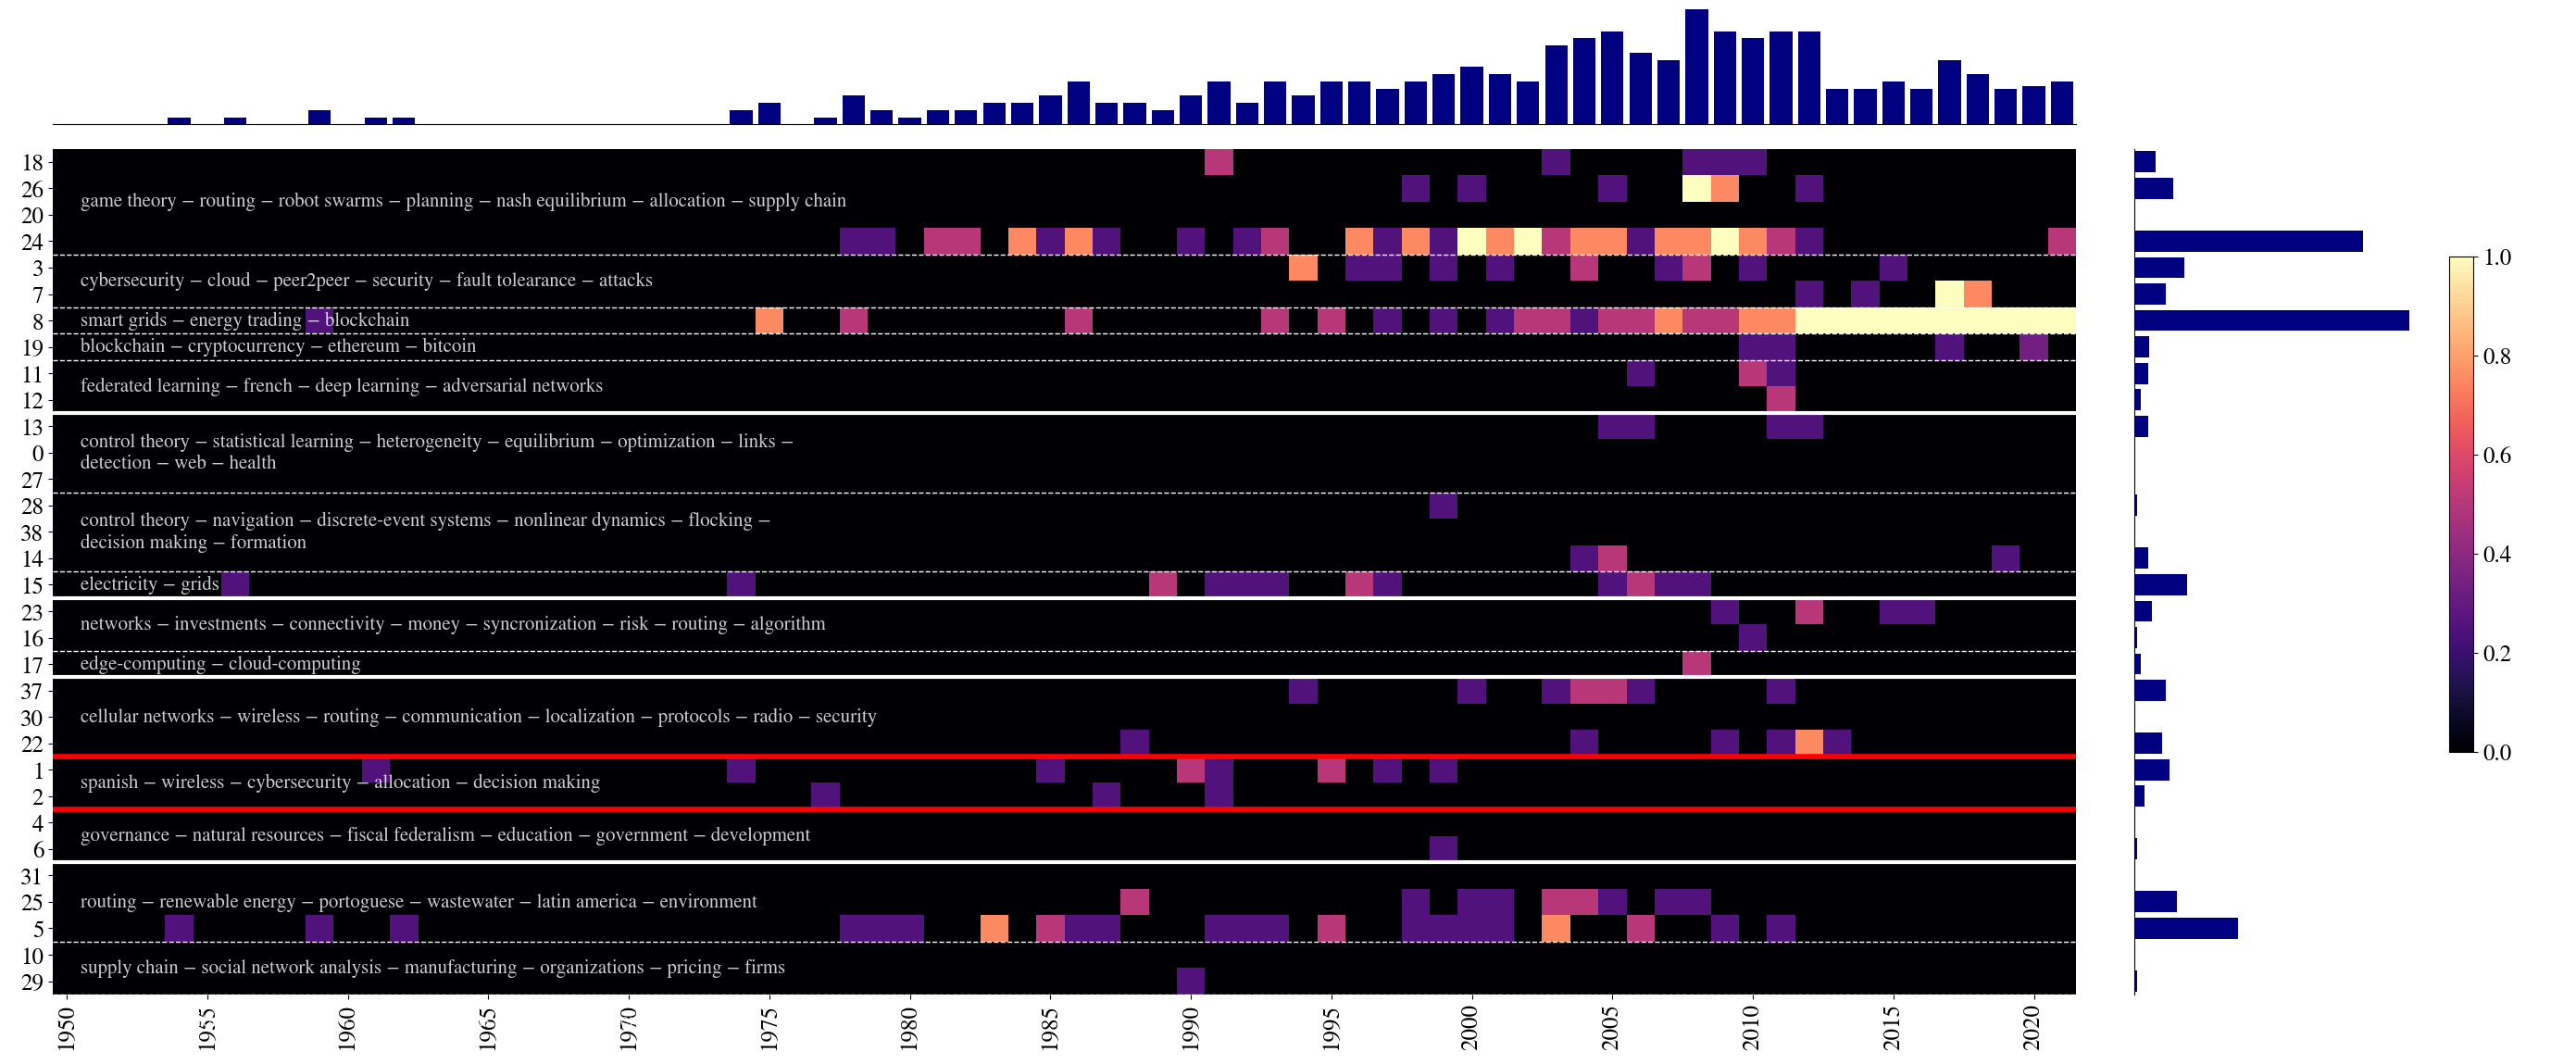

In [189]:
fig = heatmap(df=y, fixed_labels=["cluster_to"], x_label="year_from", y_label="cluster_from", values_label="significant_kf", 
            costrains_equal={"cluster_to":set([8]), "year_from":set(range(1950,2022))},figsize=(28,14),cut_small_clusters=True,threshold_num_papers=500,
              ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3)

In [190]:
keywords_clusters[2][15]

'investments\nmoney\nrisk\nalgorithm'

## 2002-2022 influence to

In [191]:
y = knowledge_flow_normalized_per_field_in_time_by_level[2].copy()
y = y.loc[(y.cluster_from == 8)&(y.year_to>=2002)]
y['significant_kf'] = y.knowledge_flow >= 2

In [192]:
y = y.loc[y.year_from > 1900].groupby(["cluster_to","year_from"],as_index=False).significant_kf.mean()
y['cluster_from'] = 8

/tmp/2207198.1.all.q/ipykernel_4977/2155359734.py:338: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



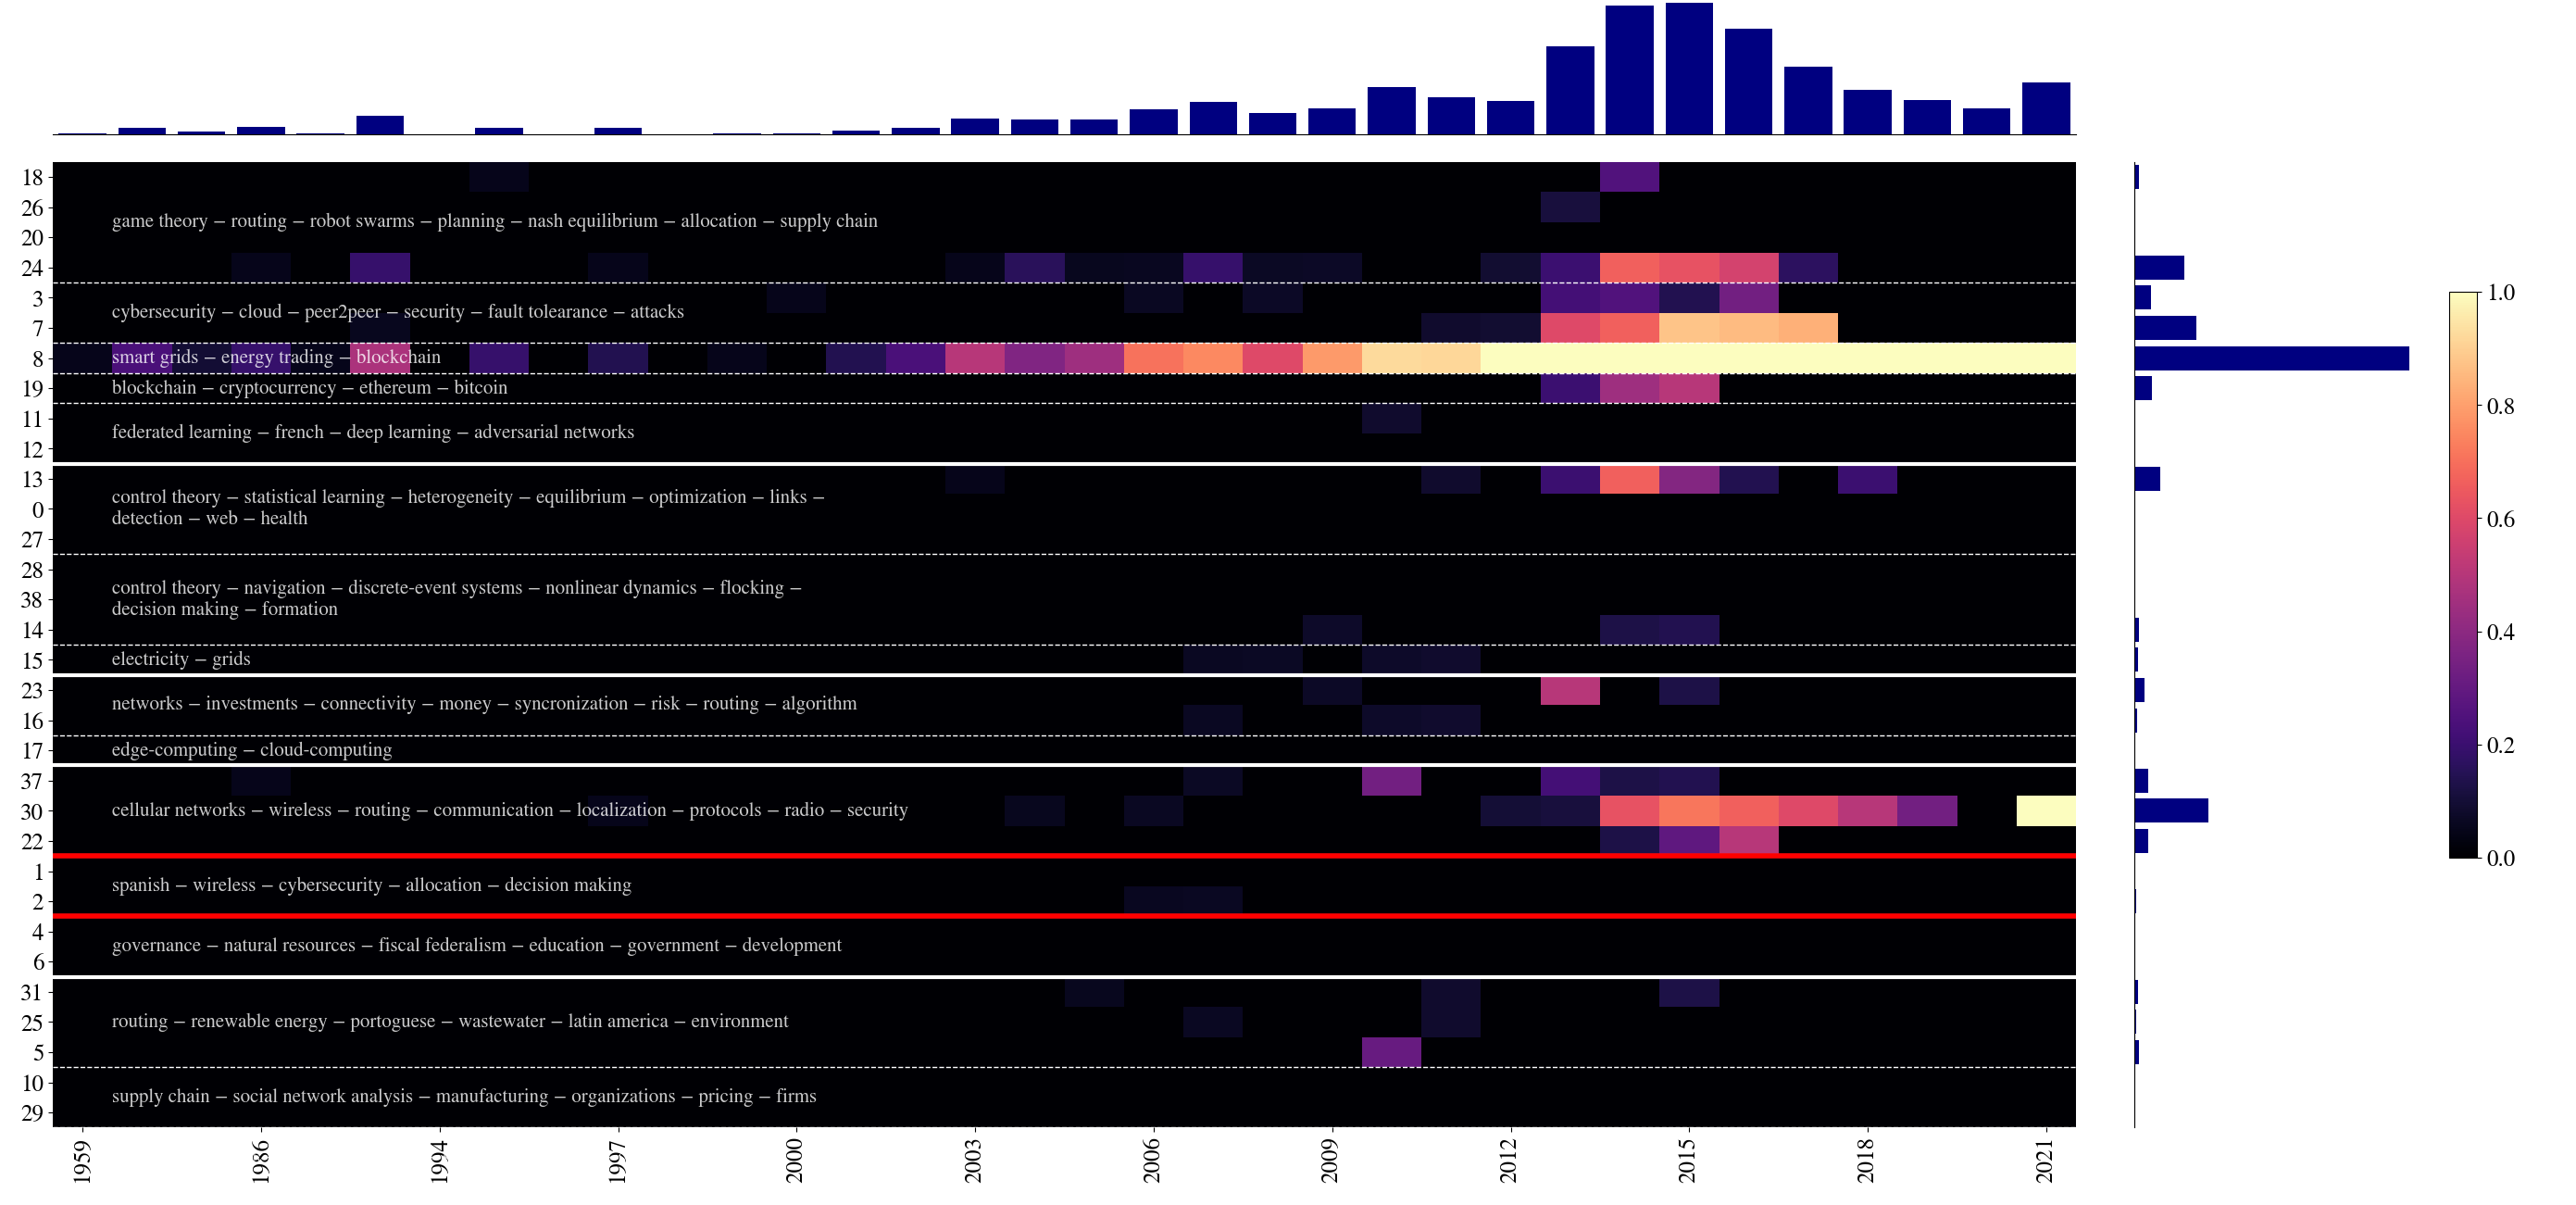

In [193]:
fig = heatmap(df=y, fixed_labels=["cluster_from"], x_label="year_from", y_label="cluster_to", values_label="significant_kf", 
            costrains_equal={"cluster_from":set([8]), "year_from":set(range(1950,2022))},figsize=(28,16),cut_small_clusters=True,threshold_num_papers=500,
              ordered_cluster_labels=ordered_lev2_clusters, ordered_cluster_groups=ordered_hierarchy_lev_3)

In [194]:
keywords_clusters[2][30]

'spanish'

In [195]:
keywords_clusters[2][12]

'statistical learning\noptimization\ndetection'